In [1]:
from torch import nn
import torch
import argparse
import numpy as np
import pandas as pd
import scanpy as sc
import os
import anndata
import math

# import warnings
# warnings.filterwarnings("ignore", category=UserWarning)

Load configuration from yaml file.

In [2]:
from utils import yaml_config_hook,save_model

parser = argparse.ArgumentParser()
config = yaml_config_hook("config/config.yaml")
for k, v in config.items():
    parser.add_argument(f"--{k}", default=v, type=type(v))
args = parser.parse_args([])
if not os.path.exists(args.model_path):
    os.makedirs(args.model_path)

# torch.manual_seed(args.seed)
# torch.cuda.manual_seed_all(args.seed)
# torch.cuda.manual_seed(args.seed)
# np.random.seed(args.seed)
class_num = args.classnum

Preprocessing the data

In [3]:
import scipy.sparse
sparse_X = scipy.sparse.load_npz('data/filtered_Counts.npz')
annoData = pd.read_table('data/annoData.txt')
y = annoData["cellIden"].to_numpy()
high_var_gene = args.num_genes
# normlization and feature selection
adataSC = anndata.AnnData(X=sparse_X, obs=np.arange(sparse_X.shape[0]), var=np.arange(sparse_X.shape[1]))
sc.pp.filter_genes(adataSC, min_cells=10)
adataSC.raw = adataSC
sc.pp.highly_variable_genes(adataSC, n_top_genes=high_var_gene, flavor='seurat_v3')
sc.pp.normalize_total(adataSC, target_sum=1e4)
sc.pp.log1p(adataSC)

adataNorm = adataSC[:, adataSC.var.highly_variable]
dataframe = adataNorm.to_df()
x_ndarray = dataframe.values.squeeze()
y_ndarray = np.expand_dims(y, axis=1)
print(x_ndarray.shape,y_ndarray.shape)
dataframe.head()

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\anndata\_core\anndata.py:107: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if index_name in anno:


(8569, 6000) (8569, 1)


,1,2,4,7,10,13,26,31,32,33,...,20104,20105,20108,20109,20115,20118,20121,20122,20123,20124
0,1.024218,0.0,0.0,0.0000,1.302199,0.0,0.0,0.0,0.637877,0.0,...,0.0000,0.0,0.36896,0.0,0.0000,0.0,0.637877,0.0000,0.000000,0.368960
1,0.000000,0.0,0.0,0.0000,1.351171,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.888292,0.0000,0.305824,0.000000
2,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.000000,0.0000,0.000000,0.000000
3,0.000000,0.0,0.0,0.4175,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.4175,0.0,0.00000,0.0,0.4175,0.0,0.937850,0.4175,0.000000,0.000000
4,0.000000,0.0,0.0,0.0000,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0000,0.0,0.00000,0.0,0.0000,0.0,0.509045,0.0000,0.000000,0.509045


Create pytorch dataloader with batch size equals to the size of the validation set.

In [4]:
from torch.utils.data import DataLoader,random_split,TensorDataset
scDataset = TensorDataset(torch.tensor(x_ndarray, dtype=torch.float32),
                              torch.tensor(y_ndarray, dtype=torch.float32))

scTrainLength = int(len(scDataset) * 0.8)
scValidLength = len(scDataset) - scTrainLength
scTrain, scValid = random_split(scDataset, [scTrainLength, scValidLength])
# print(scValidLength)
scTrainDataLoader = DataLoader(scTrain, shuffle=True, batch_size=args.batch_size,drop_last=True)
scValidDataLoader = DataLoader(scValid, shuffle=True, batch_size=args.batch_size,drop_last=False)

for features, labels in scTrainDataLoader:
    print(len(features[-1]))
    print(len(features))
    print(len(labels))
    break

6000
1714
1714


Define the MLP encoder NN whose first layer is a dropout layer intending to perform randomly mask on the data.

In [ ]:
def full_block(in_features, out_features, p_drop=0.0):
    return nn.Sequential(
        nn.Linear(in_features, out_features, bias=True),
        # nn.LayerNorm(out_features),
        nn.ReLU(),
        nn.Dropout(p=p_drop),
    )


class MLP(nn.Module):

    def __init__(self, num_genes=5000, num_hidden=128, p_drop=0.0):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.3),
            full_block(in_features=num_genes, out_features=1024, p_drop=p_drop),
            full_block(in_features=1024, out_features=512, p_drop=p_drop),
            # full_block(in_features=2048, out_features=1024, p_drop=p_drop),
            full_block(in_features=512, out_features=256, p_drop=p_drop),
            full_block(in_features=256, out_features=128, p_drop=p_drop),
        )
        self.rep_dim = num_hidden

    def forward(self, x):
        x = self.encoder(x)

        return x

Connect the MLP encoder with the two projectors of the Contrastive Clustering.

In [ ]:
from torch.nn.functional import normalize


class Network(nn.Module):
    def __init__(self, mlp, feature_dim, class_num):
        super(Network, self).__init__()
        self.mlp = mlp
        self.feature_dim = feature_dim
        self.cluster_num = class_num
        self.instance_projector = nn.Sequential(
            nn.Linear(self.mlp.rep_dim, self.mlp.rep_dim),
            nn.ReLU(),
            nn.Linear(self.mlp.rep_dim, self.feature_dim),
        )
        self.cluster_projector = nn.Sequential(
            nn.Linear(self.mlp.rep_dim, self.mlp.rep_dim),
            nn.ReLU(),
            nn.Linear(self.mlp.rep_dim, self.cluster_num),
            # nn.Softmax(dim=1)
            nn.Softmax()
        )

    def forward(self, x_i, x_j):
        h_i = self.mlp(x_i)
        h_j = self.mlp(x_j)

        z_i = normalize(self.instance_projector(h_i), dim=1)
        z_j = normalize(self.instance_projector(h_j), dim=1)
        # z_i = self.instance_projector(h_i)
        # z_j = self.instance_projector(h_j)

        c_i = self.cluster_projector(h_i)
        c_j = self.cluster_projector(h_j)

        return z_i, z_j, c_i, c_j

    def forward_cluster(self, x):
        h = self.mlp(x)
        c = self.cluster_projector(h)
        c = torch.argmax(c, dim=1)
        return c

Initialize model

In [5]:
mlp = MLP(num_genes=args.num_genes)
model = Network(mlp, args.feature_dim, args.classnum)
model = model.to('cuda')
# optimizer / loss
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate, weight_decay=args.weight_decay)

Instance Loss and Cluster Loss defined in Contrastive Clustering.

In [6]:
class InstanceLoss(nn.Module):

    def __init__(self,batch_size,temperature,device):
        super(InstanceLoss,self).__init__()
        self.batch_size=batch_size
        self.temperature=temperature
        self.device=device

        self.mask=self.mask_correlated_samples(batch_size)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")


    def mask_correlated_samples(self,batch_size):
        N=2*batch_size
        mask=torch.ones(N,N)
        mask=mask.fill_diagonal_(0)
        for i in range(batch_size):
            mask[i,batch_size+1]=0
            mask[batch_size+i,i]=0
        mask=mask.bool()
        return mask

    def forward(self,z_i,z_j):
        N=2*self.batch_size
        z=torch.cat((z_i,z_j),dim=0)

        sim=torch.matmul(z,z.T)/self.temperature
        sim_i_j=torch.diag(sim,self.batch_size)
        sim_j_i=torch.diag(sim,-self.batch_size)

        positive_samples= torch.cat((sim_i_j,sim_j_i),dim=0).reshape(N,1)
        negative_samples=sim[self.mask].reshape(N,-1)

        labels = torch.zeros(N).to(positive_samples.device).long()
        logits = torch.cat((positive_samples, negative_samples), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss

In [7]:
class ClusterLoss(nn.Module):
    def __init__(self, class_num, temperature, device):
        super(ClusterLoss, self).__init__()
        self.class_num = class_num
        self.temperature = temperature
        self.device = device

        self.mask = self.mask_correlated_clusters(class_num)
        self.criterion = nn.CrossEntropyLoss(reduction="sum")
        self.similarity_f = nn.CosineSimilarity(dim=2)

    def mask_correlated_clusters(self, class_num):
        N = 2 * class_num
        mask = torch.ones((N, N))
        mask = mask.fill_diagonal_(0)
        for i in range(class_num):
            mask[i, class_num + i] = 0
            mask[class_num + i, i] = 0
        mask = mask.bool()
        return mask

    def forward(self, c_i, c_j):
        p_i = c_i.sum(0).view(-1)
        p_i /= p_i.sum()
        ne_i = math.log(p_i.size(0)) + (p_i * torch.log(p_i)).sum()
        p_j = c_j.sum(0).view(-1)
        p_j /= p_j.sum()
        ne_j = math.log(p_j.size(0)) + (p_j * torch.log(p_j)).sum()
        ne_loss = ne_i + ne_j

        c_i = c_i.t()
        c_j = c_j.t()
        N = 2 * self.class_num
        c = torch.cat((c_i, c_j), dim=0)

        sim = self.similarity_f(c.unsqueeze(1), c.unsqueeze(0)) / self.temperature
        sim_i_j = torch.diag(sim, self.class_num)
        sim_j_i = torch.diag(sim, -self.class_num)

        positive_clusters = torch.cat((sim_i_j, sim_j_i), dim=0).reshape(N, 1)
        negative_clusters = sim[self.mask].reshape(N, -1)

        labels = torch.zeros(N).to(positive_clusters.device).long()
        logits = torch.cat((positive_clusters, negative_clusters), dim=1)
        loss = self.criterion(logits, labels)
        loss /= N

        return loss + ne_loss


Performing data augmentation on preprocessed data.

Chiasma randomly swaps RNA sequences between two samples.

Gaussian noise adds gaussian noise to data.

All tranfromations could be performed independently with a probablity of 0.5 accodring to the CLEAR paper.

In [ ]:
def chiasma(original, prob=1, percentage=0.8):
    if original is not None:
        geneCount = original.shape[1]
        s = np.random.uniform(0, 1)
        if s < prob:
            chiasma_instance = int(geneCount * percentage / 2)
            chiasma_pair = np.random.randint(geneCount, size=(chiasma_instance, 2))
            copy = original.clone()
            copy[:, chiasma_pair[:, 0]], copy[:, chiasma_pair[:, 1]] = copy[:, chiasma_pair[:, 1]], copy[:,
                                                                                                    chiasma_pair[:, 0]]
            return copy
        else:
            return original


# def random_mask(original, prob=0.8, percentage=0.1):
#     if original is not None:
#         cellCount, geneCount = original.shape
#         s = np.random.uniform(0, 1)
#         if s < prob:
#             mask = np.concatenate([np.ones(int(geneCount * percentage), dtype=bool),
#                                    np.zeros(geneCount - int(geneCount * percentage), dtype=bool)])
#             np.random.shuffle(mask)
#             copy = original.clone()
#             copy[:, mask] = 0
#             return copy


def gaussian_noise(original, prob=0.8):
    if original is not None:
        s=np.random.uniform(0,1)
        if s<prob:
            cellShape = original.shape
            noise = 0.1 * torch.randn(size=cellShape)
            copy = original.clone()+noise
            return copy


def transformation(original):
    copy=torch.ones(size=original.shape)
    for index,singleCell in enumerate(copy):
        tmp=gaussian_noise(singleCell)
        if tmp is not None:
            copy[index]=tmp
        else:
            copy[index]=singleCell
    
    copy=chiasma(copy)
    # copy = gaussian_noise(original)
    # if copy is not None:
    #     copy = chiasma(copy)
    # else:
    #     copy = chiasma(original)
    # if copy is not None:
    #     copy = random_mask(copy)
    # else:
    #     copy = random_mask(original)
    return copy


Training function

In [8]:
# from preprocessing import transformation
def train(instance_loss,cluster_loss):
    loss_epoch = 0
    for step, (data,label) in enumerate(scTrainDataLoader):
        optimizer.zero_grad()
        
        x_i=data.clone()
        x_j=transformation(x_i).clone()
        if x_j is not None:
            x_j=x_j.to('cuda')
        else:
            x_j=x_i.clone().to('cuda')
        x_i=x_i.to('cuda')

        # x_i=data.clone().to('cuda')
        # x_j=data.clone().to('cuda')
        
        z_i,z_j,c_i,c_j=model(x_i,x_j)
        loss_instance=instance_loss(z_i,z_j)
        loss_cluster=cluster_loss(c_i,c_j)
        loss = loss_instance + loss_cluster
        loss.backward()
        optimizer.step()
        if step % 10 == 0:
            print(
                f"Step [{step}/{len(scTrainDataLoader)}]\t loss_instance: {loss_instance.item()}\t loss_cluster: {loss_cluster.item()}")
        loss_epoch += loss.item()
    return loss_epoch


Function that helps to generate the feature output of the MLP encoder and cluster projector.

In [9]:
def inference(loader, model, device):
    model.eval()
    feature_vector = []
    labels_vector = []
    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            c = model.forward_cluster(x)
        c = c.detach()
        feature_vector.extend(c.cpu().detach().numpy())
        labels_vector.extend(y.numpy())
        if step % 20 == 0:
            print(f"Step [{step}/{len(loader)}]\t Computing features...")
    feature_vector = np.array(feature_vector)
    labels_vector = np.array(labels_vector)
    print("Features shape {}".format(feature_vector.shape))
    # print(feature_vector.shape, labels_vector.shape)
    return feature_vector, labels_vector

Evaluate the accuracy, NMI, F and ARI of the model.

In [ ]:
import numpy as np
from sklearn import metrics
from munkres import Munkres


def evaluate(label, pred):
    # print(label,pred)
    # print(len(set(label)))
    nmi = metrics.normalized_mutual_info_score(label, pred)
    ari = metrics.adjusted_rand_score(label, pred)
    f = metrics.fowlkes_mallows_score(label, pred)
    pred_adjusted = get_y_preds(label, pred, len(set(label)))
    acc = metrics.accuracy_score(pred_adjusted, label)
    return nmi, ari, f, acc


def calculate_cost_matrix(C, n_clusters):
    cost_matrix = np.zeros((n_clusters, n_clusters))
    # cost_matrix[i,j] will be the cost of assigning cluster i to label j
    for j in range(n_clusters):
        s = np.sum(C[:, j])  # number of examples in cluster i
        for i in range(n_clusters):
            t = C[i, j]
            cost_matrix[j, i] = s - t
    return cost_matrix


def get_cluster_labels_from_indices(indices):
    n_clusters = len(indices)
    cluster_labels = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_labels[i] = indices[i][1]
    return cluster_labels


def get_y_preds(y_true, cluster_assignments, n_clusters):
    """
    Computes the predicted labels, where label assignments now
    correspond to the actual labels in y_true (as estimated by Munkres)
    cluster_assignments:    array of labels, outputted by kmeans
    y_true:                 true labels
    n_clusters:             number of clusters in the dataset
    returns:    a tuple containing the accuracy and confusion matrix,
                in that order
    """
    confusion_matrix = metrics.confusion_matrix(y_true, cluster_assignments, labels=None)
    # compute accuracy based on optimal 1:1 assignment of clusters to labels
    cost_matrix = calculate_cost_matrix(confusion_matrix, n_clusters)
    print(n_clusters)
    indices = Munkres().compute(cost_matrix)
    kmeans_to_true_cluster_labels = get_cluster_labels_from_indices(indices)

    if np.min(cluster_assignments) != 0:
        cluster_assignments = cluster_assignments - np.min(cluster_assignments)
    y_pred = kmeans_to_true_cluster_labels[cluster_assignments]
    return y_pred


Validation

In [10]:
from evaluation import evaluation
def test():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X, Y = inference(scValidDataLoader, model, device)
    # print(X.shape,Y.shape)
    nmi, ari, f, acc = evaluation.evaluate(Y.reshape(-1), X)
    # print('NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    return nmi, ari, f, acc

Training Process with configuration paramaters:

batch_size: 1714 (original CC set to 256)

start_epoch: 0

epochs: 5000

classnum: 14


feature_dim: 64

num_genes: 6000

learning_rate: 0.0001 (original CC set to 3e-4)

weight_decay: 0.

instance_temperature: 0.5

cluster_temperature: 0.5

In [11]:
loss_device=torch.device('cuda')
instance_loss=InstanceLoss(batch_size=args.batch_size,temperature=0.5,device=loss_device)
cluster_loss=ClusterLoss(class_num=class_num,temperature=0.5,device=loss_device)
accs=[]
losses=[]
for epoch in range(args.start_epoch, args.epochs):
    lr = optimizer.param_groups[0]["lr"]
    loss_epoch = train(instance_loss,cluster_loss)
    losses.append(loss_epoch/len(scTrainDataLoader))
    if epoch % 10 == 0:
        save_model(args, model, optimizer, epoch)
    print(f"\nEpoch [{epoch}/{args.epochs}]\t Loss: {loss_epoch / len(scTrainDataLoader)} \n")
    nmi, ari, f, acc = test()
    accs.append(acc)
    print('Test NMI = {:.4f} ARI = {:.4f} F = {:.4f} ACC = {:.4f}'.format(nmi, ari, f, acc))
    print('========'*8+'\n')

C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.142327308654785	 loss_cluster: 3.29925799369812

Epoch [0/2000]	 Loss: 11.446276982625326 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.142163276672363	 loss_cluster: 3.2989470958709717

Epoch [1/2000]	 Loss: 11.440585136413574 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.140494346618652	 loss_cluster: 3.2987871170043945

Epoch [2/2000]	 Loss: 11.438984870910645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.14002799987793	 loss_cluster: 3.2986042499542236

Epoch [3/2000]	 Loss: 11.438457489013672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139774322509766	 loss_cluster: 3.298391580581665

Epoch [4/2000]	 Loss: 11.438044230143229 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139657974243164	 loss_cluster: 3.29819655418396

Epoch [5/2000]	 Loss: 11.437792778015137 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13960075378418	 loss_cluster: 3.2980151176452637

Epoch [6/2000]	 Loss: 11.437549908955893 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139573097229004	 loss_cluster: 3.297846555709839

Epoch [7/2000]	 Loss: 11.437368710835775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1395845413208	 loss_cluster: 3.2976789474487305

Epoch [8/2000]	 Loss: 11.437197049458822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139541625976562	 loss_cluster: 3.2975454330444336

Epoch [9/2000]	 Loss: 11.437031110127768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139519691467285	 loss_cluster: 3.297414541244507

Epoch [10/2000]	 Loss: 11.436882654825846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139496803283691	 loss_cluster: 3.2972888946533203

Epoch [11/2000]	 Loss: 11.436742464701334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0000 ARI = 0.0000 F = 0.4391 ACC = 0.0000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139481544494629	 loss_cluster: 3.297166585922241

Epoch [12/2000]	 Loss: 11.436606407165527 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0013 ARI = 0.0002 F = 0.4390 ACC = 0.0018



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139486312866211	 loss_cluster: 3.2970359325408936

Epoch [13/2000]	 Loss: 11.43647829691569 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0068 ARI = 0.0025 F = 0.4376 ACC = 0.0029



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139476776123047	 loss_cluster: 3.2969207763671875

Epoch [14/2000]	 Loss: 11.43635368347168 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0296 ARI = 0.0051 F = 0.4086 ACC = 0.0053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139473915100098	 loss_cluster: 3.2967967987060547

Epoch [15/2000]	 Loss: 11.436232248942057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0498 ARI = 0.0189 F = 0.3775 ACC = 0.0105



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139477729797363	 loss_cluster: 3.2966740131378174

Epoch [16/2000]	 Loss: 11.436115582784018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0712 ARI = 0.0542 F = 0.3695 ACC = 0.0169



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139519691467285	 loss_cluster: 3.2965497970581055

Epoch [17/2000]	 Loss: 11.436096827189127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0906 ARI = 0.0921 F = 0.3851 ACC = 0.0251



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139494895935059	 loss_cluster: 3.2964494228363037

Epoch [18/2000]	 Loss: 11.435934066772461 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0905 ARI = 0.0882 F = 0.3877 ACC = 0.0280



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139512062072754	 loss_cluster: 3.29634428024292

Epoch [19/2000]	 Loss: 11.435822168986002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0762 ARI = 0.0422 F = 0.3794 ACC = 0.0321



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139510154724121	 loss_cluster: 3.29624605178833

Epoch [20/2000]	 Loss: 11.435718536376953 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0665 ARI = 0.0079 F = 0.3885 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139485359191895	 loss_cluster: 3.2961585521698

Epoch [21/2000]	 Loss: 11.435622215270996 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0527 ARI = -0.0040 F = 0.4035 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139482498168945	 loss_cluster: 3.296079158782959

Epoch [22/2000]	 Loss: 11.435543060302734 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0620 ARI = 0.0029 F = 0.4145 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139474868774414	 loss_cluster: 3.2960152626037598

Epoch [23/2000]	 Loss: 11.435465494791666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0927 ARI = 0.0216 F = 0.4252 ACC = 0.0356



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139474868774414	 loss_cluster: 3.295959711074829

Epoch [24/2000]	 Loss: 11.43542226155599 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1063 ARI = 0.0386 F = 0.4224 ACC = 0.0403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139480590820312	 loss_cluster: 3.2959184646606445

Epoch [25/2000]	 Loss: 11.435384432474772 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.0991 ARI = 0.0525 F = 0.4034 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139528274536133	 loss_cluster: 3.2958905696868896

Epoch [26/2000]	 Loss: 11.435402552286783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1010 ARI = 0.0528 F = 0.3861 ACC = 0.0298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139482498168945	 loss_cluster: 3.2958734035491943

Epoch [27/2000]	 Loss: 11.435358047485352 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1137 ARI = 0.0532 F = 0.3681 ACC = 0.0228



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139476776123047	 loss_cluster: 3.2958617210388184

Epoch [28/2000]	 Loss: 11.435331662495932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1239 ARI = 0.0468 F = 0.3361 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.295853853225708

Epoch [29/2000]	 Loss: 11.435319264729818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1342 ARI = 0.0567 F = 0.3065 ACC = 0.1873



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958500385284424

Epoch [30/2000]	 Loss: 11.435314178466797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1377 ARI = 0.0614 F = 0.2874 ACC = 0.1645



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958457469940186

Epoch [31/2000]	 Loss: 11.435303370157877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1469 ARI = 0.0694 F = 0.2819 ACC = 0.1663



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958436012268066

Epoch [32/2000]	 Loss: 11.435299237569174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1497 ARI = 0.0837 F = 0.2734 ACC = 0.1704



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2958426475524902

Epoch [33/2000]	 Loss: 11.435295740763346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1464 ARI = 0.0816 F = 0.2552 ACC = 0.1231



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958412170410156

Epoch [34/2000]	 Loss: 11.435290336608887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1457 ARI = 0.0788 F = 0.2437 ACC = 0.3034



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.29584002494812

Epoch [35/2000]	 Loss: 11.435297012329102 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1435 ARI = 0.0689 F = 0.2411 ACC = 0.3063



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.295840263366699

Epoch [36/2000]	 Loss: 11.435296694437662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1395 ARI = 0.0659 F = 0.2470 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295840263366699

Epoch [37/2000]	 Loss: 11.435296058654785 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1409 ARI = 0.0679 F = 0.2490 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295839786529541

Epoch [38/2000]	 Loss: 11.435299555460611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1473 ARI = 0.0718 F = 0.2496 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295839548110962

Epoch [39/2000]	 Loss: 11.435297966003418 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1568 ARI = 0.0809 F = 0.2544 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139457702636719	 loss_cluster: 3.2958385944366455

Epoch [40/2000]	 Loss: 11.435295422871908 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1594 ARI = 0.0885 F = 0.2586 ACC = 0.1249



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958381175994873

Epoch [41/2000]	 Loss: 11.435297966003418 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1670 ARI = 0.0954 F = 0.2655 ACC = 0.1190



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958385944366455

Epoch [42/2000]	 Loss: 11.435303370157877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1646 ARI = 0.0956 F = 0.2687 ACC = 0.1534



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139469146728516	 loss_cluster: 3.2958383560180664

Epoch [43/2000]	 Loss: 11.435304959615072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1607 ARI = 0.0957 F = 0.2712 ACC = 0.1295



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394624710083	 loss_cluster: 3.2958383560180664

Epoch [44/2000]	 Loss: 11.435302098592123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1618 ARI = 0.0926 F = 0.2718 ACC = 0.1593



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958381175994873

Epoch [45/2000]	 Loss: 11.435302734375 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1622 ARI = 0.0918 F = 0.2698 ACC = 0.1336



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139488220214844	 loss_cluster: 3.295837879180908

Epoch [46/2000]	 Loss: 11.435312906901041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1648 ARI = 0.0911 F = 0.2669 ACC = 0.1301



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295837879180908

Epoch [47/2000]	 Loss: 11.43530019124349 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1662 ARI = 0.0911 F = 0.2646 ACC = 0.3448



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295837879180908

Epoch [48/2000]	 Loss: 11.435288111368815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1640 ARI = 0.0888 F = 0.2612 ACC = 0.3431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295837640762329

Epoch [49/2000]	 Loss: 11.435291608174643 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1628 ARI = 0.0889 F = 0.2582 ACC = 0.3436



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.29583740234375

Epoch [50/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1630 ARI = 0.0879 F = 0.2561 ACC = 0.3413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.29583740234375

Epoch [51/2000]	 Loss: 11.435289065043131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1628 ARI = 0.0899 F = 0.2557 ACC = 0.3436



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295837163925171

Epoch [52/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1634 ARI = 0.0896 F = 0.2538 ACC = 0.3431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.29583740234375

Epoch [53/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1646 ARI = 0.0878 F = 0.2512 ACC = 0.3390



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [54/2000]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1619 ARI = 0.0836 F = 0.2477 ACC = 0.3314



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.295836925506592

Epoch [55/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1631 ARI = 0.0814 F = 0.2468 ACC = 0.3291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139461517333984	 loss_cluster: 3.29583740234375

Epoch [56/2000]	 Loss: 11.435294469197592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1635 ARI = 0.0813 F = 0.2478 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295836925506592

Epoch [57/2000]	 Loss: 11.435301780700684 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1640 ARI = 0.0792 F = 0.2468 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958366870880127

Epoch [58/2000]	 Loss: 11.435291608174643 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1641 ARI = 0.0788 F = 0.2464 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958366870880127

Epoch [59/2000]	 Loss: 11.435291290283203 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1614 ARI = 0.0763 F = 0.2454 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958366870880127

Epoch [60/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1606 ARI = 0.0753 F = 0.2451 ACC = 0.3104



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295837163925171

Epoch [61/2000]	 Loss: 11.435290336608887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1588 ARI = 0.0734 F = 0.2446 ACC = 0.3069



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958366870880127

Epoch [62/2000]	 Loss: 11.435293197631836 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1584 ARI = 0.0731 F = 0.2448 ACC = 0.3092



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.295836925506592

Epoch [63/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1558 ARI = 0.0722 F = 0.2449 ACC = 0.3081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958366870880127

Epoch [64/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1576 ARI = 0.0723 F = 0.2452 ACC = 0.3098



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139464378356934	 loss_cluster: 3.2958366870880127

Epoch [65/2000]	 Loss: 11.435302734375 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1573 ARI = 0.0720 F = 0.2446 ACC = 0.3081



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13946533203125	 loss_cluster: 3.295836925506592

Epoch [66/2000]	 Loss: 11.435309727986654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1550 ARI = 0.0727 F = 0.2448 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958364486694336

Epoch [67/2000]	 Loss: 11.435293515523275 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1580 ARI = 0.0730 F = 0.2460 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958366870880127

Epoch [68/2000]	 Loss: 11.435288429260254 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1596 ARI = 0.0742 F = 0.2484 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958366870880127

Epoch [69/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1597 ARI = 0.0723 F = 0.2479 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958366870880127

Epoch [70/2000]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1615 ARI = 0.0717 F = 0.2489 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958364486694336

Epoch [71/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1614 ARI = 0.0736 F = 0.2500 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958362102508545

Epoch [72/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1613 ARI = 0.0758 F = 0.2519 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.2958364486694336

Epoch [73/2000]	 Loss: 11.435292879740397 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1596 ARI = 0.0742 F = 0.2516 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2958364486694336

Epoch [74/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1596 ARI = 0.0740 F = 0.2520 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958362102508545

Epoch [75/2000]	 Loss: 11.435288111368815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1600 ARI = 0.0745 F = 0.2521 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958362102508545

Epoch [76/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1611 ARI = 0.0735 F = 0.2519 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958364486694336

Epoch [77/2000]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1611 ARI = 0.0737 F = 0.2532 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295836925506592

Epoch [78/2000]	 Loss: 11.43528938293457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1636 ARI = 0.0743 F = 0.2548 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958362102508545

Epoch [79/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1628 ARI = 0.0728 F = 0.2548 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [80/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1631 ARI = 0.0713 F = 0.2548 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2958362102508545

Epoch [81/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1659 ARI = 0.0720 F = 0.2567 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958362102508545

Epoch [82/2000]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1666 ARI = 0.0715 F = 0.2572 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958364486694336

Epoch [83/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1666 ARI = 0.0713 F = 0.2582 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [84/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1659 ARI = 0.0715 F = 0.2588 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958366870880127

Epoch [85/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1639 ARI = 0.0705 F = 0.2579 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2958364486694336

Epoch [86/2000]	 Loss: 11.435289065043131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1655 ARI = 0.0711 F = 0.2589 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958362102508545

Epoch [87/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1661 ARI = 0.0712 F = 0.2590 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958364486694336

Epoch [88/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1653 ARI = 0.0708 F = 0.2584 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [89/2000]	 Loss: 11.435290336608887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1659 ARI = 0.0709 F = 0.2594 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2958364486694336

Epoch [90/2000]	 Loss: 11.435295740763346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1653 ARI = 0.0708 F = 0.2599 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2958366870880127

Epoch [91/2000]	 Loss: 11.435294469197592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1657 ARI = 0.0715 F = 0.2608 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13947582244873	 loss_cluster: 3.2958364486694336

Epoch [92/2000]	 Loss: 11.435299555460611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1652 ARI = 0.0718 F = 0.2613 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958366870880127

Epoch [93/2000]	 Loss: 11.435293833414713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1665 ARI = 0.0716 F = 0.2607 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958362102508545

Epoch [94/2000]	 Loss: 11.435294151306152 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1654 ARI = 0.0708 F = 0.2610 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.295836925506592

Epoch [95/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1640 ARI = 0.0708 F = 0.2629 ACC = 0.3203



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2958364486694336

Epoch [96/2000]	 Loss: 11.43529192606608 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1666 ARI = 0.0733 F = 0.2650 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958366870880127

Epoch [97/2000]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1642 ARI = 0.0715 F = 0.2647 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958362102508545

Epoch [98/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1646 ARI = 0.0704 F = 0.2646 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958364486694336

Epoch [99/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1640 ARI = 0.0691 F = 0.2625 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958359718322754

Epoch [100/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1633 ARI = 0.0696 F = 0.2637 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958359718322754

Epoch [101/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1601 ARI = 0.0692 F = 0.2631 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2958362102508545

Epoch [102/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1599 ARI = 0.0691 F = 0.2625 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295836925506592

Epoch [103/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1595 ARI = 0.0697 F = 0.2638 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958366870880127

Epoch [104/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1586 ARI = 0.0699 F = 0.2647 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [105/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1617 ARI = 0.0692 F = 0.2640 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958366870880127

Epoch [106/2000]	 Loss: 11.435290018717447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1593 ARI = 0.0690 F = 0.2643 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958364486694336

Epoch [107/2000]	 Loss: 11.435296058654785 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1594 ARI = 0.0703 F = 0.2655 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958364486694336

Epoch [108/2000]	 Loss: 11.435286521911621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1606 ARI = 0.0704 F = 0.2658 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958364486694336

Epoch [109/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1598 ARI = 0.0692 F = 0.2654 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958362102508545

Epoch [110/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1586 ARI = 0.0686 F = 0.2661 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958364486694336

Epoch [111/2000]	 Loss: 11.43530241648356 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1600 ARI = 0.0712 F = 0.2689 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2958364486694336

Epoch [112/2000]	 Loss: 11.435303370157877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1611 ARI = 0.0727 F = 0.2719 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958364486694336

Epoch [113/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1581 ARI = 0.0710 F = 0.2697 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958359718322754

Epoch [114/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1589 ARI = 0.0712 F = 0.2699 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [115/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1599 ARI = 0.0721 F = 0.2717 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [116/2000]	 Loss: 11.435289065043131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1603 ARI = 0.0734 F = 0.2732 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [117/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1596 ARI = 0.0734 F = 0.2734 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958362102508545

Epoch [118/2000]	 Loss: 11.435286521911621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1566 ARI = 0.0712 F = 0.2706 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958364486694336

Epoch [119/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1594 ARI = 0.0723 F = 0.2720 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [120/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1580 ARI = 0.0716 F = 0.2720 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958359718322754

Epoch [121/2000]	 Loss: 11.435286521911621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1584 ARI = 0.0731 F = 0.2739 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958359718322754

Epoch [122/2000]	 Loss: 11.435293197631836 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1577 ARI = 0.0729 F = 0.2734 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2958359718322754

Epoch [123/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1616 ARI = 0.0739 F = 0.2729 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958359718322754

Epoch [124/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1597 ARI = 0.0735 F = 0.2732 ACC = 0.3191



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139463424682617	 loss_cluster: 3.2958362102508545

Epoch [125/2000]	 Loss: 11.435297966003418 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1611 ARI = 0.0737 F = 0.2740 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958359718322754

Epoch [126/2000]	 Loss: 11.435294469197592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1595 ARI = 0.0731 F = 0.2732 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958364486694336

Epoch [127/2000]	 Loss: 11.43530527750651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1596 ARI = 0.0736 F = 0.2745 ACC = 0.3209



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139463424682617	 loss_cluster: 3.2958364486694336

Epoch [128/2000]	 Loss: 11.435304641723633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1582 ARI = 0.0729 F = 0.2723 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.2958362102508545

Epoch [129/2000]	 Loss: 11.435302098592123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1577 ARI = 0.0719 F = 0.2741 ACC = 0.3174



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139479637145996	 loss_cluster: 3.2958364486694336

Epoch [130/2000]	 Loss: 11.435302734375 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1587 ARI = 0.0734 F = 0.2751 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139472961425781	 loss_cluster: 3.2958364486694336

Epoch [131/2000]	 Loss: 11.435298601786295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1594 ARI = 0.0731 F = 0.2747 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139473915100098	 loss_cluster: 3.2958359718322754

Epoch [132/2000]	 Loss: 11.435295104980469 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1571 ARI = 0.0721 F = 0.2755 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2958357334136963

Epoch [133/2000]	 Loss: 11.435297012329102 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1590 ARI = 0.0752 F = 0.2777 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295835494995117

Epoch [134/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1551 ARI = 0.0735 F = 0.2767 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958359718322754

Epoch [135/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1554 ARI = 0.0733 F = 0.2779 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295835494995117

Epoch [136/2000]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1549 ARI = 0.0707 F = 0.2761 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [137/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1589 ARI = 0.0713 F = 0.2780 ACC = 0.3215



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394624710083	 loss_cluster: 3.2958362102508545

Epoch [138/2000]	 Loss: 11.435296694437662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1564 ARI = 0.0715 F = 0.2761 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958359718322754

Epoch [139/2000]	 Loss: 11.43528938293457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1567 ARI = 0.0720 F = 0.2777 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958364486694336

Epoch [140/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1558 ARI = 0.0716 F = 0.2786 ACC = 0.3133



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958362102508545

Epoch [141/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1556 ARI = 0.0716 F = 0.2791 ACC = 0.3156



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [142/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1569 ARI = 0.0717 F = 0.2803 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [143/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1570 ARI = 0.0706 F = 0.2786 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958357334136963

Epoch [144/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1571 ARI = 0.0719 F = 0.2795 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958362102508545

Epoch [145/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1556 ARI = 0.0732 F = 0.2809 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958359718322754

Epoch [146/2000]	 Loss: 11.43528970082601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1587 ARI = 0.0728 F = 0.2798 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958362102508545

Epoch [147/2000]	 Loss: 11.435291290283203 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1605 ARI = 0.0732 F = 0.2799 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958359718322754

Epoch [148/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1619 ARI = 0.0738 F = 0.2808 ACC = 0.3226



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958364486694336

Epoch [149/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1591 ARI = 0.0733 F = 0.2806 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958362102508545

Epoch [150/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1589 ARI = 0.0756 F = 0.2829 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958357334136963

Epoch [151/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1592 ARI = 0.0751 F = 0.2818 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958362102508545

Epoch [152/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1586 ARI = 0.0743 F = 0.2819 ACC = 0.3127



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958364486694336

Epoch [153/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1588 ARI = 0.0744 F = 0.2815 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2958362102508545

Epoch [154/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1627 ARI = 0.0752 F = 0.2828 ACC = 0.3180



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [155/2000]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1605 ARI = 0.0750 F = 0.2828 ACC = 0.3151



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [156/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1591 ARI = 0.0764 F = 0.2852 ACC = 0.3139



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958364486694336

Epoch [157/2000]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1604 ARI = 0.0795 F = 0.2863 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958364486694336

Epoch [158/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1627 ARI = 0.0796 F = 0.2869 ACC = 0.3168



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958364486694336

Epoch [159/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1606 ARI = 0.0813 F = 0.2887 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958362102508545

Epoch [160/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1607 ARI = 0.0796 F = 0.2875 ACC = 0.3121



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [161/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1615 ARI = 0.0813 F = 0.2890 ACC = 0.3145



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.2958362102508545

Epoch [162/2000]	 Loss: 11.435290018717447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1615 ARI = 0.0824 F = 0.2899 ACC = 0.3162



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [163/2000]	 Loss: 11.435291290283203 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1642 ARI = 0.0833 F = 0.2899 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [164/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1633 ARI = 0.0830 F = 0.2896 ACC = 0.3197



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2958362102508545

Epoch [165/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1628 ARI = 0.0844 F = 0.2899 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [166/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1647 ARI = 0.0843 F = 0.2911 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958362102508545

Epoch [167/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1674 ARI = 0.0847 F = 0.2914 ACC = 0.3186



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958359718322754

Epoch [168/2000]	 Loss: 11.435287793477377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1681 ARI = 0.0855 F = 0.2917 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958359718322754

Epoch [169/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1709 ARI = 0.0859 F = 0.2923 ACC = 0.3250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958359718322754

Epoch [170/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1688 ARI = 0.0861 F = 0.2926 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958362102508545

Epoch [171/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1676 ARI = 0.0863 F = 0.2931 ACC = 0.3261



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958359718322754

Epoch [172/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1688 ARI = 0.0867 F = 0.2927 ACC = 0.3238



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958362102508545

Epoch [173/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1703 ARI = 0.0867 F = 0.2923 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958362102508545

Epoch [174/2000]	 Loss: 11.43528683980306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1715 ARI = 0.0874 F = 0.2928 ACC = 0.3256



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295835494995117

Epoch [175/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1731 ARI = 0.0865 F = 0.2921 ACC = 0.3232



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958359718322754

Epoch [176/2000]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1740 ARI = 0.0872 F = 0.2933 ACC = 0.3244



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958357334136963

Epoch [177/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1715 ARI = 0.0882 F = 0.2952 ACC = 0.3291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295835494995117

Epoch [178/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1710 ARI = 0.0881 F = 0.2941 ACC = 0.3273



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958359718322754

Epoch [179/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1679 ARI = 0.0866 F = 0.2928 ACC = 0.3250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958357334136963

Epoch [180/2000]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1688 ARI = 0.0876 F = 0.2946 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295835494995117

Epoch [181/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1696 ARI = 0.0874 F = 0.2928 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958357334136963

Epoch [182/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1729 ARI = 0.0865 F = 0.2933 ACC = 0.3273



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295835494995117

Epoch [183/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1725 ARI = 0.0883 F = 0.2963 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295835494995117

Epoch [184/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1674 ARI = 0.0869 F = 0.2964 ACC = 0.3221



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958357334136963

Epoch [185/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1667 ARI = 0.0883 F = 0.2986 ACC = 0.3250



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835494995117

Epoch [186/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1687 ARI = 0.0889 F = 0.2989 ACC = 0.3267



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295835256576538

Epoch [187/2000]	 Loss: 11.435287475585938 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1682 ARI = 0.0884 F = 0.2983 ACC = 0.3279



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835018157959

Epoch [188/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1693 ARI = 0.0895 F = 0.2988 ACC = 0.3285



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958362102508545

Epoch [189/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1713 ARI = 0.0921 F = 0.3001 ACC = 0.3302



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958357334136963

Epoch [190/2000]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1747 ARI = 0.0920 F = 0.2976 ACC = 0.3285



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295835494995117

Epoch [191/2000]	 Loss: 11.435287475585938 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1724 ARI = 0.0925 F = 0.2983 ACC = 0.3291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2958362102508545

Epoch [192/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1743 ARI = 0.0944 F = 0.3007 ACC = 0.3302



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835256576538

Epoch [193/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1737 ARI = 0.0940 F = 0.3005 ACC = 0.3291



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958357334136963

Epoch [194/2000]	 Loss: 11.435284296671549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1743 ARI = 0.0959 F = 0.3028 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958362102508545

Epoch [195/2000]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1751 ARI = 0.0953 F = 0.3016 ACC = 0.3320



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958364486694336

Epoch [196/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1743 ARI = 0.0972 F = 0.3033 ACC = 0.3326



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958359718322754

Epoch [197/2000]	 Loss: 11.435290336608887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1745 ARI = 0.0967 F = 0.3029 ACC = 0.3343



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295835256576538

Epoch [198/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1743 ARI = 0.0989 F = 0.3061 ACC = 0.3355



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835494995117

Epoch [199/2000]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1732 ARI = 0.0992 F = 0.3070 ACC = 0.3355



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958362102508545

Epoch [200/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1742 ARI = 0.0991 F = 0.3065 ACC = 0.3355



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295835494995117

Epoch [201/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1759 ARI = 0.1008 F = 0.3082 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958357334136963

Epoch [202/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1757 ARI = 0.1020 F = 0.3085 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2958359718322754

Epoch [203/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1755 ARI = 0.1015 F = 0.3081 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2958359718322754

Epoch [204/2000]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1745 ARI = 0.1013 F = 0.3084 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [205/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1743 ARI = 0.1027 F = 0.3086 ACC = 0.3366



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958357334136963

Epoch [206/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1751 ARI = 0.1043 F = 0.3109 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [207/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1732 ARI = 0.1023 F = 0.3104 ACC = 0.3384



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [208/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1765 ARI = 0.1038 F = 0.3113 ACC = 0.3378



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958357334136963

Epoch [209/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1759 ARI = 0.1050 F = 0.3125 ACC = 0.3413



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295835018157959

Epoch [210/2000]	 Loss: 11.4352814356486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1797 ARI = 0.1075 F = 0.3132 ACC = 0.3419



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958362102508545

Epoch [211/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1811 ARI = 0.1082 F = 0.3145 ACC = 0.3401



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958362102508545

Epoch [212/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1818 ARI = 0.1088 F = 0.3157 ACC = 0.3407



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835256576538

Epoch [213/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1815 ARI = 0.1096 F = 0.3156 ACC = 0.3425



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295835494995117

Epoch [214/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1829 ARI = 0.1114 F = 0.3172 ACC = 0.3436



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295835494995117

Epoch [215/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1844 ARI = 0.1112 F = 0.3183 ACC = 0.3454



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295835494995117

Epoch [216/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1843 ARI = 0.1104 F = 0.3173 ACC = 0.3431



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295835018157959

Epoch [217/2000]	 Loss: 11.435284932454428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1844 ARI = 0.1124 F = 0.3196 ACC = 0.3460



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835494995117

Epoch [218/2000]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1845 ARI = 0.1125 F = 0.3208 ACC = 0.3448



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835256576538

Epoch [219/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1850 ARI = 0.1138 F = 0.3219 ACC = 0.3454



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835494995117

Epoch [220/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1846 ARI = 0.1131 F = 0.3217 ACC = 0.3454



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295835256576538

Epoch [221/2000]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1894 ARI = 0.1195 F = 0.3282 ACC = 0.3512



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835494995117

Epoch [222/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1903 ARI = 0.1214 F = 0.3305 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835018157959

Epoch [223/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1900 ARI = 0.1203 F = 0.3287 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.29583477973938

Epoch [224/2000]	 Loss: 11.43527889251709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1911 ARI = 0.1222 F = 0.3299 ACC = 0.3530



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835018157959

Epoch [225/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1941 ARI = 0.1255 F = 0.3328 ACC = 0.3571



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835018157959

Epoch [226/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1959 ARI = 0.1266 F = 0.3336 ACC = 0.3565



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295835256576538

Epoch [227/2000]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1968 ARI = 0.1271 F = 0.3339 ACC = 0.3571



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583477973938

Epoch [228/2000]	 Loss: 11.43527857462565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.1996 ARI = 0.1294 F = 0.3363 ACC = 0.3600



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295835256576538

Epoch [229/2000]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2000 ARI = 0.1303 F = 0.3375 ACC = 0.3617



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29583477973938

Epoch [230/2000]	 Loss: 11.435277938842773 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2030 ARI = 0.1318 F = 0.3403 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29583477973938

Epoch [231/2000]	 Loss: 11.43527889251709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2029 ARI = 0.1303 F = 0.3379 ACC = 0.3617



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295835256576538

Epoch [232/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2042 ARI = 0.1326 F = 0.3410 ACC = 0.3641



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295835018157959

Epoch [233/2000]	 Loss: 11.435287157694498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2049 ARI = 0.1334 F = 0.3414 ACC = 0.3635



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295835018157959

Epoch [234/2000]	 Loss: 11.435285568237305 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2076 ARI = 0.1374 F = 0.3455 ACC = 0.3670



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.29583477973938

Epoch [235/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2088 ARI = 0.1381 F = 0.3461 ACC = 0.3681



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295835018157959

Epoch [236/2000]	 Loss: 11.435282707214355 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2106 ARI = 0.1367 F = 0.3456 ACC = 0.3681



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295834541320801

Epoch [237/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2108 ARI = 0.1420 F = 0.3492 ACC = 0.3716



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958343029022217

Epoch [238/2000]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2123 ARI = 0.1430 F = 0.3516 ACC = 0.3722



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295834541320801

Epoch [239/2000]	 Loss: 11.435283660888672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2128 ARI = 0.1416 F = 0.3527 ACC = 0.3711



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958343029022217

Epoch [240/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2176 ARI = 0.1441 F = 0.3558 ACC = 0.3757



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295834541320801

Epoch [241/2000]	 Loss: 11.435283978780111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2172 ARI = 0.1446 F = 0.3563 ACC = 0.3769



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295834541320801

Epoch [242/2000]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2205 ARI = 0.1479 F = 0.3582 ACC = 0.3763



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295834541320801

Epoch [243/2000]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2240 ARI = 0.1491 F = 0.3588 ACC = 0.3786



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295834541320801

Epoch [244/2000]	 Loss: 11.43527921040853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2221 ARI = 0.1525 F = 0.3636 ACC = 0.3798



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295834541320801

Epoch [245/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2226 ARI = 0.1547 F = 0.3669 ACC = 0.3810



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295834541320801

Epoch [246/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2237 ARI = 0.1539 F = 0.3664 ACC = 0.3792



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295835018157959

Epoch [247/2000]	 Loss: 11.435290018717447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2256 ARI = 0.1562 F = 0.3687 ACC = 0.3810



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958343029022217

Epoch [248/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2273 ARI = 0.1575 F = 0.3693 ACC = 0.3821



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2958343029022217

Epoch [249/2000]	 Loss: 11.435283025105795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2295 ARI = 0.1588 F = 0.3705 ACC = 0.3833



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958340644836426

Epoch [250/2000]	 Loss: 11.435280799865723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2309 ARI = 0.1594 F = 0.3709 ACC = 0.3827



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958335876464844

Epoch [251/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2329 ARI = 0.1620 F = 0.3744 ACC = 0.3833



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958333492279053

Epoch [252/2000]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2368 ARI = 0.1666 F = 0.3804 ACC = 0.3891



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958335876464844

Epoch [253/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2398 ARI = 0.1682 F = 0.3828 ACC = 0.3886



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958333492279053

Epoch [254/2000]	 Loss: 11.435285886128744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2415 ARI = 0.1695 F = 0.3832 ACC = 0.3897



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958335876464844

Epoch [255/2000]	 Loss: 11.435284614562988 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2440 ARI = 0.1717 F = 0.3856 ACC = 0.3932



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958335876464844

Epoch [256/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2448 ARI = 0.1765 F = 0.3904 ACC = 0.3950



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2958333492279053

Epoch [257/2000]	 Loss: 11.435288429260254 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2498 ARI = 0.1795 F = 0.3939 ACC = 0.3996



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2958340644836426

Epoch [258/2000]	 Loss: 11.435288747151693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2529 ARI = 0.1793 F = 0.3936 ACC = 0.4002



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139461517333984	 loss_cluster: 3.295833110809326

Epoch [259/2000]	 Loss: 11.435288111368815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2617 ARI = 0.1842 F = 0.3971 ACC = 0.4032



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295833110809326

Epoch [260/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2619 ARI = 0.1847 F = 0.3975 ACC = 0.4026



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958338260650635

Epoch [261/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2616 ARI = 0.1870 F = 0.3990 ACC = 0.4032



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295832872390747

Epoch [262/2000]	 Loss: 11.435281117757162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2662 ARI = 0.1909 F = 0.4033 ACC = 0.4061



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295833110809326

Epoch [263/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2690 ARI = 0.1926 F = 0.4042 ACC = 0.4072



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295832872390747

Epoch [264/2000]	 Loss: 11.435277620951334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2717 ARI = 0.1975 F = 0.4092 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295832872390747

Epoch [265/2000]	 Loss: 11.435283342997232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2745 ARI = 0.1978 F = 0.4110 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295832633972168

Epoch [266/2000]	 Loss: 11.435281753540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2759 ARI = 0.1989 F = 0.4121 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295832395553589

Epoch [267/2000]	 Loss: 11.435279528299967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2797 ARI = 0.1999 F = 0.4155 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295832633972168

Epoch [268/2000]	 Loss: 11.435280164082846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2789 ARI = 0.2012 F = 0.4184 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295832395553589

Epoch [269/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2815 ARI = 0.2027 F = 0.4204 ACC = 0.4119



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958319187164307

Epoch [270/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2864 ARI = 0.2064 F = 0.4250 ACC = 0.4142



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958314418792725

Epoch [271/2000]	 Loss: 11.435280481974283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2925 ARI = 0.2127 F = 0.4303 ACC = 0.4172



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958314418792725

Epoch [272/2000]	 Loss: 11.435278256734213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2982 ARI = 0.2137 F = 0.4325 ACC = 0.4195



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958319187164307

Epoch [273/2000]	 Loss: 11.435282389322916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.2968 ARI = 0.2130 F = 0.4302 ACC = 0.4177



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2958314418792725

Epoch [274/2000]	 Loss: 11.435286204020182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3031 ARI = 0.2210 F = 0.4387 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394624710083	 loss_cluster: 3.295830726623535

Epoch [275/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3071 ARI = 0.2239 F = 0.4418 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2958312034606934

Epoch [276/2000]	 Loss: 11.435285250345865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3117 ARI = 0.2280 F = 0.4482 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295830249786377

Epoch [277/2000]	 Loss: 11.435282071431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3179 ARI = 0.2298 F = 0.4497 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295830011367798

Epoch [278/2000]	 Loss: 11.43527603149414 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3185 ARI = 0.2312 F = 0.4509 ACC = 0.4300



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958297729492188

Epoch [279/2000]	 Loss: 11.435275077819824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3221 ARI = 0.2354 F = 0.4557 ACC = 0.4329



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958292961120605

Epoch [280/2000]	 Loss: 11.435275077819824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3237 ARI = 0.2356 F = 0.4578 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295828104019165

Epoch [281/2000]	 Loss: 11.435275077819824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3254 ARI = 0.2351 F = 0.4597 ACC = 0.4306



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2958285808563232

Epoch [282/2000]	 Loss: 11.435275713602701 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3331 ARI = 0.2410 F = 0.4658 ACC = 0.4352



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295827865600586

Epoch [283/2000]	 Loss: 11.435274124145508 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3363 ARI = 0.2439 F = 0.4708 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295827865600586

Epoch [284/2000]	 Loss: 11.435273806254068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3482 ARI = 0.2502 F = 0.4772 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958273887634277

Epoch [285/2000]	 Loss: 11.435275077819824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3513 ARI = 0.2520 F = 0.4809 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958264350891113

Epoch [286/2000]	 Loss: 11.435275395711264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3543 ARI = 0.2528 F = 0.4832 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295825958251953

Epoch [287/2000]	 Loss: 11.435271263122559 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3565 ARI = 0.2542 F = 0.4860 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295825242996216

Epoch [288/2000]	 Loss: 11.435269673665365 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3595 ARI = 0.2560 F = 0.4892 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295825719833374

Epoch [289/2000]	 Loss: 11.435269673665365 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3620 ARI = 0.2571 F = 0.4946 ACC = 0.4422



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2958240509033203

Epoch [290/2000]	 Loss: 11.435268719991049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3616 ARI = 0.2574 F = 0.4973 ACC = 0.4417



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2958226203918457

Epoch [291/2000]	 Loss: 11.435266176859537 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3672 ARI = 0.2587 F = 0.5016 ACC = 0.4393



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2958223819732666

Epoch [292/2000]	 Loss: 11.435266812642416 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3689 ARI = 0.2605 F = 0.5053 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2958199977874756

Epoch [293/2000]	 Loss: 11.435271263122559 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3789 ARI = 0.2656 F = 0.5144 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2958199977874756

Epoch [294/2000]	 Loss: 11.435266494750977 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3817 ARI = 0.2669 F = 0.5200 ACC = 0.4317



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295818567276001

Epoch [295/2000]	 Loss: 11.43526554107666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3901 ARI = 0.2731 F = 0.5257 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2958171367645264

Epoch [296/2000]	 Loss: 11.43526522318522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3931 ARI = 0.2747 F = 0.5286 ACC = 0.4277



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958152294158936

Epoch [297/2000]	 Loss: 11.43526522318522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3969 ARI = 0.2758 F = 0.5334 ACC = 0.4259



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295814037322998

Epoch [298/2000]	 Loss: 11.435264905293783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4063 ARI = 0.2789 F = 0.5400 ACC = 0.4306



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2958133220672607

Epoch [299/2000]	 Loss: 11.435267130533854 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4089 ARI = 0.2817 F = 0.5459 ACC = 0.4277



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295811891555786

Epoch [300/2000]	 Loss: 11.435266176859537 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4129 ARI = 0.2839 F = 0.5471 ACC = 0.4277



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295808792114258

Epoch [301/2000]	 Loss: 11.435259819030762 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4164 ARI = 0.2846 F = 0.5494 ACC = 0.4259



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139461517333984	 loss_cluster: 3.2958078384399414

Epoch [302/2000]	 Loss: 11.435264269510904 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4155 ARI = 0.2861 F = 0.5527 ACC = 0.4282



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2958033084869385

Epoch [303/2000]	 Loss: 11.435255686442057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4186 ARI = 0.2879 F = 0.5554 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295802354812622

Epoch [304/2000]	 Loss: 11.435254096984863 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4176 ARI = 0.2876 F = 0.5558 ACC = 0.4259



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2957985401153564

Epoch [305/2000]	 Loss: 11.435251235961914 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4188 ARI = 0.2888 F = 0.5572 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295792579650879

Epoch [306/2000]	 Loss: 11.435248374938965 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4196 ARI = 0.2898 F = 0.5579 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295790672302246

Epoch [307/2000]	 Loss: 11.435245196024576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4193 ARI = 0.2881 F = 0.5600 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2957851886749268

Epoch [308/2000]	 Loss: 11.435236295064291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4202 ARI = 0.2900 F = 0.5619 ACC = 0.4218



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295781373977661

Epoch [309/2000]	 Loss: 11.43523089090983 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4211 ARI = 0.2918 F = 0.5631 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2957751750946045

Epoch [310/2000]	 Loss: 11.435226122538248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4249 ARI = 0.2915 F = 0.5630 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.2957711219787598

Epoch [311/2000]	 Loss: 11.435224533081055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.2866 F = 0.5617 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2957637310028076

Epoch [312/2000]	 Loss: 11.435212135314941 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4299 ARI = 0.2847 F = 0.5613 ACC = 0.4218



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2957565784454346

Epoch [313/2000]	 Loss: 11.435205141703287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4307 ARI = 0.2805 F = 0.5598 ACC = 0.4236



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295755386352539

Epoch [314/2000]	 Loss: 11.43520704905192 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.2760 F = 0.5578 ACC = 0.2567



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2957510948181152

Epoch [315/2000]	 Loss: 11.435205777486166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4383 ARI = 0.2682 F = 0.5552 ACC = 0.4218



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139464378356934	 loss_cluster: 3.2957372665405273

Epoch [316/2000]	 Loss: 11.435203552246094 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4358 ARI = 0.2643 F = 0.5535 ACC = 0.4212



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139469146728516	 loss_cluster: 3.2957186698913574

Epoch [317/2000]	 Loss: 11.435200373331705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4392 ARI = 0.2612 F = 0.5521 ACC = 0.4218



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.295727014541626

Epoch [318/2000]	 Loss: 11.435203552246094 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4307 ARI = 0.2485 F = 0.5479 ACC = 0.2590



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13950252532959	 loss_cluster: 3.2957069873809814

Epoch [319/2000]	 Loss: 11.435192426045736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.2456 F = 0.5467 ACC = 0.2579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139486312866211	 loss_cluster: 3.2956972122192383

Epoch [320/2000]	 Loss: 11.435178756713867 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4302 ARI = 0.2430 F = 0.5456 ACC = 0.2579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13946533203125	 loss_cluster: 3.2956881523132324

Epoch [321/2000]	 Loss: 11.435160954793295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4328 ARI = 0.2446 F = 0.5462 ACC = 0.4177



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139476776123047	 loss_cluster: 3.2956671714782715

Epoch [322/2000]	 Loss: 11.435142517089844 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4302 ARI = 0.2461 F = 0.5455 ACC = 0.4166



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394681930542	 loss_cluster: 3.2956490516662598

Epoch [323/2000]	 Loss: 11.435120582580566 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.2458 F = 0.5413 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2956435680389404

Epoch [324/2000]	 Loss: 11.435099283854166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.2463 F = 0.5385 ACC = 0.4317



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2956185340881348

Epoch [325/2000]	 Loss: 11.435084660847982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4320 ARI = 0.2458 F = 0.5303 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295616626739502

Epoch [326/2000]	 Loss: 11.435079256693522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4395 ARI = 0.2541 F = 0.5324 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139496803283691	 loss_cluster: 3.2955873012542725

Epoch [327/2000]	 Loss: 11.435123761494955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4373 ARI = 0.2518 F = 0.5306 ACC = 0.4901



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139619827270508	 loss_cluster: 3.2955782413482666

Epoch [328/2000]	 Loss: 11.435116449991861 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4469 ARI = 0.2639 F = 0.5350 ACC = 0.4912



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139521598815918	 loss_cluster: 3.2955641746520996

Epoch [329/2000]	 Loss: 11.435057322184244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4665 ARI = 0.2915 F = 0.5418 ACC = 0.2474



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139494895935059	 loss_cluster: 3.295548677444458

Epoch [330/2000]	 Loss: 11.435036023457846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.3052 F = 0.5388 ACC = 0.2462



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13951301574707	 loss_cluster: 3.2955336570739746

Epoch [331/2000]	 Loss: 11.43504556020101 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4512 ARI = 0.3011 F = 0.5152 ACC = 0.5239



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139473915100098	 loss_cluster: 3.2955408096313477

Epoch [332/2000]	 Loss: 11.43501345316569 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4430 ARI = 0.2889 F = 0.4867 ACC = 0.1972



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139471054077148	 loss_cluster: 3.295503616333008

Epoch [333/2000]	 Loss: 11.434980392456055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.2650 F = 0.4553 ACC = 0.1651



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.2955031394958496

Epoch [334/2000]	 Loss: 11.434955279032389 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4223 ARI = 0.2187 F = 0.4262 ACC = 0.1050



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139463424682617	 loss_cluster: 3.2954812049865723

Epoch [335/2000]	 Loss: 11.434954643249512 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4346 ARI = 0.2094 F = 0.4580 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.295475959777832

Epoch [336/2000]	 Loss: 11.434933026631674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4372 ARI = 0.2067 F = 0.4673 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2954635620117188

Epoch [337/2000]	 Loss: 11.43492571512858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4401 ARI = 0.2075 F = 0.4765 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2955143451690674

Epoch [338/2000]	 Loss: 11.434930483500162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4311 ARI = 0.2039 F = 0.4658 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139457702636719	 loss_cluster: 3.295480251312256

Epoch [339/2000]	 Loss: 11.43492571512858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.1949 F = 0.4438 ACC = 0.0694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.295447587966919

Epoch [340/2000]	 Loss: 11.434900283813477 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4197 ARI = 0.1913 F = 0.4249 ACC = 0.0741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295450448989868

Epoch [341/2000]	 Loss: 11.43490727742513 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4190 ARI = 0.1889 F = 0.4268 ACC = 0.0706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954375743865967

Epoch [342/2000]	 Loss: 11.434890747070312 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4225 ARI = 0.1907 F = 0.4273 ACC = 0.0706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295433521270752

Epoch [343/2000]	 Loss: 11.434895833333334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4203 ARI = 0.1881 F = 0.4297 ACC = 0.0828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295473337173462

Epoch [344/2000]	 Loss: 11.43490187327067 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4127 ARI = 0.1953 F = 0.4064 ACC = 0.1015



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954397201538086

Epoch [345/2000]	 Loss: 11.43489901224772 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4167 ARI = 0.2091 F = 0.4106 ACC = 0.1091



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954256534576416

Epoch [346/2000]	 Loss: 11.434880574544271 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4157 ARI = 0.1913 F = 0.4080 ACC = 0.1109



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295485734939575

Epoch [347/2000]	 Loss: 11.434903780619303 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4137 ARI = 0.2039 F = 0.4075 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295427083969116

Epoch [348/2000]	 Loss: 11.434879620869955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4161 ARI = 0.1997 F = 0.4065 ACC = 0.1050



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295435905456543

Epoch [349/2000]	 Loss: 11.43489678700765 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4201 ARI = 0.2239 F = 0.4186 ACC = 0.1167



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2954578399658203

Epoch [350/2000]	 Loss: 11.434892972310385 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4131 ARI = 0.1985 F = 0.4061 ACC = 0.1074



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.29544997215271

Epoch [351/2000]	 Loss: 11.434895515441895 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4211 ARI = 0.2288 F = 0.4202 ACC = 0.1249



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2954208850860596

Epoch [352/2000]	 Loss: 11.434878667195639 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4147 ARI = 0.2069 F = 0.4083 ACC = 0.1155



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2954325675964355

Epoch [353/2000]	 Loss: 11.434873580932617 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4139 ARI = 0.2066 F = 0.4092 ACC = 0.1062



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2954189777374268

Epoch [354/2000]	 Loss: 11.43486467997233 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4196 ARI = 0.2193 F = 0.4165 ACC = 0.1103



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295422077178955

Epoch [355/2000]	 Loss: 11.434863408406576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4207 ARI = 0.2155 F = 0.4173 ACC = 0.1039



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295413017272949

Epoch [356/2000]	 Loss: 11.434865633646647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4196 ARI = 0.1924 F = 0.4144 ACC = 0.0933



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295415163040161

Epoch [357/2000]	 Loss: 11.434858640034994 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4187 ARI = 0.1877 F = 0.4165 ACC = 0.0875



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954256534576416

Epoch [358/2000]	 Loss: 11.434906641642252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4154 ARI = 0.1928 F = 0.4097 ACC = 0.0963



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295417070388794

Epoch [359/2000]	 Loss: 11.434862772623697 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4193 ARI = 0.2412 F = 0.4285 ACC = 0.1266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295413017272949

Epoch [360/2000]	 Loss: 11.434921582539877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4161 ARI = 0.2051 F = 0.4116 ACC = 0.1033



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954111099243164

Epoch [361/2000]	 Loss: 11.43487517038981 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4146 ARI = 0.1817 F = 0.4093 ACC = 0.0869



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295504093170166

Epoch [362/2000]	 Loss: 11.434906641642252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4235 ARI = 0.2442 F = 0.4308 ACC = 0.1371



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954049110412598

Epoch [363/2000]	 Loss: 11.434895833333334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4227 ARI = 0.2556 F = 0.4390 ACC = 0.1377



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295433521270752

Epoch [364/2000]	 Loss: 11.434890747070312 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4148 ARI = 0.1914 F = 0.4081 ACC = 0.0933



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295431613922119

Epoch [365/2000]	 Loss: 11.434907595316568 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4166 ARI = 0.2154 F = 0.4127 ACC = 0.1243



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295412302017212

Epoch [366/2000]	 Loss: 11.434881210327148 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4258 ARI = 0.2555 F = 0.4390 ACC = 0.1354



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2954161167144775

Epoch [367/2000]	 Loss: 11.434874852498373 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4184 ARI = 0.2170 F = 0.4140 ACC = 0.1144



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2954094409942627

Epoch [368/2000]	 Loss: 11.434873580932617 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4156 ARI = 0.2060 F = 0.4093 ACC = 0.1138



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295415163040161

Epoch [369/2000]	 Loss: 11.434866905212402 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4199 ARI = 0.2170 F = 0.4137 ACC = 0.1155



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295409679412842

Epoch [370/2000]	 Loss: 11.434865633646647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4225 ARI = 0.2300 F = 0.4209 ACC = 0.1214



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2954206466674805

Epoch [371/2000]	 Loss: 11.434871673583984 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4170 ARI = 0.2107 F = 0.4124 ACC = 0.1050



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295410394668579

Epoch [372/2000]	 Loss: 11.43487517038981 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4153 ARI = 0.2084 F = 0.4101 ACC = 0.1149



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295397996902466

Epoch [373/2000]	 Loss: 11.434846560160318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4170 ARI = 0.2206 F = 0.4160 ACC = 0.1114



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2954039573669434

Epoch [374/2000]	 Loss: 11.434851010640463 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4154 ARI = 0.2197 F = 0.4153 ACC = 0.1120



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954158782958984

Epoch [375/2000]	 Loss: 11.434853235880533 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4113 ARI = 0.1984 F = 0.4084 ACC = 0.1062



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953975200653076

Epoch [376/2000]	 Loss: 11.434847195943197 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4106 ARI = 0.1974 F = 0.4089 ACC = 0.1027



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954049110412598

Epoch [377/2000]	 Loss: 11.43485418955485 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4140 ARI = 0.2076 F = 0.4107 ACC = 0.1091



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954277992248535

Epoch [378/2000]	 Loss: 11.43486245473226 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4130 ARI = 0.2198 F = 0.4143 ACC = 0.1079



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953999042510986

Epoch [379/2000]	 Loss: 11.434849421183268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4129 ARI = 0.2220 F = 0.4151 ACC = 0.1091



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2954037189483643

Epoch [380/2000]	 Loss: 11.4348513285319 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4119 ARI = 0.2243 F = 0.4159 ACC = 0.1097



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295409917831421

Epoch [381/2000]	 Loss: 11.434850692749023 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4065 ARI = 0.2026 F = 0.4073 ACC = 0.1068



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954046726226807

Epoch [382/2000]	 Loss: 11.43484910329183 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4044 ARI = 0.2043 F = 0.4050 ACC = 0.1144



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954037189483643

Epoch [383/2000]	 Loss: 11.434844652811686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4095 ARI = 0.2293 F = 0.4172 ACC = 0.1114



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954180240631104

Epoch [384/2000]	 Loss: 11.43485418955485 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4117 ARI = 0.2330 F = 0.4199 ACC = 0.1120



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954070568084717

Epoch [385/2000]	 Loss: 11.434850692749023 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4105 ARI = 0.2284 F = 0.4167 ACC = 0.1103



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295398712158203

Epoch [386/2000]	 Loss: 11.434849739074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4059 ARI = 0.2141 F = 0.4078 ACC = 0.1214



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295397996902466

Epoch [387/2000]	 Loss: 11.434846560160318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4087 ARI = 0.2332 F = 0.4190 ACC = 0.1254



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295396327972412

Epoch [388/2000]	 Loss: 11.434849739074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4091 ARI = 0.2377 F = 0.4212 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954440116882324

Epoch [389/2000]	 Loss: 11.434880892435709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4050 ARI = 0.2287 F = 0.4149 ACC = 0.1219



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953994274139404

Epoch [390/2000]	 Loss: 11.434850056966146 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4018 ARI = 0.2117 F = 0.4062 ACC = 0.0992



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2954208850860596

Epoch [391/2000]	 Loss: 11.434864044189453 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4066 ARI = 0.2387 F = 0.4217 ACC = 0.1278



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295397996902466

Epoch [392/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4106 ARI = 0.2419 F = 0.4235 ACC = 0.1208



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295408010482788

Epoch [393/2000]	 Loss: 11.434863408406576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4113 ARI = 0.2477 F = 0.4267 ACC = 0.1272



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953977584838867

Epoch [394/2000]	 Loss: 11.434852600097656 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4026 ARI = 0.2216 F = 0.4099 ACC = 0.1243



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953903675079346

Epoch [395/2000]	 Loss: 11.434850692749023 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4048 ARI = 0.2214 F = 0.4109 ACC = 0.1260



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953925132751465

Epoch [396/2000]	 Loss: 11.434849421183268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4056 ARI = 0.2366 F = 0.4188 ACC = 0.1243



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295395612716675

Epoch [397/2000]	 Loss: 11.434856096903482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4081 ARI = 0.2421 F = 0.4220 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295428514480591

Epoch [398/2000]	 Loss: 11.434858004252115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4010 ARI = 0.2136 F = 0.4066 ACC = 0.1208



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2954299449920654

Epoch [399/2000]	 Loss: 11.434858640034994 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4101 ARI = 0.2492 F = 0.4274 ACC = 0.1260



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954182624816895

Epoch [400/2000]	 Loss: 11.434850056966146 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4058 ARI = 0.2380 F = 0.4187 ACC = 0.1231



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295400381088257

Epoch [401/2000]	 Loss: 11.434848149617514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4031 ARI = 0.2190 F = 0.4091 ACC = 0.1219



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295405387878418

Epoch [402/2000]	 Loss: 11.434849421183268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4042 ARI = 0.2235 F = 0.4110 ACC = 0.1266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954094409942627

Epoch [403/2000]	 Loss: 11.434847195943197 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4065 ARI = 0.2479 F = 0.4254 ACC = 0.1260



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953946590423584

Epoch [404/2000]	 Loss: 11.434857686360678 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4049 ARI = 0.2417 F = 0.4203 ACC = 0.1272



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953948974609375

Epoch [405/2000]	 Loss: 11.434840202331543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4004 ARI = 0.2310 F = 0.4134 ACC = 0.1266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295393228530884

Epoch [406/2000]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4029 ARI = 0.2380 F = 0.4181 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295401096343994

Epoch [407/2000]	 Loss: 11.434855461120605 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4044 ARI = 0.2421 F = 0.4201 ACC = 0.1260



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295395612716675

Epoch [408/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4013 ARI = 0.2460 F = 0.4208 ACC = 0.1278



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953994274139404

Epoch [409/2000]	 Loss: 11.434844017028809 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4001 ARI = 0.2471 F = 0.4219 ACC = 0.1301



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953946590423584

Epoch [410/2000]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3974 ARI = 0.2366 F = 0.4141 ACC = 0.1266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954018115997314

Epoch [411/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3996 ARI = 0.2424 F = 0.4167 ACC = 0.1266



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953925132751465

Epoch [412/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3981 ARI = 0.2445 F = 0.4167 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396089553833

Epoch [413/2000]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3990 ARI = 0.2406 F = 0.4138 ACC = 0.1295



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396566390991

Epoch [414/2000]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3964 ARI = 0.2336 F = 0.4085 ACC = 0.1319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295391798019409

Epoch [415/2000]	 Loss: 11.434840520222982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3974 ARI = 0.2402 F = 0.4119 ACC = 0.1365



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954020500183105

Epoch [416/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3991 ARI = 0.2565 F = 0.4252 ACC = 0.1359



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295388698577881

Epoch [417/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3973 ARI = 0.2560 F = 0.4234 ACC = 0.1336



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953941822052

Epoch [418/2000]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4018 ARI = 0.2373 F = 0.4091 ACC = 0.1453



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954368591308594

Epoch [419/2000]	 Loss: 11.434858004252115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3975 ARI = 0.2479 F = 0.4180 ACC = 0.1546



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295409679412842

Epoch [420/2000]	 Loss: 11.43484624226888 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3907 ARI = 0.2533 F = 0.4229 ACC = 0.1639



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295393466949463

Epoch [421/2000]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3905 ARI = 0.2501 F = 0.4169 ACC = 0.1447



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953901290893555

Epoch [422/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3927 ARI = 0.2460 F = 0.4104 ACC = 0.1307



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295393228530884

Epoch [423/2000]	 Loss: 11.434853235880533 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3961 ARI = 0.2428 F = 0.4071 ACC = 0.1301



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.29538893699646

Epoch [424/2000]	 Loss: 11.43483861287435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3894 ARI = 0.2435 F = 0.4081 ACC = 0.1383



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954044342041016

Epoch [425/2000]	 Loss: 11.434859911600748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3876 ARI = 0.2430 F = 0.4057 ACC = 0.1371



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953901290893555

Epoch [426/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3888 ARI = 0.2388 F = 0.4001 ACC = 0.1342



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953834533691406

Epoch [427/2000]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3917 ARI = 0.2364 F = 0.3954 ACC = 0.1289



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295391798019409

Epoch [428/2000]	 Loss: 11.434842745463053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3887 ARI = 0.2446 F = 0.4033 ACC = 0.1639



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295382499694824

Epoch [429/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3968 ARI = 0.2567 F = 0.4151 ACC = 0.1581



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.29540753364563

Epoch [430/2000]	 Loss: 11.434848467508951 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3917 ARI = 0.2450 F = 0.3997 ACC = 0.1587



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2954111099243164

Epoch [431/2000]	 Loss: 11.434874852498373 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3931 ARI = 0.2339 F = 0.3916 ACC = 0.1348



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295410633087158

Epoch [432/2000]	 Loss: 11.43484878540039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3923 ARI = 0.2441 F = 0.4022 ACC = 0.1674



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295382022857666

Epoch [433/2000]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3971 ARI = 0.2600 F = 0.4204 ACC = 0.1575



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.29541277885437

Epoch [434/2000]	 Loss: 11.434855143229166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3942 ARI = 0.2535 F = 0.4093 ACC = 0.1564



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295384645462036

Epoch [435/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3936 ARI = 0.2466 F = 0.4003 ACC = 0.1599



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953927516937256

Epoch [436/2000]	 Loss: 11.43485196431478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3918 ARI = 0.2439 F = 0.3968 ACC = 0.1610



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295389413833618

Epoch [437/2000]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3992 ARI = 0.2575 F = 0.4133 ACC = 0.1505



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295426368713379

Epoch [438/2000]	 Loss: 11.434844017028809 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3977 ARI = 0.2587 F = 0.4156 ACC = 0.1499



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295396089553833

Epoch [439/2000]	 Loss: 11.434843063354492 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3952 ARI = 0.2502 F = 0.4039 ACC = 0.1523



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295382022857666

Epoch [440/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3957 ARI = 0.2501 F = 0.4026 ACC = 0.1523



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954022884368896

Epoch [441/2000]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3980 ARI = 0.2534 F = 0.4083 ACC = 0.1476



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295414686203003

Epoch [442/2000]	 Loss: 11.434845924377441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4037 ARI = 0.2623 F = 0.4151 ACC = 0.1365



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953832149505615

Epoch [443/2000]	 Loss: 11.434825579325357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4017 ARI = 0.2585 F = 0.4103 ACC = 0.1365



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29538631439209

Epoch [444/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4002 ARI = 0.2568 F = 0.4071 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953906059265137

Epoch [445/2000]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3977 ARI = 0.2547 F = 0.4037 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295384407043457

Epoch [446/2000]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3992 ARI = 0.2550 F = 0.4055 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953813076019287

Epoch [447/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4016 ARI = 0.2589 F = 0.4131 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295386552810669

Epoch [448/2000]	 Loss: 11.43484369913737 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4038 ARI = 0.2607 F = 0.4146 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295427083969116

Epoch [449/2000]	 Loss: 11.434844652811686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.3993 ARI = 0.2541 F = 0.4053 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953853607177734

Epoch [450/2000]	 Loss: 11.434838930765787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4018 ARI = 0.2588 F = 0.4075 ACC = 0.1330



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953808307647705

Epoch [451/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4084 ARI = 0.2656 F = 0.4158 ACC = 0.1196



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295381784439087

Epoch [452/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4092 ARI = 0.2668 F = 0.4186 ACC = 0.1138



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953999042510986

Epoch [453/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4073 ARI = 0.2637 F = 0.4139 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295387029647827

Epoch [454/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4069 ARI = 0.2615 F = 0.4100 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295386791229248

Epoch [455/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4033 ARI = 0.2570 F = 0.4092 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953808307647705

Epoch [456/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4111 ARI = 0.2627 F = 0.4154 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953808307647705

Epoch [457/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4082 ARI = 0.2601 F = 0.4142 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295386552810669

Epoch [458/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4124 ARI = 0.2617 F = 0.4150 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29538631439209

Epoch [459/2000]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4106 ARI = 0.2598 F = 0.4129 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953784465789795

Epoch [460/2000]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4118 ARI = 0.2596 F = 0.4131 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379638671875

Epoch [461/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4116 ARI = 0.2645 F = 0.4185 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295379161834717

Epoch [462/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4128 ARI = 0.2594 F = 0.4155 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295382499694824

Epoch [463/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4127 ARI = 0.2634 F = 0.4173 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953786849975586

Epoch [464/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4121 ARI = 0.2635 F = 0.4184 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295400857925415

Epoch [465/2000]	 Loss: 11.43483861287435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4094 ARI = 0.2615 F = 0.4168 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295377492904663

Epoch [466/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4132 ARI = 0.2648 F = 0.4194 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295381784439087

Epoch [467/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4134 ARI = 0.2625 F = 0.4172 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953875064849854

Epoch [468/2000]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4119 ARI = 0.2609 F = 0.4170 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295372724533081

Epoch [469/2000]	 Loss: 11.43482748667399 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4131 ARI = 0.2607 F = 0.4164 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295379161834717

Epoch [470/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4143 ARI = 0.2618 F = 0.4176 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295400381088257

Epoch [471/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4130 ARI = 0.2621 F = 0.4178 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295387029647827

Epoch [472/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4114 ARI = 0.2593 F = 0.4158 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953829765319824

Epoch [473/2000]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4137 ARI = 0.2606 F = 0.4169 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295382499694824

Epoch [474/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4120 ARI = 0.2609 F = 0.4182 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295387029647827

Epoch [475/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4162 ARI = 0.2613 F = 0.4188 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953732013702393

Epoch [476/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4130 ARI = 0.2616 F = 0.4179 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954025268554688

Epoch [477/2000]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4163 ARI = 0.2630 F = 0.4186 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295376777648926

Epoch [478/2000]	 Loss: 11.4348513285319 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4130 ARI = 0.2616 F = 0.4194 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2954049110412598

Epoch [479/2000]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4124 ARI = 0.2606 F = 0.4202 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295412063598633

Epoch [480/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4135 ARI = 0.2604 F = 0.4193 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953805923461914

Epoch [481/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4186 ARI = 0.2625 F = 0.4196 ACC = 0.4784



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954115867614746

Epoch [482/2000]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4183 ARI = 0.2651 F = 0.4234 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953808307647705

Epoch [483/2000]	 Loss: 11.434839566548666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4153 ARI = 0.2644 F = 0.4216 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953789234161377

Epoch [484/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4146 ARI = 0.2617 F = 0.4174 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953782081604004

Epoch [485/2000]	 Loss: 11.434823036193848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4185 ARI = 0.2654 F = 0.4203 ACC = 0.4790



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953946590423584

Epoch [486/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4165 ARI = 0.2643 F = 0.4199 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953922748565674

Epoch [487/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4177 ARI = 0.2653 F = 0.4198 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953803539276123

Epoch [488/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4179 ARI = 0.2658 F = 0.4206 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2954366207122803

Epoch [489/2000]	 Loss: 11.434861183166504 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4168 ARI = 0.2635 F = 0.4196 ACC = 0.4796



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295377016067505

Epoch [490/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4213 ARI = 0.2648 F = 0.4218 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954046726226807

Epoch [491/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4202 ARI = 0.2644 F = 0.4209 ACC = 0.4813



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953765392303467

Epoch [492/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4198 ARI = 0.2688 F = 0.4237 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295382261276245

Epoch [493/2000]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.2734 F = 0.4286 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953782081604004

Epoch [494/2000]	 Loss: 11.4348513285319 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.2704 F = 0.4267 ACC = 0.4802



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953836917877197

Epoch [495/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4224 ARI = 0.2690 F = 0.4245 ACC = 0.4942



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953858375549316

Epoch [496/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4217 ARI = 0.2698 F = 0.4246 ACC = 0.4942



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953906059265137

Epoch [497/2000]	 Loss: 11.434866269429525 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.2714 F = 0.4256 ACC = 0.4872



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953779697418213

Epoch [498/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4175 ARI = 0.2680 F = 0.4242 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295422077178955

Epoch [499/2000]	 Loss: 11.434847831726074 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.2726 F = 0.4285 ACC = 0.4842



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953832149505615

Epoch [500/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4215 ARI = 0.2710 F = 0.4263 ACC = 0.4912



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295377016067505

Epoch [501/2000]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.2725 F = 0.4266 ACC = 0.4872



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.29541277885437

Epoch [502/2000]	 Loss: 11.434839248657227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.2744 F = 0.4287 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954189777374268

Epoch [503/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4253 ARI = 0.2742 F = 0.4281 ACC = 0.4837



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953836917877197

Epoch [504/2000]	 Loss: 11.43484115600586 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.2746 F = 0.4284 ACC = 0.4924



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953786849975586

Epoch [505/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.2719 F = 0.4271 ACC = 0.4918



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295391798019409

Epoch [506/2000]	 Loss: 11.434843381245932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4254 ARI = 0.2724 F = 0.4274 ACC = 0.4895



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2953805923461914

Epoch [507/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4194 ARI = 0.2698 F = 0.4234 ACC = 0.4842



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295382022857666

Epoch [508/2000]	 Loss: 11.434828758239746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4213 ARI = 0.2711 F = 0.4249 ACC = 0.4819



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953789234161377

Epoch [509/2000]	 Loss: 11.434845924377441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.2740 F = 0.4282 ACC = 0.4837



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953784465789795

Epoch [510/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.2703 F = 0.4251 ACC = 0.4860



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29538631439209

Epoch [511/2000]	 Loss: 11.434831301371256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4223 ARI = 0.2716 F = 0.4265 ACC = 0.4842



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295384407043457

Epoch [512/2000]	 Loss: 11.434850056966146 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4181 ARI = 0.2686 F = 0.4241 ACC = 0.4930



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953739166259766

Epoch [513/2000]	 Loss: 11.434819539388021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4181 ARI = 0.2698 F = 0.4251 ACC = 0.4936



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953755855560303

Epoch [514/2000]	 Loss: 11.434849421183268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.2733 F = 0.4288 ACC = 0.4889



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953763008117676

Epoch [515/2000]	 Loss: 11.434826215108236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4230 ARI = 0.2705 F = 0.4272 ACC = 0.4866



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295372486114502

Epoch [516/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4210 ARI = 0.2708 F = 0.4264 ACC = 0.4912



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295377254486084

Epoch [517/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4211 ARI = 0.2718 F = 0.4265 ACC = 0.4930



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953941822052

Epoch [518/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.2749 F = 0.4295 ACC = 0.4924



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953779697418213

Epoch [519/2000]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4243 ARI = 0.2763 F = 0.4312 ACC = 0.4813



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953925132751465

Epoch [520/2000]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4222 ARI = 0.2748 F = 0.4295 ACC = 0.4901



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953832149505615

Epoch [521/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4217 ARI = 0.2753 F = 0.4290 ACC = 0.4907



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295391798019409

Epoch [522/2000]	 Loss: 11.434846560160318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4211 ARI = 0.2726 F = 0.4284 ACC = 0.4971



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295374870300293

Epoch [523/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4275 ARI = 0.2784 F = 0.4339 ACC = 0.5000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953872680664062

Epoch [524/2000]	 Loss: 11.43482240041097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.2783 F = 0.4330 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953901290893555

Epoch [525/2000]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.2797 F = 0.4320 ACC = 0.4965



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295391082763672

Epoch [526/2000]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.2798 F = 0.4325 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953929901123047

Epoch [527/2000]	 Loss: 11.434831301371256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4237 ARI = 0.2784 F = 0.4306 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953898906707764

Epoch [528/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4230 ARI = 0.2780 F = 0.4309 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953810691833496

Epoch [529/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4225 ARI = 0.2773 F = 0.4301 ACC = 0.5000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295426607131958

Epoch [530/2000]	 Loss: 11.434846878051758 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4209 ARI = 0.2781 F = 0.4311 ACC = 0.5029



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953968048095703

Epoch [531/2000]	 Loss: 11.434831937154135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4210 ARI = 0.2760 F = 0.4293 ACC = 0.5018



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953920364379883

Epoch [532/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4222 ARI = 0.2756 F = 0.4300 ACC = 0.4965



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953765392303467

Epoch [533/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.2798 F = 0.4347 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295388698577881

Epoch [534/2000]	 Loss: 11.434826215108236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4236 ARI = 0.2787 F = 0.4329 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295419216156006

Epoch [535/2000]	 Loss: 11.434839884440104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4289 ARI = 0.2840 F = 0.4375 ACC = 0.5053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295379877090454

Epoch [536/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.2822 F = 0.4352 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953789234161377

Epoch [537/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.2839 F = 0.4354 ACC = 0.5041



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953786849975586

Epoch [538/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.2830 F = 0.4359 ACC = 0.4965



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295380115509033

Epoch [539/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.2844 F = 0.4363 ACC = 0.5012



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953779697418213

Epoch [540/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.2839 F = 0.4356 ACC = 0.5070



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954061031341553

Epoch [541/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4266 ARI = 0.2872 F = 0.4379 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953758239746094

Epoch [542/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.2859 F = 0.4378 ACC = 0.5123



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953851222991943

Epoch [543/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.2850 F = 0.4373 ACC = 0.5204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295391798019409

Epoch [544/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.2863 F = 0.4377 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953760623931885

Epoch [545/2000]	 Loss: 11.434819539388021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.2827 F = 0.4354 ACC = 0.5128



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295379161834717

Epoch [546/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.2821 F = 0.4347 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295375108718872

Epoch [547/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.2849 F = 0.4365 ACC = 0.5058



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295382022857666

Epoch [548/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.2853 F = 0.4367 ACC = 0.5053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953832149505615

Epoch [549/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4241 ARI = 0.2853 F = 0.4361 ACC = 0.4971



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295417547225952

Epoch [550/2000]	 Loss: 11.43485959370931 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4229 ARI = 0.2822 F = 0.4336 ACC = 0.4977



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953739166259766

Epoch [551/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.2827 F = 0.4342 ACC = 0.5000



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953672409057617

Epoch [552/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4283 ARI = 0.2872 F = 0.4378 ACC = 0.5070



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953953742980957

Epoch [553/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.2891 F = 0.4390 ACC = 0.5058



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295372724533081

Epoch [554/2000]	 Loss: 11.43481731414795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.2889 F = 0.4374 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953739166259766

Epoch [555/2000]	 Loss: 11.434823354085287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.2868 F = 0.4350 ACC = 0.5099



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953789234161377

Epoch [556/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.2861 F = 0.4344 ACC = 0.5023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295374870300293

Epoch [557/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4274 ARI = 0.2847 F = 0.4347 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295381784439087

Epoch [558/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.2887 F = 0.4377 ACC = 0.5152



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295381546020508

Epoch [559/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4234 ARI = 0.2865 F = 0.4360 ACC = 0.5123



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295374631881714

Epoch [560/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.2832 F = 0.4339 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954018115997314

Epoch [561/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4309 ARI = 0.2889 F = 0.4390 ACC = 0.5181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295369863510132

Epoch [562/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.2843 F = 0.4356 ACC = 0.5099



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295372486114502

Epoch [563/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.2841 F = 0.4359 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953758239746094

Epoch [564/2000]	 Loss: 11.434820810953775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4288 ARI = 0.2852 F = 0.4369 ACC = 0.5070



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953734397888184

Epoch [565/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4250 ARI = 0.2836 F = 0.4353 ACC = 0.5029



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953829765319824

Epoch [566/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4256 ARI = 0.2846 F = 0.4362 ACC = 0.5105



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374870300293

Epoch [567/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.2843 F = 0.4357 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375347137451

Epoch [568/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4290 ARI = 0.2848 F = 0.4361 ACC = 0.5128



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953901290893555

Epoch [569/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4242 ARI = 0.2816 F = 0.4332 ACC = 0.5070



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953851222991943

Epoch [570/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4247 ARI = 0.2817 F = 0.4338 ACC = 0.5047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295367956161499

Epoch [571/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.2816 F = 0.4341 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953944206237793

Epoch [572/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.2830 F = 0.4350 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953760623931885

Epoch [573/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.2833 F = 0.4356 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953784465789795

Epoch [574/2000]	 Loss: 11.434819539388021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4272 ARI = 0.2832 F = 0.4352 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953763008117676

Epoch [575/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.2850 F = 0.4358 ACC = 0.5152



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953743934631348

Epoch [576/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4306 ARI = 0.2899 F = 0.4387 ACC = 0.5193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953708171844482

Epoch [577/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4264 ARI = 0.2852 F = 0.4343 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295377016067505

Epoch [578/2000]	 Loss: 11.434831301371256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4210 ARI = 0.2777 F = 0.4286 ACC = 0.5012



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953732013702393

Epoch [579/2000]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4219 ARI = 0.2778 F = 0.4302 ACC = 0.5047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295380115509033

Epoch [580/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4183 ARI = 0.2755 F = 0.4301 ACC = 0.5181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953946590423584

Epoch [581/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4238 ARI = 0.2808 F = 0.4335 ACC = 0.5204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953758239746094

Epoch [582/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.2822 F = 0.4338 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953879833221436

Epoch [583/2000]	 Loss: 11.434825579325357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.2812 F = 0.4325 ACC = 0.5012



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295377254486084

Epoch [584/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.2848 F = 0.4349 ACC = 0.5023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295372724533081

Epoch [585/2000]	 Loss: 11.434819539388021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4347 ARI = 0.2913 F = 0.4406 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295387029647827

Epoch [586/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4318 ARI = 0.2903 F = 0.4397 ACC = 0.5193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295389413833618

Epoch [587/2000]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.2841 F = 0.4346 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295380115509033

Epoch [588/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4255 ARI = 0.2831 F = 0.4335 ACC = 0.5053



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953779697418213

Epoch [589/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4304 ARI = 0.2900 F = 0.4390 ACC = 0.5169



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295379161834717

Epoch [590/2000]	 Loss: 11.43483034769694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4308 ARI = 0.2926 F = 0.4410 ACC = 0.5245



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953855991363525

Epoch [591/2000]	 Loss: 11.434826215108236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4299 ARI = 0.2896 F = 0.4393 ACC = 0.5152



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953832149505615

Epoch [592/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4293 ARI = 0.2867 F = 0.4374 ACC = 0.5029



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953712940216064

Epoch [593/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4317 ARI = 0.2912 F = 0.4398 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295377731323242

Epoch [594/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.2915 F = 0.4396 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295374631881714

Epoch [595/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4307 ARI = 0.2934 F = 0.4411 ACC = 0.5239



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953989505767822

Epoch [596/2000]	 Loss: 11.434825579325357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.2888 F = 0.4370 ACC = 0.5123



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953782081604004

Epoch [597/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4304 ARI = 0.2943 F = 0.4411 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953732013702393

Epoch [598/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4295 ARI = 0.2928 F = 0.4392 ACC = 0.5181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295376777648926

Epoch [599/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.2947 F = 0.4409 ACC = 0.5263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295389413833618

Epoch [600/2000]	 Loss: 11.43482748667399 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.2908 F = 0.4381 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953810691833496

Epoch [601/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4283 ARI = 0.2922 F = 0.4391 ACC = 0.5152



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953743934631348

Epoch [602/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4303 ARI = 0.2955 F = 0.4421 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295377016067505

Epoch [603/2000]	 Loss: 11.434828440348307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.2922 F = 0.4391 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953875064849854

Epoch [604/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4294 ARI = 0.2933 F = 0.4409 ACC = 0.5216



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295382022857666

Epoch [605/2000]	 Loss: 11.434833844502768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4248 ARI = 0.2852 F = 0.4339 ACC = 0.5018



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295398473739624

Epoch [606/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4287 ARI = 0.2905 F = 0.4387 ACC = 0.5047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379877090454

Epoch [607/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4324 ARI = 0.2928 F = 0.4405 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953736782073975

Epoch [608/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4343 ARI = 0.2993 F = 0.4456 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295384168624878

Epoch [609/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4275 ARI = 0.2903 F = 0.4373 ACC = 0.5035



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953789234161377

Epoch [610/2000]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4272 ARI = 0.2902 F = 0.4374 ACC = 0.5047



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2954046726226807

Epoch [611/2000]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4286 ARI = 0.2918 F = 0.4397 ACC = 0.5123



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953808307647705

Epoch [612/2000]	 Loss: 11.434828758239746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4230 ARI = 0.2884 F = 0.4358 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953784465789795

Epoch [613/2000]	 Loss: 11.434841473897299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.2891 F = 0.4374 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295377731323242

Epoch [614/2000]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4276 ARI = 0.2877 F = 0.4359 ACC = 0.5023



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953715324401855

Epoch [615/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4271 ARI = 0.2907 F = 0.4388 ACC = 0.5093



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953741550445557

Epoch [616/2000]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4265 ARI = 0.2910 F = 0.4385 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953853607177734

Epoch [617/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4275 ARI = 0.2912 F = 0.4386 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295381784439087

Epoch [618/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4285 ARI = 0.2911 F = 0.4375 ACC = 0.5099



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953786849975586

Epoch [619/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.2901 F = 0.4358 ACC = 0.5082



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953786849975586

Epoch [620/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4254 ARI = 0.2915 F = 0.4376 ACC = 0.5193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953763008117676

Epoch [621/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4316 ARI = 0.3000 F = 0.4455 ACC = 0.5344



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953803539276123

Epoch [622/2000]	 Loss: 11.434852282206217 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4297 ARI = 0.3011 F = 0.4461 ACC = 0.5414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953779697418213

Epoch [623/2000]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4225 ARI = 0.2888 F = 0.4354 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953834533691406

Epoch [624/2000]	 Loss: 11.434825897216797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4246 ARI = 0.2884 F = 0.4358 ACC = 0.5152



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295370101928711

Epoch [625/2000]	 Loss: 11.434856096903482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4260 ARI = 0.2852 F = 0.4351 ACC = 0.4994



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953739166259766

Epoch [626/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4352 ARI = 0.2905 F = 0.4412 ACC = 0.5082



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953760623931885

Epoch [627/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4310 ARI = 0.2871 F = 0.4379 ACC = 0.5158



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295379877090454

Epoch [628/2000]	 Loss: 11.434836705525717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4309 ARI = 0.2881 F = 0.4378 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953763008117676

Epoch [629/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4270 ARI = 0.2862 F = 0.4355 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953803539276123

Epoch [630/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4332 ARI = 0.2910 F = 0.4390 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953813076019287

Epoch [631/2000]	 Loss: 11.434836387634277 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4352 ARI = 0.2980 F = 0.4447 ACC = 0.5350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295389413833618

Epoch [632/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4267 ARI = 0.2947 F = 0.4407 ACC = 0.5368



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.29538893699646

Epoch [633/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4281 ARI = 0.2896 F = 0.4379 ACC = 0.5257



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295375108718872

Epoch [634/2000]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.2882 F = 0.4363 ACC = 0.5193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2953741550445557

Epoch [635/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4325 ARI = 0.2956 F = 0.4408 ACC = 0.5239



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295421600341797

Epoch [636/2000]	 Loss: 11.434874534606934 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4338 ARI = 0.3016 F = 0.4456 ACC = 0.5368



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295388698577881

Epoch [637/2000]	 Loss: 11.434826215108236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4296 ARI = 0.2920 F = 0.4387 ACC = 0.5268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953739166259766

Epoch [638/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4333 ARI = 0.2984 F = 0.4446 ACC = 0.5327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953860759735107

Epoch [639/2000]	 Loss: 11.434844017028809 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4393 ARI = 0.3087 F = 0.4531 ACC = 0.5432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953708171844482

Epoch [640/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4395 ARI = 0.3109 F = 0.4538 ACC = 0.5525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295409679412842

Epoch [641/2000]	 Loss: 11.434856096903482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4337 ARI = 0.3052 F = 0.4484 ACC = 0.5420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953829765319824

Epoch [642/2000]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4268 ARI = 0.2931 F = 0.4390 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295393705368042

Epoch [643/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4382 ARI = 0.3031 F = 0.4480 ACC = 0.5263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953813076019287

Epoch [644/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4364 ARI = 0.3064 F = 0.4496 ACC = 0.5408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295386791229248

Epoch [645/2000]	 Loss: 11.434855143229166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4312 ARI = 0.3025 F = 0.4466 ACC = 0.5420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953743934631348

Epoch [646/2000]	 Loss: 11.434839566548666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4239 ARI = 0.2909 F = 0.4358 ACC = 0.5204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295391798019409

Epoch [647/2000]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4315 ARI = 0.3014 F = 0.4472 ACC = 0.5315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953779697418213

Epoch [648/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4373 ARI = 0.3081 F = 0.4525 ACC = 0.5426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953760623931885

Epoch [649/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4369 ARI = 0.3115 F = 0.4540 ACC = 0.5537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953901290893555

Epoch [650/2000]	 Loss: 11.43485418955485 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4289 ARI = 0.2981 F = 0.4408 ACC = 0.5315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295377731323242

Epoch [651/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.2959 F = 0.4415 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953999042510986

Epoch [652/2000]	 Loss: 11.43485959370931 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4280 ARI = 0.2953 F = 0.4411 ACC = 0.5123



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295387029647827

Epoch [653/2000]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4350 ARI = 0.3059 F = 0.4499 ACC = 0.5385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295387029647827

Epoch [654/2000]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4336 ARI = 0.3060 F = 0.4486 ACC = 0.5461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2954294681549072

Epoch [655/2000]	 Loss: 11.434845606486002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.2950 F = 0.4387 ACC = 0.5292



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953836917877197

Epoch [656/2000]	 Loss: 11.434823354085287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4252 ARI = 0.2921 F = 0.4381 ACC = 0.5210



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953741550445557

Epoch [657/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4344 ARI = 0.3029 F = 0.4467 ACC = 0.5257



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953929901123047

Epoch [658/2000]	 Loss: 11.43484083811442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4308 ARI = 0.3024 F = 0.4461 ACC = 0.5309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375108718872

Epoch [659/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4341 ARI = 0.3062 F = 0.4490 ACC = 0.5397



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295388698577881

Epoch [660/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4296 ARI = 0.3027 F = 0.4454 ACC = 0.5368



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953755855560303

Epoch [661/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4283 ARI = 0.2975 F = 0.4410 ACC = 0.5298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295379400253296

Epoch [662/2000]	 Loss: 11.43482748667399 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4338 ARI = 0.3057 F = 0.4489 ACC = 0.5385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954213619232178

Epoch [663/2000]	 Loss: 11.434847513834635 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4286 ARI = 0.3005 F = 0.4441 ACC = 0.5309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953779697418213

Epoch [664/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4319 ARI = 0.3042 F = 0.4480 ACC = 0.5420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295375108718872

Epoch [665/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4295 ARI = 0.3018 F = 0.4447 ACC = 0.5391



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295388698577881

Epoch [666/2000]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4303 ARI = 0.3036 F = 0.4464 ACC = 0.5373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953972816467285

Epoch [667/2000]	 Loss: 11.43483034769694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4251 ARI = 0.2963 F = 0.4397 ACC = 0.5193



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295387029647827

Epoch [668/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.2961 F = 0.4406 ACC = 0.5216



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953720092773438

Epoch [669/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4273 ARI = 0.3003 F = 0.4433 ACC = 0.5298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953736782073975

Epoch [670/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.2973 F = 0.4408 ACC = 0.5251



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295379638671875

Epoch [671/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4221 ARI = 0.2921 F = 0.4359 ACC = 0.5163



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374870300293

Epoch [672/2000]	 Loss: 11.43484115600586 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4213 ARI = 0.2905 F = 0.4337 ACC = 0.5134



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953743934631348

Epoch [673/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4272 ARI = 0.2987 F = 0.4422 ACC = 0.5268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953879833221436

Epoch [674/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4259 ARI = 0.2989 F = 0.4419 ACC = 0.5257



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295367956161499

Epoch [675/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4244 ARI = 0.2946 F = 0.4378 ACC = 0.5228



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295366048812866

Epoch [676/2000]	 Loss: 11.43481477101644 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4204 ARI = 0.2903 F = 0.4336 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953779697418213

Epoch [677/2000]	 Loss: 11.43483034769694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4222 ARI = 0.2934 F = 0.4363 ACC = 0.5233



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379161834717

Epoch [678/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4227 ARI = 0.2938 F = 0.4369 ACC = 0.5198



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953717708587646

Epoch [679/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4210 ARI = 0.2891 F = 0.4329 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295382499694824

Epoch [680/2000]	 Loss: 11.434820810953775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4212 ARI = 0.2905 F = 0.4348 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374870300293

Epoch [681/2000]	 Loss: 11.43482240041097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4262 ARI = 0.2954 F = 0.4390 ACC = 0.5239



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953786849975586

Epoch [682/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4277 ARI = 0.2973 F = 0.4408 ACC = 0.5327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.295387029647827

Epoch [683/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4305 ARI = 0.3040 F = 0.4459 ACC = 0.5385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953782081604004

Epoch [684/2000]	 Loss: 11.43482748667399 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4272 ARI = 0.3007 F = 0.4429 ACC = 0.5280



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295381546020508

Epoch [685/2000]	 Loss: 11.434843063354492 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4225 ARI = 0.2930 F = 0.4365 ACC = 0.5146



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295423984527588

Epoch [686/2000]	 Loss: 11.43483829498291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.2936 F = 0.4392 ACC = 0.5251



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295381784439087

Epoch [687/2000]	 Loss: 11.434821446736654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4321 ARI = 0.3045 F = 0.4475 ACC = 0.5385



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953786849975586

Epoch [688/2000]	 Loss: 11.434823354085287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.2988 F = 0.4437 ACC = 0.5379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295375108718872

Epoch [689/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4257 ARI = 0.2949 F = 0.4392 ACC = 0.5268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295374631881714

Epoch [690/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4261 ARI = 0.2969 F = 0.4414 ACC = 0.5222



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396327972412

Epoch [691/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.2998 F = 0.4445 ACC = 0.5187



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953734397888184

Epoch [692/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4284 ARI = 0.2970 F = 0.4419 ACC = 0.5268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295375108718872

Epoch [693/2000]	 Loss: 11.434831301371256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4240 ARI = 0.2938 F = 0.4388 ACC = 0.5292



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953803539276123

Epoch [694/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4245 ARI = 0.2965 F = 0.4411 ACC = 0.5338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953808307647705

Epoch [695/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4295 ARI = 0.3025 F = 0.4453 ACC = 0.5309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953732013702393

Epoch [696/2000]	 Loss: 11.43481731414795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4320 ARI = 0.3032 F = 0.4474 ACC = 0.5303



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295403480529785

Epoch [697/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4320 ARI = 0.3033 F = 0.4474 ACC = 0.5263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295370101928711

Epoch [698/2000]	 Loss: 11.434815406799316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4327 ARI = 0.3058 F = 0.4486 ACC = 0.5309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953803539276123

Epoch [699/2000]	 Loss: 11.434826850891113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4287 ARI = 0.3015 F = 0.4454 ACC = 0.5379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953696250915527

Epoch [700/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4300 ARI = 0.3018 F = 0.4453 ACC = 0.5426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295383930206299

Epoch [701/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4303 ARI = 0.3036 F = 0.4442 ACC = 0.5373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953829765319824

Epoch [702/2000]	 Loss: 11.434860865275065 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4263 ARI = 0.2998 F = 0.4424 ACC = 0.5292



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295417547225952

Epoch [703/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4313 ARI = 0.2958 F = 0.4439 ACC = 0.5356



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953758239746094

Epoch [704/2000]	 Loss: 11.43482780456543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4367 ARI = 0.3070 F = 0.4525 ACC = 0.5461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953743934631348

Epoch [705/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4329 ARI = 0.3011 F = 0.4471 ACC = 0.5403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295398473739624

Epoch [706/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4321 ARI = 0.3003 F = 0.4443 ACC = 0.5333



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295377492904663

Epoch [707/2000]	 Loss: 11.43482240041097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4310 ARI = 0.3025 F = 0.4461 ACC = 0.5391



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953760623931885

Epoch [708/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4400 ARI = 0.3192 F = 0.4583 ACC = 0.5537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295381546020508

Epoch [709/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4323 ARI = 0.3073 F = 0.4484 ACC = 0.5391



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295387029647827

Epoch [710/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4297 ARI = 0.3031 F = 0.4448 ACC = 0.5350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953741550445557

Epoch [711/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4345 ARI = 0.3081 F = 0.4484 ACC = 0.5379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953784465789795

Epoch [712/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4351 ARI = 0.3130 F = 0.4528 ACC = 0.5461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2954025268554688

Epoch [713/2000]	 Loss: 11.434840520222982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4343 ARI = 0.3119 F = 0.4520 ACC = 0.5478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953739166259766

Epoch [714/2000]	 Loss: 11.434815724690756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4317 ARI = 0.3066 F = 0.4479 ACC = 0.5356



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295379400253296

Epoch [715/2000]	 Loss: 11.434817632039389 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4330 ARI = 0.3058 F = 0.4487 ACC = 0.5321



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295384645462036

Epoch [716/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4402 ARI = 0.3165 F = 0.4577 ACC = 0.5502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295374870300293

Epoch [717/2000]	 Loss: 11.434822718302408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4439 ARI = 0.3238 F = 0.4629 ACC = 0.5636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374631881714

Epoch [718/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4301 ARI = 0.3079 F = 0.4483 ACC = 0.5443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295370578765869

Epoch [719/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4278 ARI = 0.3016 F = 0.4440 ACC = 0.5321



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953901290893555

Epoch [720/2000]	 Loss: 11.434823036193848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4363 ARI = 0.3103 F = 0.4540 ACC = 0.5414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953829765319824

Epoch [721/2000]	 Loss: 11.434829394022623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4395 ARI = 0.3169 F = 0.4590 ACC = 0.5513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295375347137451

Epoch [722/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4357 ARI = 0.3134 F = 0.4559 ACC = 0.5484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295376777648926

Epoch [723/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4341 ARI = 0.3096 F = 0.4532 ACC = 0.5443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295391798019409

Epoch [724/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4351 ARI = 0.3112 F = 0.4551 ACC = 0.5473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953765392303467

Epoch [725/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4389 ARI = 0.3184 F = 0.4606 ACC = 0.5543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295381784439087

Epoch [726/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4343 ARI = 0.3109 F = 0.4547 ACC = 0.5473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953941822052

Epoch [727/2000]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4339 ARI = 0.3091 F = 0.4540 ACC = 0.5467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953853607177734

Epoch [728/2000]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4368 ARI = 0.3122 F = 0.4572 ACC = 0.5543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295405387878418

Epoch [729/2000]	 Loss: 11.434846560160318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4388 ARI = 0.3130 F = 0.4580 ACC = 0.5613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953803539276123

Epoch [730/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4341 ARI = 0.3099 F = 0.4549 ACC = 0.5490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953765392303467

Epoch [731/2000]	 Loss: 11.434842427571615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4360 ARI = 0.3069 F = 0.4529 ACC = 0.5408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953732013702393

Epoch [732/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4452 ARI = 0.3184 F = 0.4630 ACC = 0.5578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953736782073975

Epoch [733/2000]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4446 ARI = 0.3225 F = 0.4646 ACC = 0.5636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953758239746094

Epoch [734/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4458 ARI = 0.3259 F = 0.4671 ACC = 0.5677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374631881714

Epoch [735/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4416 ARI = 0.3230 F = 0.4628 ACC = 0.5601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375347137451

Epoch [736/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4377 ARI = 0.3172 F = 0.4586 ACC = 0.5478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953884601593018

Epoch [737/2000]	 Loss: 11.434828758239746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4408 ARI = 0.3192 F = 0.4607 ACC = 0.5484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295396089553833

Epoch [738/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4412 ARI = 0.3214 F = 0.4627 ACC = 0.5566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295396566390991

Epoch [739/2000]	 Loss: 11.434823354085287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4398 ARI = 0.3168 F = 0.4599 ACC = 0.5519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953784465789795

Epoch [740/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4391 ARI = 0.3151 F = 0.4585 ACC = 0.5508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953879833221436

Epoch [741/2000]	 Loss: 11.434823036193848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4442 ARI = 0.3239 F = 0.4650 ACC = 0.5578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953898906707764

Epoch [742/2000]	 Loss: 11.43482748667399 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4407 ARI = 0.3226 F = 0.4640 ACC = 0.5531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953784465789795

Epoch [743/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4410 ARI = 0.3204 F = 0.4623 ACC = 0.5543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953782081604004

Epoch [744/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4431 ARI = 0.3255 F = 0.4665 ACC = 0.5642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295374631881714

Epoch [745/2000]	 Loss: 11.434837659200033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4428 ARI = 0.3234 F = 0.4647 ACC = 0.5566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953760623931885

Epoch [746/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4410 ARI = 0.3203 F = 0.4628 ACC = 0.5502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953736782073975

Epoch [747/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4472 ARI = 0.3272 F = 0.4691 ACC = 0.5613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295383930206299

Epoch [748/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4455 ARI = 0.3288 F = 0.4698 ACC = 0.5630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953853607177734

Epoch [749/2000]	 Loss: 11.434831619262695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4412 ARI = 0.3209 F = 0.4625 ACC = 0.5531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.29538631439209

Epoch [750/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4410 ARI = 0.3167 F = 0.4604 ACC = 0.5490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953779697418213

Epoch [751/2000]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4449 ARI = 0.3247 F = 0.4663 ACC = 0.5578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295370578765869

Epoch [752/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4484 ARI = 0.3336 F = 0.4731 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295382499694824

Epoch [753/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4470 ARI = 0.3313 F = 0.4704 ACC = 0.5653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295375108718872

Epoch [754/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4428 ARI = 0.3220 F = 0.4632 ACC = 0.5554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953765392303467

Epoch [755/2000]	 Loss: 11.434816042582193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4383 ARI = 0.3174 F = 0.4600 ACC = 0.5496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295379161834717

Epoch [756/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4473 ARI = 0.3287 F = 0.4707 ACC = 0.5595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375347137451

Epoch [757/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4526 ARI = 0.3342 F = 0.4754 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953739166259766

Epoch [758/2000]	 Loss: 11.434833526611328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4524 ARI = 0.3363 F = 0.4757 ACC = 0.5723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295384407043457

Epoch [759/2000]	 Loss: 11.434823036193848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4462 ARI = 0.3286 F = 0.4694 ACC = 0.5595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953765392303467

Epoch [760/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4475 ARI = 0.3274 F = 0.4694 ACC = 0.5613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295381784439087

Epoch [761/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4513 ARI = 0.3343 F = 0.4748 ACC = 0.5718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953805923461914

Epoch [762/2000]	 Loss: 11.434845924377441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4528 ARI = 0.3370 F = 0.4767 ACC = 0.5770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953765392303467

Epoch [763/2000]	 Loss: 11.434826850891113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4432 ARI = 0.3263 F = 0.4676 ACC = 0.5607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953925132751465

Epoch [764/2000]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4444 ARI = 0.3192 F = 0.4655 ACC = 0.5484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2954001426696777

Epoch [765/2000]	 Loss: 11.434837341308594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4528 ARI = 0.3285 F = 0.4742 ACC = 0.5618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953686714172363

Epoch [766/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4584 ARI = 0.3370 F = 0.4799 ACC = 0.5712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953712940216064

Epoch [767/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4560 ARI = 0.3407 F = 0.4795 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953760623931885

Epoch [768/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4488 ARI = 0.3274 F = 0.4690 ACC = 0.5636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295391798019409

Epoch [769/2000]	 Loss: 11.434830983479818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4504 ARI = 0.3294 F = 0.4714 ACC = 0.5618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953758239746094

Epoch [770/2000]	 Loss: 11.434835116068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4542 ARI = 0.3312 F = 0.4751 ACC = 0.5601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953696250915527

Epoch [771/2000]	 Loss: 11.434815406799316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4533 ARI = 0.3350 F = 0.4766 ACC = 0.5694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953994274139404

Epoch [772/2000]	 Loss: 11.434842109680176 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4527 ARI = 0.3362 F = 0.4762 ACC = 0.5723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953827381134033

Epoch [773/2000]	 Loss: 11.434832572937012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4565 ARI = 0.3397 F = 0.4787 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953853607177734

Epoch [774/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4571 ARI = 0.3410 F = 0.4796 ACC = 0.5782



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295389175415039

Epoch [775/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4569 ARI = 0.3330 F = 0.4754 ACC = 0.5671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379161834717

Epoch [776/2000]	 Loss: 11.434825579325357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4581 ARI = 0.3357 F = 0.4774 ACC = 0.5694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953834533691406

Epoch [777/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4557 ARI = 0.3361 F = 0.4773 ACC = 0.5706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953743934631348

Epoch [778/2000]	 Loss: 11.434816678365072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4556 ARI = 0.3375 F = 0.4783 ACC = 0.5723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29537296295166

Epoch [779/2000]	 Loss: 11.43481477101644 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4554 ARI = 0.3366 F = 0.4771 ACC = 0.5729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953743934631348

Epoch [780/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4545 ARI = 0.3327 F = 0.4744 ACC = 0.5648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295377016067505

Epoch [781/2000]	 Loss: 11.434815088907877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4524 ARI = 0.3302 F = 0.4738 ACC = 0.5595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295395612716675

Epoch [782/2000]	 Loss: 11.43483034769694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4568 ARI = 0.3334 F = 0.4763 ACC = 0.5665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2953858375549316

Epoch [783/2000]	 Loss: 11.434826215108236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4601 ARI = 0.3378 F = 0.4811 ACC = 0.5706



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953717708587646

Epoch [784/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4578 ARI = 0.3389 F = 0.4809 ACC = 0.5753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29545521736145

Epoch [785/2000]	 Loss: 11.434867858886719 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4548 ARI = 0.3377 F = 0.4790 ACC = 0.5770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953832149505615

Epoch [786/2000]	 Loss: 11.434833208719889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4529 ARI = 0.3324 F = 0.4755 ACC = 0.5653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953743934631348

Epoch [787/2000]	 Loss: 11.43483034769694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4585 ARI = 0.3357 F = 0.4794 ACC = 0.5694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953829765319824

Epoch [788/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4589 ARI = 0.3403 F = 0.4821 ACC = 0.5741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953732013702393

Epoch [789/2000]	 Loss: 11.434822082519531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4611 ARI = 0.3456 F = 0.4847 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295365571975708

Epoch [790/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4608 ARI = 0.3464 F = 0.4855 ACC = 0.5823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2954139709472656

Epoch [791/2000]	 Loss: 11.434832890828451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4588 ARI = 0.3399 F = 0.4819 ACC = 0.5718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953739166259766

Epoch [792/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4609 ARI = 0.3396 F = 0.4832 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29537296295166

Epoch [793/2000]	 Loss: 11.43481477101644 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4625 ARI = 0.3436 F = 0.4857 ACC = 0.5758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953810691833496

Epoch [794/2000]	 Loss: 11.434818585713705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4594 ARI = 0.3432 F = 0.4840 ACC = 0.5758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295377492904663

Epoch [795/2000]	 Loss: 11.434820493062338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4592 ARI = 0.3437 F = 0.4839 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295372247695923

Epoch [796/2000]	 Loss: 11.434820810953775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4580 ARI = 0.3400 F = 0.4820 ACC = 0.5735



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953927516937256

Epoch [797/2000]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4573 ARI = 0.3355 F = 0.4792 ACC = 0.5671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.295379161834717

Epoch [798/2000]	 Loss: 11.43484115600586 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4622 ARI = 0.3410 F = 0.4838 ACC = 0.5741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954118251800537

Epoch [799/2000]	 Loss: 11.4348357518514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4573 ARI = 0.3414 F = 0.4831 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953813076019287

Epoch [800/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4581 ARI = 0.3404 F = 0.4828 ACC = 0.5805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295375108718872

Epoch [801/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4584 ARI = 0.3397 F = 0.4823 ACC = 0.5764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953765392303467

Epoch [802/2000]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4625 ARI = 0.3402 F = 0.4835 ACC = 0.5729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953720092773438

Epoch [803/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4635 ARI = 0.3431 F = 0.4859 ACC = 0.5764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295377492904663

Epoch [804/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4634 ARI = 0.3443 F = 0.4869 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295393943786621

Epoch [805/2000]	 Loss: 11.434826850891113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4630 ARI = 0.3385 F = 0.4820 ACC = 0.5729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953710556030273

Epoch [806/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4639 ARI = 0.3403 F = 0.4828 ACC = 0.5764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953708171844482

Epoch [807/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4565 ARI = 0.3401 F = 0.4822 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295374870300293

Epoch [808/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4559 ARI = 0.3406 F = 0.4824 ACC = 0.5782



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2954068183898926

Epoch [809/2000]	 Loss: 11.434827168782553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4596 ARI = 0.3410 F = 0.4832 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295386791229248

Epoch [810/2000]	 Loss: 11.43483861287435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4631 ARI = 0.3386 F = 0.4823 ACC = 0.5729



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953732013702393

Epoch [811/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4600 ARI = 0.3401 F = 0.4836 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295374870300293

Epoch [812/2000]	 Loss: 11.434820810953775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4622 ARI = 0.3427 F = 0.4852 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953734397888184

Epoch [813/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4647 ARI = 0.3495 F = 0.4894 ACC = 0.5875



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295382022857666

Epoch [814/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4618 ARI = 0.3445 F = 0.4844 ACC = 0.5817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953639030456543

Epoch [815/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4632 ARI = 0.3444 F = 0.4855 ACC = 0.5805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295379161834717

Epoch [816/2000]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4628 ARI = 0.3489 F = 0.4889 ACC = 0.5858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953672409057617

Epoch [817/2000]	 Loss: 11.434814453125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4644 ARI = 0.3493 F = 0.4884 ACC = 0.5858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295369863510132

Epoch [818/2000]	 Loss: 11.434825579325357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4674 ARI = 0.3467 F = 0.4867 ACC = 0.5823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953808307647705

Epoch [819/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4642 ARI = 0.3436 F = 0.4861 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375108718872

Epoch [820/2000]	 Loss: 11.434823671976725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4667 ARI = 0.3456 F = 0.4875 ACC = 0.5799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295370578765869

Epoch [821/2000]	 Loss: 11.434816042582193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4693 ARI = 0.3494 F = 0.4914 ACC = 0.5858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295375108718872

Epoch [822/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4651 ARI = 0.3413 F = 0.4852 ACC = 0.5770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953920364379883

Epoch [823/2000]	 Loss: 11.434844652811686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4665 ARI = 0.3365 F = 0.4830 ACC = 0.5747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2954258918762207

Epoch [824/2000]	 Loss: 11.434841791788736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4641 ARI = 0.3424 F = 0.4859 ACC = 0.5811



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295366048812866

Epoch [825/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4662 ARI = 0.3477 F = 0.4882 ACC = 0.5834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2954084873199463

Epoch [826/2000]	 Loss: 11.434830665588379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4648 ARI = 0.3475 F = 0.4885 ACC = 0.5846



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.29536771774292

Epoch [827/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.3449 F = 0.4885 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295391798019409

Epoch [828/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4654 ARI = 0.3440 F = 0.4890 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953717708587646

Epoch [829/2000]	 Loss: 11.434818585713705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4688 ARI = 0.3452 F = 0.4897 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295382261276245

Epoch [830/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4708 ARI = 0.3486 F = 0.4911 ACC = 0.5852



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953743934631348

Epoch [831/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4687 ARI = 0.3469 F = 0.4907 ACC = 0.5863



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953734397888184

Epoch [832/2000]	 Loss: 11.434821128845215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.3468 F = 0.4904 ACC = 0.5858



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953696250915527

Epoch [833/2000]	 Loss: 11.434815724690756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4694 ARI = 0.3481 F = 0.4910 ACC = 0.5852



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953689098358154

Epoch [834/2000]	 Loss: 11.43481477101644 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4692 ARI = 0.3496 F = 0.4914 ACC = 0.5840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295379638671875

Epoch [835/2000]	 Loss: 11.434831937154135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4685 ARI = 0.3448 F = 0.4891 ACC = 0.5811



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295375108718872

Epoch [836/2000]	 Loss: 11.434816360473633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.3445 F = 0.4899 ACC = 0.5834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953712940216064

Epoch [837/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4704 ARI = 0.3438 F = 0.4893 ACC = 0.5834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295370578765869

Epoch [838/2000]	 Loss: 11.434824625651041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4718 ARI = 0.3446 F = 0.4905 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953712940216064

Epoch [839/2000]	 Loss: 11.434816042582193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4709 ARI = 0.3444 F = 0.4903 ACC = 0.5817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953786849975586

Epoch [840/2000]	 Loss: 11.434840202331543 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.3454 F = 0.4907 ACC = 0.5840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295377492904663

Epoch [841/2000]	 Loss: 11.434826532999674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4677 ARI = 0.3462 F = 0.4904 ACC = 0.5846



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953708171844482

Epoch [842/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4709 ARI = 0.3450 F = 0.4900 ACC = 0.5834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295366048812866

Epoch [843/2000]	 Loss: 11.43483797709147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4714 ARI = 0.3420 F = 0.4883 ACC = 0.5782



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295374870300293

Epoch [844/2000]	 Loss: 11.43481190999349 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4715 ARI = 0.3446 F = 0.4905 ACC = 0.5799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295395851135254

Epoch [845/2000]	 Loss: 11.434829711914062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4697 ARI = 0.3437 F = 0.4895 ACC = 0.5817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295381784439087

Epoch [846/2000]	 Loss: 11.434824307759603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4743 ARI = 0.3442 F = 0.4911 ACC = 0.5782



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29537034034729

Epoch [847/2000]	 Loss: 11.434836705525717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4731 ARI = 0.3441 F = 0.4911 ACC = 0.5788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953860759735107

Epoch [848/2000]	 Loss: 11.434821764628092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4722 ARI = 0.3472 F = 0.4926 ACC = 0.5828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295374870300293

Epoch [849/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4697 ARI = 0.3465 F = 0.4913 ACC = 0.5823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953920364379883

Epoch [850/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4719 ARI = 0.3448 F = 0.4916 ACC = 0.5811



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295365571975708

Epoch [851/2000]	 Loss: 11.434815724690756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4757 ARI = 0.3422 F = 0.4927 ACC = 0.5764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29537296295166

Epoch [852/2000]	 Loss: 11.434815406799316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4817 ARI = 0.3461 F = 0.4967 ACC = 0.5758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2953786849975586

Epoch [853/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4757 ARI = 0.3466 F = 0.4953 ACC = 0.5782



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2953689098358154

Epoch [854/2000]	 Loss: 11.43482494354248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4756 ARI = 0.3442 F = 0.4932 ACC = 0.5747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295377016067505

Epoch [855/2000]	 Loss: 11.43482240041097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4777 ARI = 0.3441 F = 0.4935 ACC = 0.5776



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295372486114502

Epoch [856/2000]	 Loss: 11.434832255045572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4761 ARI = 0.3431 F = 0.4928 ACC = 0.5753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2954187393188477

Epoch [857/2000]	 Loss: 11.434837023417154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4709 ARI = 0.3473 F = 0.4952 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295410394668579

Epoch [858/2000]	 Loss: 11.434836069742838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4801 ARI = 0.3505 F = 0.4994 ACC = 0.5793



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953755855560303

Epoch [859/2000]	 Loss: 11.434816360473633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4821 ARI = 0.3500 F = 0.4999 ACC = 0.5823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2953662872314453

Epoch [860/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4798 ARI = 0.3497 F = 0.4987 ACC = 0.5799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295363187789917

Epoch [861/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4788 ARI = 0.3418 F = 0.4958 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953665256500244

Epoch [862/2000]	 Loss: 11.434818267822266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4788 ARI = 0.3413 F = 0.4958 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2953741550445557

Epoch [863/2000]	 Loss: 11.434815724690756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4785 ARI = 0.3409 F = 0.4948 ACC = 0.5723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295374631881714

Epoch [864/2000]	 Loss: 11.434820175170898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4772 ARI = 0.3431 F = 0.4953 ACC = 0.5718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295375347137451

Epoch [865/2000]	 Loss: 11.434819857279459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4837 ARI = 0.3470 F = 0.4995 ACC = 0.5776



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295374631881714

Epoch [866/2000]	 Loss: 11.434818903605143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4860 ARI = 0.3470 F = 0.5014 ACC = 0.5764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295362710952759

Epoch [867/2000]	 Loss: 11.434812545776367 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4857 ARI = 0.3466 F = 0.5011 ACC = 0.5770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29536509513855

Epoch [868/2000]	 Loss: 11.434819221496582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4818 ARI = 0.3463 F = 0.5008 ACC = 0.5741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295366048812866

Epoch [869/2000]	 Loss: 11.434810956319174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4795 ARI = 0.3440 F = 0.4978 ACC = 0.5718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953603267669678

Epoch [870/2000]	 Loss: 11.434813181559244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4782 ARI = 0.3413 F = 0.4955 ACC = 0.5700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953641414642334

Epoch [871/2000]	 Loss: 11.434817949930826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4871 ARI = 0.3441 F = 0.5024 ACC = 0.5683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2953639030456543

Epoch [872/2000]	 Loss: 11.434816360473633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4911 ARI = 0.3462 F = 0.5069 ACC = 0.5648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295372247695923

Epoch [873/2000]	 Loss: 11.434810956319174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4858 ARI = 0.3463 F = 0.5056 ACC = 0.5613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2953898906707764

Epoch [874/2000]	 Loss: 11.434835433959961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4902 ARI = 0.3467 F = 0.5076 ACC = 0.5583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953715324401855

Epoch [875/2000]	 Loss: 11.434816360473633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4861 ARI = 0.3435 F = 0.5043 ACC = 0.5618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2953851222991943

Epoch [876/2000]	 Loss: 11.434816678365072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4854 ARI = 0.3438 F = 0.5042 ACC = 0.5613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295361042022705

Epoch [877/2000]	 Loss: 11.434830029805502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4867 ARI = 0.3446 F = 0.5052 ACC = 0.5583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295356273651123

Epoch [878/2000]	 Loss: 11.434810956319174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4871 ARI = 0.3457 F = 0.5059 ACC = 0.5607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2953696250915527

Epoch [879/2000]	 Loss: 11.434809366861979 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4834 ARI = 0.3424 F = 0.5023 ACC = 0.5595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.2953603267669678

Epoch [880/2000]	 Loss: 11.434828122456869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4846 ARI = 0.3439 F = 0.5060 ACC = 0.5537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139497756958008	 loss_cluster: 3.2953622341156006

Epoch [881/2000]	 Loss: 11.434834162394205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4903 ARI = 0.3465 F = 0.5100 ACC = 0.5548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139469146728516	 loss_cluster: 3.2953457832336426

Epoch [882/2000]	 Loss: 11.43482526143392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4890 ARI = 0.3475 F = 0.5099 ACC = 0.5560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2953832149505615

Epoch [883/2000]	 Loss: 11.434823989868164 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4924 ARI = 0.3474 F = 0.5122 ACC = 0.5513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.1394681930542	 loss_cluster: 3.295354127883911

Epoch [884/2000]	 Loss: 11.434829076131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4958 ARI = 0.3486 F = 0.5171 ACC = 0.5531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139464378356934	 loss_cluster: 3.295337200164795

Epoch [885/2000]	 Loss: 11.43481699625651 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4954 ARI = 0.3497 F = 0.5185 ACC = 0.5537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2953293323516846

Epoch [886/2000]	 Loss: 11.434802055358887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4949 ARI = 0.3481 F = 0.5206 ACC = 0.5473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295337677001953

Epoch [887/2000]	 Loss: 11.434804280598959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4936 ARI = 0.3450 F = 0.5184 ACC = 0.5443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295332193374634

Epoch [888/2000]	 Loss: 11.434784889221191 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4966 ARI = 0.3489 F = 0.5211 ACC = 0.5426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2953357696533203

Epoch [889/2000]	 Loss: 11.434800148010254 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5024 ARI = 0.3491 F = 0.5291 ACC = 0.5414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2953107357025146

Epoch [890/2000]	 Loss: 11.434772173563639 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5127 ARI = 0.3508 F = 0.5388 ACC = 0.5379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2953171730041504

Epoch [891/2000]	 Loss: 11.434764862060547 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5225 ARI = 0.3474 F = 0.5409 ACC = 0.5327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2953062057495117

Epoch [892/2000]	 Loss: 11.434755643208822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5190 ARI = 0.3446 F = 0.5405 ACC = 0.5280



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295304775238037

Epoch [893/2000]	 Loss: 11.434762954711914 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5175 ARI = 0.3412 F = 0.5403 ACC = 0.5228



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.29528546333313

Epoch [894/2000]	 Loss: 11.43474260965983 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5184 ARI = 0.3393 F = 0.5422 ACC = 0.5181



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2952685356140137

Epoch [895/2000]	 Loss: 11.43472671508789 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5212 ARI = 0.3424 F = 0.5526 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2952654361724854

Epoch [896/2000]	 Loss: 11.43471590677897 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5171 ARI = 0.3397 F = 0.5509 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2952513694763184

Epoch [897/2000]	 Loss: 11.434703509012857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5167 ARI = 0.3377 F = 0.5459 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295257806777954

Epoch [898/2000]	 Loss: 11.434706370035807 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5131 ARI = 0.3338 F = 0.5459 ACC = 0.5058



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2952380180358887

Epoch [899/2000]	 Loss: 11.434693654378256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5191 ARI = 0.3333 F = 0.5447 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2952260971069336

Epoch [900/2000]	 Loss: 11.434685389200846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5182 ARI = 0.3338 F = 0.5420 ACC = 0.5076



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945484161377	 loss_cluster: 3.295229911804199

Epoch [901/2000]	 Loss: 11.434704780578613 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5160 ARI = 0.3338 F = 0.5362 ACC = 0.5117



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2952399253845215

Epoch [902/2000]	 Loss: 11.434688886006674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5170 ARI = 0.3336 F = 0.5361 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295210838317871

Epoch [903/2000]	 Loss: 11.434679667154947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5123 ARI = 0.3271 F = 0.5286 ACC = 0.4965



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.29520845413208

Epoch [904/2000]	 Loss: 11.434666633605957 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5114 ARI = 0.3361 F = 0.5292 ACC = 0.5134



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139458656311035	 loss_cluster: 3.2952263355255127

Epoch [905/2000]	 Loss: 11.434679667154947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5128 ARI = 0.3386 F = 0.5344 ACC = 0.5175



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2952001094818115

Epoch [906/2000]	 Loss: 11.434658686319986 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5244 ARI = 0.3390 F = 0.5428 ACC = 0.5158



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2952115535736084

Epoch [907/2000]	 Loss: 11.434659639994303 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5187 ARI = 0.3364 F = 0.5365 ACC = 0.5163



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295196056365967

Epoch [908/2000]	 Loss: 11.434652010599772 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5103 ARI = 0.3345 F = 0.5308 ACC = 0.5111



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2951931953430176

Epoch [909/2000]	 Loss: 11.43464469909668 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5127 ARI = 0.3310 F = 0.5300 ACC = 0.5088



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2951793670654297

Epoch [910/2000]	 Loss: 11.434635480244955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5182 ARI = 0.3332 F = 0.5367 ACC = 0.0204



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295184850692749

Epoch [911/2000]	 Loss: 11.434678077697754 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5060 ARI = 0.3298 F = 0.5248 ACC = 0.0268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139491081237793	 loss_cluster: 3.295187473297119

Epoch [912/2000]	 Loss: 11.43467648824056 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5041 ARI = 0.3272 F = 0.5217 ACC = 0.0274



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13946533203125	 loss_cluster: 3.2951793670654297

Epoch [913/2000]	 Loss: 11.434656778971354 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5048 ARI = 0.3280 F = 0.5205 ACC = 0.0286



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139467239379883	 loss_cluster: 3.2951860427856445

Epoch [914/2000]	 Loss: 11.434649467468262 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5028 ARI = 0.3307 F = 0.5207 ACC = 0.0298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.295173406600952

Epoch [915/2000]	 Loss: 11.43464215596517 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5037 ARI = 0.3315 F = 0.5211 ACC = 0.0286



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2951717376708984

Epoch [916/2000]	 Loss: 11.434624671936035 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5006 ARI = 0.3332 F = 0.5184 ACC = 0.0315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13945198059082	 loss_cluster: 3.295170783996582

Epoch [917/2000]	 Loss: 11.43463166554769 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4985 ARI = 0.3287 F = 0.5125 ACC = 0.5298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2951724529266357

Epoch [918/2000]	 Loss: 11.434626897176107 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4988 ARI = 0.3289 F = 0.5153 ACC = 0.0327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.29518985748291

Epoch [919/2000]	 Loss: 11.434624036153158 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5018 ARI = 0.3304 F = 0.5195 ACC = 0.0333



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295196533203125

Epoch [920/2000]	 Loss: 11.434624036153158 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4965 ARI = 0.3247 F = 0.5085 ACC = 0.0373



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951643466949463

Epoch [921/2000]	 Loss: 11.434606234232584 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4969 ARI = 0.3237 F = 0.5064 ACC = 0.0379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295166015625

Epoch [922/2000]	 Loss: 11.43462053934733 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4957 ARI = 0.3237 F = 0.5061 ACC = 0.0408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295147180557251

Epoch [923/2000]	 Loss: 11.434602737426758 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4984 ARI = 0.3245 F = 0.5097 ACC = 0.0379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951722145080566

Epoch [924/2000]	 Loss: 11.434608459472656 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4880 ARI = 0.3150 F = 0.4960 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951526641845703

Epoch [925/2000]	 Loss: 11.434595425923666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4843 ARI = 0.2982 F = 0.4783 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951645851135254

Epoch [926/2000]	 Loss: 11.434601783752441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4884 ARI = 0.3061 F = 0.4866 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295156240463257

Epoch [927/2000]	 Loss: 11.434598604838053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4837 ARI = 0.2914 F = 0.4719 ACC = 0.0671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951462268829346

Epoch [928/2000]	 Loss: 11.434626261393229 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4704 ARI = 0.2664 F = 0.4510 ACC = 0.0846



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295142650604248

Epoch [929/2000]	 Loss: 11.434593200683594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2676 F = 0.4519 ACC = 0.0863



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951512336730957

Epoch [930/2000]	 Loss: 11.434600194295248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4724 ARI = 0.2701 F = 0.4539 ACC = 0.0840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295158624649048

Epoch [931/2000]	 Loss: 11.434602419535318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4743 ARI = 0.2759 F = 0.4585 ACC = 0.0788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295142650604248

Epoch [932/2000]	 Loss: 11.434593518575033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4711 ARI = 0.2691 F = 0.4528 ACC = 0.0852



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295159101486206

Epoch [933/2000]	 Loss: 11.43463166554769 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4669 ARI = 0.2535 F = 0.4414 ACC = 0.1004



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951436042785645

Epoch [934/2000]	 Loss: 11.43459447224935 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4648 ARI = 0.2556 F = 0.4427 ACC = 0.0974



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951443195343018

Epoch [935/2000]	 Loss: 11.434603373209635 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4641 ARI = 0.2531 F = 0.4405 ACC = 0.0992



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951478958129883

Epoch [936/2000]	 Loss: 11.43460750579834 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4617 ARI = 0.2392 F = 0.4319 ACC = 0.1103



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951560020446777

Epoch [937/2000]	 Loss: 11.434595743815104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4587 ARI = 0.2333 F = 0.4272 ACC = 0.1149



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951767444610596

Epoch [938/2000]	 Loss: 11.434602419535318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4526 ARI = 0.2313 F = 0.4232 ACC = 0.1237



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295152425765991

Epoch [939/2000]	 Loss: 11.43459383646647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4480 ARI = 0.2329 F = 0.4186 ACC = 0.1132



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951419353485107

Epoch [940/2000]	 Loss: 11.434589068094889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4490 ARI = 0.2364 F = 0.4165 ACC = 0.1056



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295142650604248

Epoch [941/2000]	 Loss: 11.434589068094889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4467 ARI = 0.2310 F = 0.4081 ACC = 0.1056



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951364517211914

Epoch [942/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4386 ARI = 0.2134 F = 0.3914 ACC = 0.1196



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951419353485107

Epoch [943/2000]	 Loss: 11.434590021769205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4370 ARI = 0.2075 F = 0.3868 ACC = 0.1243



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951388359069824

Epoch [944/2000]	 Loss: 11.43458620707194 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4366 ARI = 0.2092 F = 0.3842 ACC = 0.1155



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951338291168213

Epoch [945/2000]	 Loss: 11.434587160746256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4384 ARI = 0.2199 F = 0.3861 ACC = 0.2019



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295135021209717

Epoch [946/2000]	 Loss: 11.434584617614746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4427 ARI = 0.2357 F = 0.3951 ACC = 0.2054



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951784133911133

Epoch [947/2000]	 Loss: 11.43460496266683 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4467 ARI = 0.2240 F = 0.4010 ACC = 0.1062



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295135974884033

Epoch [948/2000]	 Loss: 11.434591929117838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4438 ARI = 0.2123 F = 0.4031 ACC = 0.1319



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295135021209717

Epoch [949/2000]	 Loss: 11.43458366394043 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4415 ARI = 0.2109 F = 0.3958 ACC = 0.1173



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295161247253418

Epoch [950/2000]	 Loss: 11.434603055318197 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4458 ARI = 0.2289 F = 0.4066 ACC = 0.1021



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295151948928833

Epoch [951/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4499 ARI = 0.2420 F = 0.4165 ACC = 0.1599



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295145273208618

Epoch [952/2000]	 Loss: 11.434588432312012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4565 ARI = 0.2486 F = 0.4286 ACC = 0.0968



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295133352279663

Epoch [953/2000]	 Loss: 11.434577624003092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4548 ARI = 0.2478 F = 0.4303 ACC = 0.1004



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295133590698242

Epoch [954/2000]	 Loss: 11.434587478637695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4561 ARI = 0.2501 F = 0.4334 ACC = 0.0968



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.29514479637146

Epoch [955/2000]	 Loss: 11.434588432312012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4607 ARI = 0.2630 F = 0.4435 ACC = 0.0869



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295145273208618

Epoch [956/2000]	 Loss: 11.434595108032227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4577 ARI = 0.2586 F = 0.4405 ACC = 0.0922



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295172691345215

Epoch [957/2000]	 Loss: 11.434600512186686 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4603 ARI = 0.2614 F = 0.4428 ACC = 0.0893



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951462268829346

Epoch [958/2000]	 Loss: 11.434584935506185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4650 ARI = 0.2695 F = 0.4499 ACC = 0.0811



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951412200927734

Epoch [959/2000]	 Loss: 11.434587160746256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4626 ARI = 0.2681 F = 0.4487 ACC = 0.0834



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.29514217376709

Epoch [960/2000]	 Loss: 11.43460496266683 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4669 ARI = 0.2787 F = 0.4592 ACC = 0.0770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2951505184173584

Epoch [961/2000]	 Loss: 11.434590657552084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4653 ARI = 0.2729 F = 0.4539 ACC = 0.0823



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295138120651245

Epoch [962/2000]	 Loss: 11.434598286946615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4680 ARI = 0.2726 F = 0.4544 ACC = 0.0828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295163154602051

Epoch [963/2000]	 Loss: 11.434612592061361 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4626 ARI = 0.2565 F = 0.4408 ACC = 0.0945



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295142412185669

Epoch [964/2000]	 Loss: 11.434589385986328 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4711 ARI = 0.2739 F = 0.4557 ACC = 0.0753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951385974884033

Epoch [965/2000]	 Loss: 11.434585571289062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4760 ARI = 0.2901 F = 0.4711 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951252460479736

Epoch [966/2000]	 Loss: 11.434575398763021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4801 ARI = 0.3025 F = 0.4845 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951223850250244

Epoch [967/2000]	 Loss: 11.434577624003092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4816 ARI = 0.3013 F = 0.4817 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295139789581299

Epoch [968/2000]	 Loss: 11.434601465861002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4834 ARI = 0.2981 F = 0.4789 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295149564743042

Epoch [969/2000]	 Loss: 11.43458112080892 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4699 ARI = 0.2729 F = 0.4555 ACC = 0.0764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951254844665527

Epoch [970/2000]	 Loss: 11.43460210164388 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4788 ARI = 0.2920 F = 0.4733 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295130968093872

Epoch [971/2000]	 Loss: 11.43459701538086 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4889 ARI = 0.3094 F = 0.4908 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295142650604248

Epoch [972/2000]	 Loss: 11.434593518575033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4859 ARI = 0.3009 F = 0.4811 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295133113861084

Epoch [973/2000]	 Loss: 11.434596379597982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2842 F = 0.4654 ACC = 0.0677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2951500415802

Epoch [974/2000]	 Loss: 11.434584299723307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4824 ARI = 0.2978 F = 0.4788 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951443195343018

Epoch [975/2000]	 Loss: 11.434584935506185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4878 ARI = 0.3075 F = 0.4896 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29512882232666

Epoch [976/2000]	 Loss: 11.434577941894531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4847 ARI = 0.3012 F = 0.4825 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295135736465454

Epoch [977/2000]	 Loss: 11.434579213460287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4830 ARI = 0.2993 F = 0.4801 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295131206512451

Epoch [978/2000]	 Loss: 11.43458334604899 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4748 ARI = 0.2831 F = 0.4642 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295147180557251

Epoch [979/2000]	 Loss: 11.434587796529135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4747 ARI = 0.2839 F = 0.4655 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295126438140869

Epoch [980/2000]	 Loss: 11.434584617614746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4836 ARI = 0.2999 F = 0.4819 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951369285583496

Epoch [981/2000]	 Loss: 11.434584299723307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4905 ARI = 0.3091 F = 0.4926 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295149087905884

Epoch [982/2000]	 Loss: 11.434589703877768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4870 ARI = 0.3017 F = 0.4839 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295133113861084

Epoch [983/2000]	 Loss: 11.434590021769205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4894 ARI = 0.3043 F = 0.4860 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951345443725586

Epoch [984/2000]	 Loss: 11.434590339660645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4705 ARI = 0.2722 F = 0.4553 ACC = 0.0770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951314449310303

Epoch [985/2000]	 Loss: 11.43458620707194 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4743 ARI = 0.2828 F = 0.4651 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295135498046875

Epoch [986/2000]	 Loss: 11.434590975443522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4892 ARI = 0.3063 F = 0.4882 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295173168182373

Epoch [987/2000]	 Loss: 11.434605916341146 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4852 ARI = 0.2990 F = 0.4805 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951366901397705

Epoch [988/2000]	 Loss: 11.434589068094889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4851 ARI = 0.2988 F = 0.4802 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295131206512451

Epoch [989/2000]	 Loss: 11.434605916341146 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4862 ARI = 0.2993 F = 0.4815 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295156240463257

Epoch [990/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4744 ARI = 0.2813 F = 0.4635 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951345443725586

Epoch [991/2000]	 Loss: 11.43458620707194 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4669 ARI = 0.2625 F = 0.4465 ACC = 0.0741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951536178588867

Epoch [992/2000]	 Loss: 11.434592564900717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4834 ARI = 0.2946 F = 0.4762 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295138359069824

Epoch [993/2000]	 Loss: 11.43461004892985 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4902 ARI = 0.3051 F = 0.4875 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951295375823975

Epoch [994/2000]	 Loss: 11.434590021769205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4828 ARI = 0.2938 F = 0.4756 ACC = 0.0630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295149803161621

Epoch [995/2000]	 Loss: 11.434592882792154 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4790 ARI = 0.2901 F = 0.4725 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295154571533203

Epoch [996/2000]	 Loss: 11.43461004892985 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4839 ARI = 0.2970 F = 0.4795 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295128107070923

Epoch [997/2000]	 Loss: 11.4345703125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4934 ARI = 0.3092 F = 0.4930 ACC = 0.0449



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951278686523438

Epoch [998/2000]	 Loss: 11.434576988220215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4957 ARI = 0.3115 F = 0.4951 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951371669769287

Epoch [999/2000]	 Loss: 11.434584617614746 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4822 ARI = 0.2914 F = 0.4731 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951724529266357

Epoch [1000/2000]	 Loss: 11.434600830078125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4744 ARI = 0.2815 F = 0.4634 ACC = 0.0648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951526641845703

Epoch [1001/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4816 ARI = 0.2940 F = 0.4762 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295149564743042

Epoch [1002/2000]	 Loss: 11.434589068094889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4919 ARI = 0.3096 F = 0.4947 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2951252460479736

Epoch [1003/2000]	 Loss: 11.434575398763021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4931 ARI = 0.3113 F = 0.4990 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295152425765991

Epoch [1004/2000]	 Loss: 11.434588114420572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4831 ARI = 0.2952 F = 0.4779 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295128345489502

Epoch [1005/2000]	 Loss: 11.434592247009277 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4799 ARI = 0.2899 F = 0.4724 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951366901397705

Epoch [1006/2000]	 Loss: 11.434584935506185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4859 ARI = 0.3013 F = 0.4836 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951292991638184

Epoch [1007/2000]	 Loss: 11.434578895568848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4935 ARI = 0.3092 F = 0.4933 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295161724090576

Epoch [1008/2000]	 Loss: 11.434589068094889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4965 ARI = 0.3117 F = 0.4973 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295137405395508

Epoch [1009/2000]	 Loss: 11.43458366394043 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4837 ARI = 0.2936 F = 0.4753 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295138359069824

Epoch [1010/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4816 ARI = 0.2919 F = 0.4738 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295156717300415

Epoch [1011/2000]	 Loss: 11.434595108032227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4763 ARI = 0.2858 F = 0.4684 ACC = 0.0607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951362133026123

Epoch [1012/2000]	 Loss: 11.434581438700357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4822 ARI = 0.2933 F = 0.4764 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951252460479736

Epoch [1013/2000]	 Loss: 11.434590339660645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4893 ARI = 0.3019 F = 0.4879 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951369285583496

Epoch [1014/2000]	 Loss: 11.434588432312012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4922 ARI = 0.3075 F = 0.4942 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951533794403076

Epoch [1015/2000]	 Loss: 11.4345916112264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4907 ARI = 0.3065 F = 0.4890 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951247692108154

Epoch [1016/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4741 ARI = 0.2808 F = 0.4631 ACC = 0.0648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295156717300415

Epoch [1017/2000]	 Loss: 11.434585253397623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4759 ARI = 0.2816 F = 0.4645 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295132637023926

Epoch [1018/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4860 ARI = 0.2975 F = 0.4814 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951269149780273

Epoch [1019/2000]	 Loss: 11.434585571289062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4896 ARI = 0.3037 F = 0.4870 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295125961303711

Epoch [1020/2000]	 Loss: 11.434579213460287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4899 ARI = 0.3055 F = 0.4882 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295133113861084

Epoch [1021/2000]	 Loss: 11.434580485026041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4828 ARI = 0.2935 F = 0.4766 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951653003692627

Epoch [1022/2000]	 Loss: 11.434590339660645 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4745 ARI = 0.2778 F = 0.4616 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951250076293945

Epoch [1023/2000]	 Loss: 11.434576988220215 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4719 ARI = 0.2727 F = 0.4565 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951409816741943

Epoch [1024/2000]	 Loss: 11.434595743815104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4817 ARI = 0.2907 F = 0.4747 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951693534851074

Epoch [1025/2000]	 Loss: 11.434605280558268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4919 ARI = 0.3059 F = 0.4909 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951364517211914

Epoch [1026/2000]	 Loss: 11.434588750203451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4882 ARI = 0.3028 F = 0.4858 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951340675354004

Epoch [1027/2000]	 Loss: 11.434580167134603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4742 ARI = 0.2753 F = 0.4587 ACC = 0.0653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951297760009766

Epoch [1028/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4668 ARI = 0.2643 F = 0.4477 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951204776763916

Epoch [1029/2000]	 Loss: 11.434587478637695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4763 ARI = 0.2812 F = 0.4647 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951343059539795

Epoch [1030/2000]	 Loss: 11.434576352437338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4920 ARI = 0.3087 F = 0.4945 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951529026031494

Epoch [1031/2000]	 Loss: 11.434580485026041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4901 ARI = 0.3048 F = 0.4880 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295130491256714

Epoch [1032/2000]	 Loss: 11.434583028157553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4819 ARI = 0.2910 F = 0.4745 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951438426971436

Epoch [1033/2000]	 Loss: 11.434584935506185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2708 F = 0.4546 ACC = 0.0642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951228618621826

Epoch [1034/2000]	 Loss: 11.434582074483236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4848 ARI = 0.2935 F = 0.4785 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951581478118896

Epoch [1035/2000]	 Loss: 11.434608141581217 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4947 ARI = 0.3105 F = 0.4972 ACC = 0.0426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951271533966064

Epoch [1036/2000]	 Loss: 11.434575716654459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4849 ARI = 0.2976 F = 0.4805 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951269149780273

Epoch [1037/2000]	 Loss: 11.434583981831869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4724 ARI = 0.2720 F = 0.4557 ACC = 0.0665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951362133026123

Epoch [1038/2000]	 Loss: 11.434595743815104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4712 ARI = 0.2689 F = 0.4528 ACC = 0.0671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951347827911377

Epoch [1039/2000]	 Loss: 11.434582710266113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4773 ARI = 0.2811 F = 0.4650 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295147657394409

Epoch [1040/2000]	 Loss: 11.434577624003092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4821 ARI = 0.2912 F = 0.4754 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951202392578125

Epoch [1041/2000]	 Loss: 11.434569676717123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4794 ARI = 0.2850 F = 0.4688 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951223850250244

Epoch [1042/2000]	 Loss: 11.434574762980143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.2614 F = 0.4456 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951393127441406

Epoch [1043/2000]	 Loss: 11.43458112080892 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4662 ARI = 0.2600 F = 0.4432 ACC = 0.0828



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295131206512451

Epoch [1044/2000]	 Loss: 11.43458112080892 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4836 ARI = 0.2878 F = 0.4725 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951302528381348

Epoch [1045/2000]	 Loss: 11.434576352437338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4899 ARI = 0.3050 F = 0.4927 ACC = 0.0426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2952044010162354

Epoch [1046/2000]	 Loss: 11.434610366821289 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4879 ARI = 0.3031 F = 0.4874 ACC = 0.0449



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295180320739746

Epoch [1047/2000]	 Loss: 11.434592564900717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4677 ARI = 0.2618 F = 0.4458 ACC = 0.0694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951271533966064

Epoch [1048/2000]	 Loss: 11.434574762980143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4638 ARI = 0.2552 F = 0.4397 ACC = 0.0723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951414585113525

Epoch [1049/2000]	 Loss: 11.43457825978597 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4793 ARI = 0.2862 F = 0.4698 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295140266418457

Epoch [1050/2000]	 Loss: 11.43459701538086 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4869 ARI = 0.3045 F = 0.4889 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295140504837036

Epoch [1051/2000]	 Loss: 11.434597651163736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4816 ARI = 0.2956 F = 0.4777 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951266765594482

Epoch [1052/2000]	 Loss: 11.434591929117838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4653 ARI = 0.2589 F = 0.4432 ACC = 0.0758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951629161834717

Epoch [1053/2000]	 Loss: 11.434609731038412 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4625 ARI = 0.2478 F = 0.4329 ACC = 0.0758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951271533966064

Epoch [1054/2000]	 Loss: 11.434574127197266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4752 ARI = 0.2716 F = 0.4554 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295135021209717

Epoch [1055/2000]	 Loss: 11.434598286946615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4860 ARI = 0.2964 F = 0.4816 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951459884643555

Epoch [1056/2000]	 Loss: 11.43460210164388 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4872 ARI = 0.3049 F = 0.4881 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295142412185669

Epoch [1057/2000]	 Loss: 11.434598922729492 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4660 ARI = 0.2645 F = 0.4481 ACC = 0.0735



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951266765594482

Epoch [1058/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4659 ARI = 0.2575 F = 0.4417 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951602935791016

Epoch [1059/2000]	 Loss: 11.434597333272299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4776 ARI = 0.2849 F = 0.4683 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295125961303711

Epoch [1060/2000]	 Loss: 11.434580167134603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4824 ARI = 0.3009 F = 0.4883 ACC = 0.0449



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951343059539795

Epoch [1061/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4848 ARI = 0.2976 F = 0.4817 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295210361480713

Epoch [1062/2000]	 Loss: 11.434613227844238 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4700 ARI = 0.2687 F = 0.4523 ACC = 0.0653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951290607452393

Epoch [1063/2000]	 Loss: 11.434572537740072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4720 ARI = 0.2729 F = 0.4566 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951667308807373

Epoch [1064/2000]	 Loss: 11.434601783752441 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4804 ARI = 0.2899 F = 0.4734 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295128345489502

Epoch [1065/2000]	 Loss: 11.434577941894531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4780 ARI = 0.2875 F = 0.4700 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295158624649048

Epoch [1066/2000]	 Loss: 11.434582392374674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4679 ARI = 0.2650 F = 0.4487 ACC = 0.0677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295119524002075

Epoch [1067/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4670 ARI = 0.2635 F = 0.4473 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295137643814087

Epoch [1068/2000]	 Loss: 11.434576352437338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4766 ARI = 0.2843 F = 0.4676 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295137643814087

Epoch [1069/2000]	 Loss: 11.434574762980143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4758 ARI = 0.2837 F = 0.4673 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951295375823975

Epoch [1070/2000]	 Loss: 11.434580485026041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4802 ARI = 0.2863 F = 0.4702 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951295375823975

Epoch [1071/2000]	 Loss: 11.434576352437338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4787 ARI = 0.2832 F = 0.4668 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951316833496094

Epoch [1072/2000]	 Loss: 11.43456999460856 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4804 ARI = 0.2894 F = 0.4728 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29512882232666

Epoch [1073/2000]	 Loss: 11.434564908345541 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4764 ARI = 0.2838 F = 0.4669 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951323986053467

Epoch [1074/2000]	 Loss: 11.434573809305826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4748 ARI = 0.2814 F = 0.4650 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295146942138672

Epoch [1075/2000]	 Loss: 11.434587478637695 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4753 ARI = 0.2786 F = 0.4621 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295133113861084

Epoch [1076/2000]	 Loss: 11.434569040934244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4795 ARI = 0.2865 F = 0.4708 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951300144195557

Epoch [1077/2000]	 Loss: 11.434571901957193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4793 ARI = 0.2873 F = 0.4715 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951278686523438

Epoch [1078/2000]	 Loss: 11.43457317352295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4764 ARI = 0.2817 F = 0.4652 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295119047164917

Epoch [1079/2000]	 Loss: 11.434569676717123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4650 ARI = 0.2575 F = 0.4417 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29512619972229

Epoch [1080/2000]	 Loss: 11.434581756591797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4655 ARI = 0.2587 F = 0.4432 ACC = 0.0653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951266765594482

Epoch [1081/2000]	 Loss: 11.434572219848633 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4693 ARI = 0.2691 F = 0.4538 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295130491256714

Epoch [1082/2000]	 Loss: 11.43457285563151 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4724 ARI = 0.2769 F = 0.4616 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951252460479736

Epoch [1083/2000]	 Loss: 11.434579531351725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2820 F = 0.4665 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951292991638184

Epoch [1084/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4694 ARI = 0.2720 F = 0.4557 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295158624649048

Epoch [1085/2000]	 Loss: 11.434583981831869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4747 ARI = 0.2819 F = 0.4654 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951536178588867

Epoch [1086/2000]	 Loss: 11.434589703877768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4641 ARI = 0.2611 F = 0.4456 ACC = 0.0636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295144557952881

Epoch [1087/2000]	 Loss: 11.43458366394043 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4638 ARI = 0.2575 F = 0.4419 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951343059539795

Epoch [1088/2000]	 Loss: 11.434572537740072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4663 ARI = 0.2580 F = 0.4424 ACC = 0.0665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951300144195557

Epoch [1089/2000]	 Loss: 11.43457285563151 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4682 ARI = 0.2665 F = 0.4509 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295130491256714

Epoch [1090/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4761 ARI = 0.2830 F = 0.4685 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951784133911133

Epoch [1091/2000]	 Loss: 11.43459669748942 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4727 ARI = 0.2769 F = 0.4622 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295149564743042

Epoch [1092/2000]	 Loss: 11.434588750203451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4659 ARI = 0.2602 F = 0.4455 ACC = 0.0607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951314449310303

Epoch [1093/2000]	 Loss: 11.434581756591797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4695 ARI = 0.2668 F = 0.4517 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951316833496094

Epoch [1094/2000]	 Loss: 11.434585253397623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.2647 F = 0.4488 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295135021209717

Epoch [1095/2000]	 Loss: 11.434581756591797 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4646 ARI = 0.2632 F = 0.4478 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951457500457764

Epoch [1096/2000]	 Loss: 11.434586524963379 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4697 ARI = 0.2702 F = 0.4550 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295130729675293

Epoch [1097/2000]	 Loss: 11.4345703125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4640 ARI = 0.2608 F = 0.4455 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951252460479736

Epoch [1098/2000]	 Loss: 11.434574127197266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4642 ARI = 0.2603 F = 0.4453 ACC = 0.0607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951254844665527

Epoch [1099/2000]	 Loss: 11.434581438700357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4643 ARI = 0.2602 F = 0.4451 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951273918151855

Epoch [1100/2000]	 Loss: 11.434572537740072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4680 ARI = 0.2678 F = 0.4525 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951254844665527

Epoch [1101/2000]	 Loss: 11.434581438700357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4667 ARI = 0.2676 F = 0.4524 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295135259628296

Epoch [1102/2000]	 Loss: 11.434576352437338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4746 ARI = 0.2774 F = 0.4637 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951269149780273

Epoch [1103/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4728 ARI = 0.2758 F = 0.4620 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951338291168213

Epoch [1104/2000]	 Loss: 11.43457285563151 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4689 ARI = 0.2716 F = 0.4563 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295121192932129

Epoch [1105/2000]	 Loss: 11.434573809305826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.2718 F = 0.4574 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951366901397705

Epoch [1106/2000]	 Loss: 11.434577306111654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4763 ARI = 0.2804 F = 0.4674 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951526641845703

Epoch [1107/2000]	 Loss: 11.434587160746256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4723 ARI = 0.2769 F = 0.4636 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295151710510254

Epoch [1108/2000]	 Loss: 11.4345916112264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4607 ARI = 0.2566 F = 0.4416 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951362133026123

Epoch [1109/2000]	 Loss: 11.434570948282877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4586 ARI = 0.2498 F = 0.4349 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951231002807617

Epoch [1110/2000]	 Loss: 11.434569040934244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4623 ARI = 0.2565 F = 0.4416 ACC = 0.0636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29512095451355

Epoch [1111/2000]	 Loss: 11.43457063039144 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4691 ARI = 0.2703 F = 0.4550 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951231002807617

Epoch [1112/2000]	 Loss: 11.434575080871582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4620 ARI = 0.2570 F = 0.4416 ACC = 0.0630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951254844665527

Epoch [1113/2000]	 Loss: 11.434571901957193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4571 ARI = 0.2443 F = 0.4292 ACC = 0.0718



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951221466064453

Epoch [1114/2000]	 Loss: 11.43457317352295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4620 ARI = 0.2593 F = 0.4439 ACC = 0.0636



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951362133026123

Epoch [1115/2000]	 Loss: 11.434578895568848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4705 ARI = 0.2763 F = 0.4606 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951388359069824

Epoch [1116/2000]	 Loss: 11.434579531351725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4716 ARI = 0.2730 F = 0.4584 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295128345489502

Epoch [1117/2000]	 Loss: 11.434575716654459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4678 ARI = 0.2687 F = 0.4530 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951321601867676

Epoch [1118/2000]	 Loss: 11.434571584065756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4701 ARI = 0.2717 F = 0.4560 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951271533966064

Epoch [1119/2000]	 Loss: 11.434568087259928 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4711 ARI = 0.2777 F = 0.4624 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951273918151855

Epoch [1120/2000]	 Loss: 11.434566497802734 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4735 ARI = 0.2773 F = 0.4634 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295149087905884

Epoch [1121/2000]	 Loss: 11.434596379597982 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4710 ARI = 0.2754 F = 0.4613 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295119285583496

Epoch [1122/2000]	 Loss: 11.434571901957193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4664 ARI = 0.2695 F = 0.4535 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951412200927734

Epoch [1123/2000]	 Loss: 11.43457825978597 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4639 ARI = 0.2618 F = 0.4464 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951245307922363

Epoch [1124/2000]	 Loss: 11.434575080871582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4624 ARI = 0.2603 F = 0.4444 ACC = 0.0840



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295166254043579

Epoch [1125/2000]	 Loss: 11.434590975443522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4716 ARI = 0.2756 F = 0.4599 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295130729675293

Epoch [1126/2000]	 Loss: 11.434587160746256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4638 ARI = 0.2603 F = 0.4449 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951440811157227

Epoch [1127/2000]	 Loss: 11.434583028157553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4639 ARI = 0.2598 F = 0.4441 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295131206512451

Epoch [1128/2000]	 Loss: 11.434572537740072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4729 ARI = 0.2784 F = 0.4626 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295118808746338

Epoch [1129/2000]	 Loss: 11.434578577677408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4751 ARI = 0.2805 F = 0.4660 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951202392578125

Epoch [1130/2000]	 Loss: 11.43457317352295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4706 ARI = 0.2728 F = 0.4573 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951202392578125

Epoch [1131/2000]	 Loss: 11.43456745147705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4640 ARI = 0.2612 F = 0.4453 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2951338291168213

Epoch [1132/2000]	 Loss: 11.434575080871582 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4626 ARI = 0.2594 F = 0.4430 ACC = 0.0630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951231002807617

Epoch [1133/2000]	 Loss: 11.434575398763021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4700 ARI = 0.2713 F = 0.4552 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295135021209717

Epoch [1134/2000]	 Loss: 11.434574127197266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4742 ARI = 0.2803 F = 0.4645 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295168161392212

Epoch [1135/2000]	 Loss: 11.434597651163736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4761 ARI = 0.2838 F = 0.4678 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295124053955078

Epoch [1136/2000]	 Loss: 11.43458620707194 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4593 ARI = 0.2539 F = 0.4382 ACC = 0.0671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951321601867676

Epoch [1137/2000]	 Loss: 11.434585253397623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4475 ARI = 0.2232 F = 0.4108 ACC = 0.0898



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295142889022827

Epoch [1138/2000]	 Loss: 11.434595108032227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4582 ARI = 0.2482 F = 0.4324 ACC = 0.0893



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2951412200927734

Epoch [1139/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4710 ARI = 0.2729 F = 0.4562 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295151472091675

Epoch [1140/2000]	 Loss: 11.434588432312012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4629 ARI = 0.2582 F = 0.4420 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951204776763916

Epoch [1141/2000]	 Loss: 11.434569358825684 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4543 ARI = 0.2375 F = 0.4234 ACC = 0.0986



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951223850250244

Epoch [1142/2000]	 Loss: 11.43456999460856 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4573 ARI = 0.2440 F = 0.4289 ACC = 0.0770



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295147180557251

Epoch [1143/2000]	 Loss: 11.43458080291748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4685 ARI = 0.2707 F = 0.4541 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951202392578125

Epoch [1144/2000]	 Loss: 11.434574762980143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4692 ARI = 0.2728 F = 0.4564 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951157093048096

Epoch [1145/2000]	 Loss: 11.434564908345541 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4639 ARI = 0.2644 F = 0.4480 ACC = 0.0607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951505184173584

Epoch [1146/2000]	 Loss: 11.43457285563151 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4540 ARI = 0.2389 F = 0.4241 ACC = 0.0788



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295140027999878

Epoch [1147/2000]	 Loss: 11.43457285563151 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4598 ARI = 0.2505 F = 0.4347 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951347827911377

Epoch [1148/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4666 ARI = 0.2697 F = 0.4532 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951273918151855

Epoch [1149/2000]	 Loss: 11.434593200683594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4726 ARI = 0.2795 F = 0.4635 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295133590698242

Epoch [1150/2000]	 Loss: 11.434578895568848 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4654 ARI = 0.2664 F = 0.4502 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295131206512451

Epoch [1151/2000]	 Loss: 11.43457825978597 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4668 ARI = 0.2672 F = 0.4506 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951114177703857

Epoch [1152/2000]	 Loss: 11.43457063039144 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4716 ARI = 0.2753 F = 0.4584 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295163631439209

Epoch [1153/2000]	 Loss: 11.434593200683594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4634 ARI = 0.2586 F = 0.4420 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951159477233887

Epoch [1154/2000]	 Loss: 11.434588750203451 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4632 ARI = 0.2598 F = 0.4432 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295114755630493

Epoch [1155/2000]	 Loss: 11.434565862019857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4701 ARI = 0.2729 F = 0.4559 ACC = 0.0758



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295130968093872

Epoch [1156/2000]	 Loss: 11.434568723042807 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4687 ARI = 0.2728 F = 0.4561 ACC = 0.0741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951135635375977

Epoch [1157/2000]	 Loss: 11.434586842854818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2822 F = 0.4663 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951266765594482

Epoch [1158/2000]	 Loss: 11.434574445088705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4772 ARI = 0.2851 F = 0.4687 ACC = 0.0665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295135498046875

Epoch [1159/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4665 ARI = 0.2673 F = 0.4510 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951159477233887

Epoch [1160/2000]	 Loss: 11.434570948282877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4645 ARI = 0.2627 F = 0.4459 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295142650604248

Epoch [1161/2000]	 Loss: 11.434595108032227 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4683 ARI = 0.2697 F = 0.4527 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951159477233887

Epoch [1162/2000]	 Loss: 11.434565862019857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4750 ARI = 0.2835 F = 0.4680 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951290607452393

Epoch [1163/2000]	 Loss: 11.43458080291748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4794 ARI = 0.2883 F = 0.4738 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951366901397705

Epoch [1164/2000]	 Loss: 11.434582074483236 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4694 ARI = 0.2745 F = 0.4574 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951316833496094

Epoch [1165/2000]	 Loss: 11.434569040934244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4593 ARI = 0.2501 F = 0.4340 ACC = 0.0723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951290607452393

Epoch [1166/2000]	 Loss: 11.43457825978597 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4577 ARI = 0.2446 F = 0.4287 ACC = 0.0776



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951226234436035

Epoch [1167/2000]	 Loss: 11.434565226236979 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4659 ARI = 0.2680 F = 0.4510 ACC = 0.0764



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295116901397705

Epoch [1168/2000]	 Loss: 11.434563636779785 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2810 F = 0.4643 ACC = 0.0677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951197624206543

Epoch [1169/2000]	 Loss: 11.434588114420572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4707 ARI = 0.2746 F = 0.4574 ACC = 0.0753



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951347827911377

Epoch [1170/2000]	 Loss: 11.434575398763021 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4587 ARI = 0.2445 F = 0.4296 ACC = 0.0799



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951431274414062

Epoch [1171/2000]	 Loss: 11.43459383646647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4634 ARI = 0.2609 F = 0.4444 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951180934906006

Epoch [1172/2000]	 Loss: 11.434566815694174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4637 ARI = 0.2615 F = 0.4449 ACC = 0.0671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951412200927734

Epoch [1173/2000]	 Loss: 11.434575716654459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4619 ARI = 0.2556 F = 0.4392 ACC = 0.0694



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951269149780273

Epoch [1174/2000]	 Loss: 11.434580167134603 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4651 ARI = 0.2622 F = 0.4453 ACC = 0.0817



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951102256774902

Epoch [1175/2000]	 Loss: 11.434560139973959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4793 ARI = 0.2871 F = 0.4713 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951231002807617

Epoch [1176/2000]	 Loss: 11.434560457865397 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4800 ARI = 0.2878 F = 0.4728 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295119047164917

Epoch [1177/2000]	 Loss: 11.434571266174316 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4696 ARI = 0.2735 F = 0.4564 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295128583908081

Epoch [1178/2000]	 Loss: 11.434570948282877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4634 ARI = 0.2568 F = 0.4403 ACC = 0.0700



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951128482818604

Epoch [1179/2000]	 Loss: 11.434571584065756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4674 ARI = 0.2670 F = 0.4497 ACC = 0.0805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29510760307312

Epoch [1180/2000]	 Loss: 11.4345703125 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4698 ARI = 0.2737 F = 0.4567 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951197624206543

Epoch [1181/2000]	 Loss: 11.434562683105469 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4709 ARI = 0.2737 F = 0.4562 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295166254043579

Epoch [1182/2000]	 Loss: 11.434572537740072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4667 ARI = 0.2661 F = 0.4492 ACC = 0.0630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295114040374756

Epoch [1183/2000]	 Loss: 11.434557596842447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4712 ARI = 0.2732 F = 0.4562 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295114517211914

Epoch [1184/2000]	 Loss: 11.434557914733887 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4725 ARI = 0.2739 F = 0.4566 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951138019561768

Epoch [1185/2000]	 Loss: 11.43455441792806 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4718 ARI = 0.2739 F = 0.4569 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951173782348633

Epoch [1186/2000]	 Loss: 11.434562047322592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4730 ARI = 0.2788 F = 0.4617 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951085567474365

Epoch [1187/2000]	 Loss: 11.434560139973959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4708 ARI = 0.2718 F = 0.4541 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2951033115386963

Epoch [1188/2000]	 Loss: 11.43456776936849 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4727 ARI = 0.2754 F = 0.4586 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951085567474365

Epoch [1189/2000]	 Loss: 11.434560139973959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2813 F = 0.4655 ACC = 0.0688



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951250076293945

Epoch [1190/2000]	 Loss: 11.434562683105469 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4738 ARI = 0.2783 F = 0.4608 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2951231002807617

Epoch [1191/2000]	 Loss: 11.434574445088705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4647 ARI = 0.2518 F = 0.4357 ACC = 0.0741



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951207160949707

Epoch [1192/2000]	 Loss: 11.434565544128418 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4671 ARI = 0.2657 F = 0.4487 ACC = 0.0642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295109987258911

Epoch [1193/2000]	 Loss: 11.434563954671225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2732 F = 0.4556 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295107841491699

Epoch [1194/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2736 F = 0.4566 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2951061725616455

Epoch [1195/2000]	 Loss: 11.434565544128418 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4670 ARI = 0.2569 F = 0.4403 ACC = 0.0712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295111894607544

Epoch [1196/2000]	 Loss: 11.43455441792806 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4662 ARI = 0.2510 F = 0.4349 ACC = 0.0747



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295104742050171

Epoch [1197/2000]	 Loss: 11.434553782145182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4745 ARI = 0.2764 F = 0.4588 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2951107025146484

Epoch [1198/2000]	 Loss: 11.434552828470865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4813 ARI = 0.2914 F = 0.4748 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951130867004395

Epoch [1199/2000]	 Loss: 11.434556643168131 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4807 ARI = 0.2898 F = 0.4758 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295119285583496

Epoch [1200/2000]	 Loss: 11.434552828470865 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4816 ARI = 0.2893 F = 0.4743 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951061725616455

Epoch [1201/2000]	 Loss: 11.43454647064209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4781 ARI = 0.2852 F = 0.4693 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951087951660156

Epoch [1202/2000]	 Loss: 11.434554100036621 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4741 ARI = 0.2777 F = 0.4609 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295114755630493

Epoch [1203/2000]	 Loss: 11.434576034545898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4731 ARI = 0.2789 F = 0.4614 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.29510235786438

Epoch [1204/2000]	 Loss: 11.434553782145182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4805 ARI = 0.2865 F = 0.4721 ACC = 0.0677



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295109510421753

Epoch [1205/2000]	 Loss: 11.434568723042807 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4826 ARI = 0.2907 F = 0.4763 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2951018810272217

Epoch [1206/2000]	 Loss: 11.434555689493815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4758 ARI = 0.2798 F = 0.4633 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2951087951660156

Epoch [1207/2000]	 Loss: 11.434551874796549 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4788 ARI = 0.2856 F = 0.4691 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295109987258911

Epoch [1208/2000]	 Loss: 11.434574762980143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4807 ARI = 0.2818 F = 0.4649 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2951292991638184

Epoch [1209/2000]	 Loss: 11.434563000996908 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4837 ARI = 0.2921 F = 0.4768 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2950966358184814

Epoch [1210/2000]	 Loss: 11.434563318888346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4823 ARI = 0.2952 F = 0.4791 ACC = 0.4848



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2951040267944336

Epoch [1211/2000]	 Loss: 11.434576670328775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4832 ARI = 0.2901 F = 0.4751 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950997352600098

Epoch [1212/2000]	 Loss: 11.434565862019857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4838 ARI = 0.2895 F = 0.4745 ACC = 0.0671



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2951090335845947

Epoch [1213/2000]	 Loss: 11.43454647064209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4843 ARI = 0.2933 F = 0.4779 ACC = 0.4767



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950973510742188

Epoch [1214/2000]	 Loss: 11.434542973836264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4813 ARI = 0.2850 F = 0.4694 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295107841491699

Epoch [1215/2000]	 Loss: 11.434542655944824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4824 ARI = 0.2883 F = 0.4726 ACC = 0.0683



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950937747955322

Epoch [1216/2000]	 Loss: 11.43453852335612 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4875 ARI = 0.2979 F = 0.4836 ACC = 0.4767



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295088768005371

Epoch [1217/2000]	 Loss: 11.434556325276693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4885 ARI = 0.2971 F = 0.4836 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950854301452637

Epoch [1218/2000]	 Loss: 11.434534708658854 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4866 ARI = 0.2924 F = 0.4776 ACC = 0.4627



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2951037883758545

Epoch [1219/2000]	 Loss: 11.434556007385254 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4809 ARI = 0.2858 F = 0.4695 ACC = 0.4796



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295095443725586

Epoch [1220/2000]	 Loss: 11.434544563293457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4921 ARI = 0.3006 F = 0.4882 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295135498046875

Epoch [1221/2000]	 Loss: 11.434565862019857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5047 ARI = 0.3103 F = 0.5025 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950990200042725

Epoch [1222/2000]	 Loss: 11.434545516967773 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4937 ARI = 0.2993 F = 0.4850 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295079469680786

Epoch [1223/2000]	 Loss: 11.434536933898926 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4827 ARI = 0.2883 F = 0.4727 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950868606567383

Epoch [1224/2000]	 Loss: 11.4345334370931 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4788 ARI = 0.2819 F = 0.4661 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29508638381958

Epoch [1225/2000]	 Loss: 11.434529304504395 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4900 ARI = 0.3012 F = 0.4886 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950966358184814

Epoch [1226/2000]	 Loss: 11.434526761372885 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4926 ARI = 0.3036 F = 0.4915 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295086145401001

Epoch [1227/2000]	 Loss: 11.43452517191569 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4904 ARI = 0.3037 F = 0.4906 ACC = 0.4743



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295074462890625

Epoch [1228/2000]	 Loss: 11.434518814086914 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4883 ARI = 0.2991 F = 0.4841 ACC = 0.4778



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2951149940490723

Epoch [1229/2000]	 Loss: 11.434542655944824 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4911 ARI = 0.2990 F = 0.4863 ACC = 0.4627



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950732707977295

Epoch [1230/2000]	 Loss: 11.434518178304037 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4963 ARI = 0.3058 F = 0.4940 ACC = 0.4772



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2950727939605713

Epoch [1231/2000]	 Loss: 11.434528032938639 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5016 ARI = 0.3091 F = 0.5014 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2950754165649414

Epoch [1232/2000]	 Loss: 11.434530258178711 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5102 ARI = 0.3166 F = 0.5125 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2950942516326904

Epoch [1233/2000]	 Loss: 11.434544245402018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5109 ARI = 0.3197 F = 0.5143 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950806617736816

Epoch [1234/2000]	 Loss: 11.434517860412598 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5100 ARI = 0.3195 F = 0.5151 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2950658798217773

Epoch [1235/2000]	 Loss: 11.434507687886557 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5113 ARI = 0.3179 F = 0.5152 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950680255889893

Epoch [1236/2000]	 Loss: 11.434534390767416 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5126 ARI = 0.3201 F = 0.5174 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2950682640075684

Epoch [1237/2000]	 Loss: 11.434516906738281 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5100 ARI = 0.3193 F = 0.5157 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295104742050171

Epoch [1238/2000]	 Loss: 11.434526443481445 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5072 ARI = 0.3177 F = 0.5115 ACC = 0.4784



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295107126235962

Epoch [1239/2000]	 Loss: 11.43453280131022 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5215 ARI = 0.3232 F = 0.5234 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295093536376953

Epoch [1240/2000]	 Loss: 11.434521675109863 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5209 ARI = 0.3229 F = 0.5223 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.295064687728882

Epoch [1241/2000]	 Loss: 11.434511184692383 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5133 ARI = 0.3186 F = 0.5174 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295051336288452

Epoch [1242/2000]	 Loss: 11.43450133005778 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5141 ARI = 0.3207 F = 0.5195 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2950868606567383

Epoch [1243/2000]	 Loss: 11.434512456258139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5214 ARI = 0.3247 F = 0.5248 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.295053243637085

Epoch [1244/2000]	 Loss: 11.434505462646484 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5258 ARI = 0.3265 F = 0.5281 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2950592041015625

Epoch [1245/2000]	 Loss: 11.434502283732096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5249 ARI = 0.3253 F = 0.5272 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139450073242188	 loss_cluster: 3.2950522899627686

Epoch [1246/2000]	 Loss: 11.434505144755045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5170 ARI = 0.3206 F = 0.5211 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.295060634613037

Epoch [1247/2000]	 Loss: 11.434525807698568 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5210 ARI = 0.3256 F = 0.5272 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139459609985352	 loss_cluster: 3.2950704097747803

Epoch [1248/2000]	 Loss: 11.434520403544107 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5228 ARI = 0.3250 F = 0.5272 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139460563659668	 loss_cluster: 3.295032501220703

Epoch [1249/2000]	 Loss: 11.434487342834473 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5311 ARI = 0.3330 F = 0.5362 ACC = 0.4767



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295074462890625

Epoch [1250/2000]	 Loss: 11.434502283732096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5210 ARI = 0.3230 F = 0.5250 ACC = 0.2509



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.295034408569336

Epoch [1251/2000]	 Loss: 11.43448797861735 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5126 ARI = 0.3187 F = 0.5193 ACC = 0.0245



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295030355453491

Epoch [1252/2000]	 Loss: 11.434479713439941 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5155 ARI = 0.3204 F = 0.5213 ACC = 0.0379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2950551509857178

Epoch [1253/2000]	 Loss: 11.43448797861735 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5299 ARI = 0.3310 F = 0.5339 ACC = 0.4755



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2950313091278076

Epoch [1254/2000]	 Loss: 11.434495290120443 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5373 ARI = 0.3305 F = 0.5358 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2950429916381836

Epoch [1255/2000]	 Loss: 11.434491793314615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5247 ARI = 0.3245 F = 0.5275 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.295025587081909

Epoch [1256/2000]	 Loss: 11.434486389160156 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5186 ARI = 0.3248 F = 0.5271 ACC = 0.2532



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2950117588043213

Epoch [1257/2000]	 Loss: 11.434494018554688 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5347 ARI = 0.3343 F = 0.5411 ACC = 0.2579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2950470447540283

Epoch [1258/2000]	 Loss: 11.434502919514975 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5438 ARI = 0.3387 F = 0.5457 ACC = 0.4819



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139469146728516	 loss_cluster: 3.2950472831726074

Epoch [1259/2000]	 Loss: 11.434514363606771 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5297 ARI = 0.3310 F = 0.5349 ACC = 0.2561



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139466285705566	 loss_cluster: 3.2950079441070557

Epoch [1260/2000]	 Loss: 11.434468905131022 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5176 ARI = 0.3213 F = 0.5220 ACC = 0.0228



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139456748962402	 loss_cluster: 3.2950074672698975

Epoch [1261/2000]	 Loss: 11.434478123982748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5151 ARI = 0.3242 F = 0.5227 ACC = 0.4807



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139453887939453	 loss_cluster: 3.2950150966644287

Epoch [1262/2000]	 Loss: 11.434480667114258 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5333 ARI = 0.3322 F = 0.5373 ACC = 0.4749



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139455795288086	 loss_cluster: 3.2949941158294678

Epoch [1263/2000]	 Loss: 11.434462865193685 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5450 ARI = 0.3379 F = 0.5463 ACC = 0.2480



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.295001268386841

Epoch [1264/2000]	 Loss: 11.434462547302246 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5401 ARI = 0.3341 F = 0.5405 ACC = 0.2579



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2950263023376465

Epoch [1265/2000]	 Loss: 11.43447240193685 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5267 ARI = 0.3289 F = 0.5309 ACC = 0.0245



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2950029373168945

Epoch [1266/2000]	 Loss: 11.434460322062174 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5286 ARI = 0.3304 F = 0.5330 ACC = 0.0268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139451026916504	 loss_cluster: 3.2950165271759033

Epoch [1267/2000]	 Loss: 11.43447240193685 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5343 ARI = 0.3338 F = 0.5392 ACC = 0.2538



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2950046062469482

Epoch [1268/2000]	 Loss: 11.43445618947347 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5381 ARI = 0.3336 F = 0.5399 ACC = 0.2550



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2950010299682617

Epoch [1269/2000]	 Loss: 11.434487024943033 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5301 ARI = 0.3333 F = 0.5347 ACC = 0.0286



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.295091390609741

Epoch [1270/2000]	 Loss: 11.434480667114258 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5336 ARI = 0.3313 F = 0.5368 ACC = 0.2503



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139452934265137	 loss_cluster: 3.2949843406677246

Epoch [1271/2000]	 Loss: 11.434466361999512 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5334 ARI = 0.3325 F = 0.5375 ACC = 0.2509



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139449119567871	 loss_cluster: 3.2950000762939453

Epoch [1272/2000]	 Loss: 11.434451421101889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5406 ARI = 0.3366 F = 0.5418 ACC = 0.2538



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949953079223633

Epoch [1273/2000]	 Loss: 11.434441884358725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5406 ARI = 0.3348 F = 0.5424 ACC = 0.2561



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294985055923462

Epoch [1274/2000]	 Loss: 11.434455871582031 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5357 ARI = 0.3322 F = 0.5373 ACC = 0.2532



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2950217723846436

Epoch [1275/2000]	 Loss: 11.434448877970377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5221 ARI = 0.3254 F = 0.5238 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294996500015259

Epoch [1276/2000]	 Loss: 11.434468905131022 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5259 ARI = 0.3267 F = 0.5280 ACC = 0.0268



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.295013427734375

Epoch [1277/2000]	 Loss: 11.434453964233398 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5231 ARI = 0.3249 F = 0.5234 ACC = 0.0286



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.294985771179199

Epoch [1278/2000]	 Loss: 11.434452056884766 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5220 ARI = 0.3232 F = 0.5211 ACC = 0.0298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950022220611572

Epoch [1279/2000]	 Loss: 11.434444109598795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5290 ARI = 0.3282 F = 0.5301 ACC = 0.0263



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950029373168945

Epoch [1280/2000]	 Loss: 11.434449513753256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5176 ARI = 0.3195 F = 0.5173 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2950010299682617

Epoch [1281/2000]	 Loss: 11.434454282124838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5173 ARI = 0.3218 F = 0.5175 ACC = 0.0309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294982433319092

Epoch [1282/2000]	 Loss: 11.434447288513184 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5221 ARI = 0.3229 F = 0.5219 ACC = 0.0286



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950022220611572

Epoch [1283/2000]	 Loss: 11.43444856007894 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5150 ARI = 0.3189 F = 0.5148 ACC = 0.0327



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950031757354736

Epoch [1284/2000]	 Loss: 11.434446970621744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5204 ARI = 0.3229 F = 0.5200 ACC = 0.0298



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950031757354736

Epoch [1285/2000]	 Loss: 11.434455553690592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5118 ARI = 0.3186 F = 0.5099 ACC = 0.0368



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950031757354736

Epoch [1286/2000]	 Loss: 11.434454282124838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5110 ARI = 0.3167 F = 0.5106 ACC = 0.0344



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2950198650360107

Epoch [1287/2000]	 Loss: 11.43445110321045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5036 ARI = 0.3106 F = 0.4994 ACC = 0.0426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29500412940979

Epoch [1288/2000]	 Loss: 11.434449831644693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5157 ARI = 0.3204 F = 0.5157 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294997215270996

Epoch [1289/2000]	 Loss: 11.434442202250162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5120 ARI = 0.3183 F = 0.5122 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950079441070557

Epoch [1290/2000]	 Loss: 11.434451421101889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5029 ARI = 0.3117 F = 0.5006 ACC = 0.0414



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2950258255004883

Epoch [1291/2000]	 Loss: 11.434451421101889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5111 ARI = 0.3169 F = 0.5115 ACC = 0.0379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949798107147217

Epoch [1292/2000]	 Loss: 11.43443489074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5057 ARI = 0.3126 F = 0.5037 ACC = 0.0379



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295020341873169

Epoch [1293/2000]	 Loss: 11.434463500976562 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5002 ARI = 0.3082 F = 0.4954 ACC = 0.0426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949836254119873

Epoch [1294/2000]	 Loss: 11.434433301289877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5073 ARI = 0.3145 F = 0.5044 ACC = 0.0391



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.295006036758423

Epoch [1295/2000]	 Loss: 11.434458096822103 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5159 ARI = 0.3185 F = 0.5149 ACC = 0.0338



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949869632720947

Epoch [1296/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5001 ARI = 0.3075 F = 0.4937 ACC = 0.0426



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294985771179199

Epoch [1297/2000]	 Loss: 11.434443473815918 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4998 ARI = 0.3067 F = 0.4929 ACC = 0.0449



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950358390808105

Epoch [1298/2000]	 Loss: 11.43445873260498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5024 ARI = 0.3111 F = 0.5013 ACC = 0.0403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949910163879395

Epoch [1299/2000]	 Loss: 11.434463818868002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4980 ARI = 0.3055 F = 0.4936 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949986457824707

Epoch [1300/2000]	 Loss: 11.43445905049642 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4951 ARI = 0.3010 F = 0.4875 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294982433319092

Epoch [1301/2000]	 Loss: 11.434440930684408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4985 ARI = 0.3056 F = 0.4925 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294983148574829

Epoch [1302/2000]	 Loss: 11.434430122375488 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4991 ARI = 0.3045 F = 0.4917 ACC = 0.0408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295027256011963

Epoch [1303/2000]	 Loss: 11.434464454650879 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4966 ARI = 0.3018 F = 0.4872 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950034141540527

Epoch [1304/2000]	 Loss: 11.434441248575846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5013 ARI = 0.3092 F = 0.4973 ACC = 0.0420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949907779693604

Epoch [1305/2000]	 Loss: 11.43446159362793 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5000 ARI = 0.3082 F = 0.4981 ACC = 0.0408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295032262802124

Epoch [1306/2000]	 Loss: 11.434466679890951 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4861 ARI = 0.2934 F = 0.4775 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294989824295044

Epoch [1307/2000]	 Loss: 11.434444427490234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4948 ARI = 0.3019 F = 0.4889 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950024604797363

Epoch [1308/2000]	 Loss: 11.434439341227213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5011 ARI = 0.3070 F = 0.4956 ACC = 0.0420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294989585876465

Epoch [1309/2000]	 Loss: 11.434430122375488 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5003 ARI = 0.3084 F = 0.4958 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295017719268799

Epoch [1310/2000]	 Loss: 11.434444745381674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5035 ARI = 0.3124 F = 0.5023 ACC = 0.0309



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295004367828369

Epoch [1311/2000]	 Loss: 11.434442838033041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5009 ARI = 0.3100 F = 0.4989 ACC = 0.0408



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949814796447754

Epoch [1312/2000]	 Loss: 11.434432029724121 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4875 ARI = 0.2953 F = 0.4803 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294987678527832

Epoch [1313/2000]	 Loss: 11.434454917907715 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4888 ARI = 0.2970 F = 0.4826 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950055599212646

Epoch [1314/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4991 ARI = 0.3061 F = 0.4936 ACC = 0.0420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949881553649902

Epoch [1315/2000]	 Loss: 11.43443775177002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4927 ARI = 0.2967 F = 0.4825 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294996738433838

Epoch [1316/2000]	 Loss: 11.434442838033041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4910 ARI = 0.2963 F = 0.4805 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949869632720947

Epoch [1317/2000]	 Loss: 11.434435526529947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4973 ARI = 0.3059 F = 0.4941 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949845790863037

Epoch [1318/2000]	 Loss: 11.434435526529947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4931 ARI = 0.2998 F = 0.4860 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29500412940979

Epoch [1319/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4850 ARI = 0.2863 F = 0.4683 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295017719268799

Epoch [1320/2000]	 Loss: 11.434457461039225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4953 ARI = 0.3029 F = 0.4898 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294994354248047

Epoch [1321/2000]	 Loss: 11.434466361999512 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4894 ARI = 0.2950 F = 0.4788 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294989824295044

Epoch [1322/2000]	 Loss: 11.434459368387857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4908 ARI = 0.2975 F = 0.4807 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295013427734375

Epoch [1323/2000]	 Loss: 11.434449195861816 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4958 ARI = 0.3039 F = 0.4915 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.29504132270813

Epoch [1324/2000]	 Loss: 11.434473991394043 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4864 ARI = 0.2887 F = 0.4713 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.29500150680542

Epoch [1325/2000]	 Loss: 11.434438387552897 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4965 ARI = 0.3036 F = 0.4899 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295011043548584

Epoch [1326/2000]	 Loss: 11.43446127573649 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5008 ARI = 0.3090 F = 0.4999 ACC = 0.0403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949893474578857

Epoch [1327/2000]	 Loss: 11.434425989786783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4943 ARI = 0.3032 F = 0.4904 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294992208480835

Epoch [1328/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4863 ARI = 0.2932 F = 0.4775 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950220108032227

Epoch [1329/2000]	 Loss: 11.434442520141602 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4922 ARI = 0.2993 F = 0.4854 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295006513595581

Epoch [1330/2000]	 Loss: 11.434435844421387 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4927 ARI = 0.2978 F = 0.4838 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294996738433838

Epoch [1331/2000]	 Loss: 11.434443473815918 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4883 ARI = 0.2914 F = 0.4772 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949934005737305

Epoch [1332/2000]	 Loss: 11.43443234761556 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4900 ARI = 0.2965 F = 0.4822 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949788570404053

Epoch [1333/2000]	 Loss: 11.434436162312826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4824 ARI = 0.2887 F = 0.4720 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949883937835693

Epoch [1334/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4862 ARI = 0.2929 F = 0.4771 ACC = 0.0531



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294999122619629

Epoch [1335/2000]	 Loss: 11.434436162312826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4909 ARI = 0.2988 F = 0.4851 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295010805130005

Epoch [1336/2000]	 Loss: 11.43443520863851 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4820 ARI = 0.2827 F = 0.4651 ACC = 0.0618



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294987916946411

Epoch [1337/2000]	 Loss: 11.434434254964193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4862 ARI = 0.2894 F = 0.4722 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949795722961426

Epoch [1338/2000]	 Loss: 11.434438387552897 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4954 ARI = 0.3032 F = 0.4911 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294982671737671

Epoch [1339/2000]	 Loss: 11.434427579243978 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4921 ARI = 0.2984 F = 0.4843 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949938774108887

Epoch [1340/2000]	 Loss: 11.434442202250162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4853 ARI = 0.2925 F = 0.4761 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949869632720947

Epoch [1341/2000]	 Loss: 11.434432029724121 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4866 ARI = 0.2918 F = 0.4768 ACC = 0.0432



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949981689453125

Epoch [1342/2000]	 Loss: 11.434437115987143 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4855 ARI = 0.2927 F = 0.4787 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294985294342041

Epoch [1343/2000]	 Loss: 11.434430758158365 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4863 ARI = 0.2915 F = 0.4748 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294989585876465

Epoch [1344/2000]	 Loss: 11.434443155924479 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4896 ARI = 0.2944 F = 0.4799 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949869632720947

Epoch [1345/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4967 ARI = 0.3054 F = 0.4950 ACC = 0.0420



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2950077056884766

Epoch [1346/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4808 ARI = 0.2854 F = 0.4685 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294990062713623

Epoch [1347/2000]	 Loss: 11.434436798095703 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4810 ARI = 0.2831 F = 0.4659 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294978618621826

Epoch [1348/2000]	 Loss: 11.434428532918295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4840 ARI = 0.2894 F = 0.4727 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949836254119873

Epoch [1349/2000]	 Loss: 11.434425989786783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4880 ARI = 0.2943 F = 0.4801 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949812412261963

Epoch [1350/2000]	 Loss: 11.434433937072754 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4886 ARI = 0.2936 F = 0.4793 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295013189315796

Epoch [1351/2000]	 Loss: 11.43444792429606 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4863 ARI = 0.2912 F = 0.4766 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294992685317993

Epoch [1352/2000]	 Loss: 11.434433301289877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4847 ARI = 0.2821 F = 0.4640 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294980525970459

Epoch [1353/2000]	 Loss: 11.434429486592611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4830 ARI = 0.2817 F = 0.4628 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2950363159179688

Epoch [1354/2000]	 Loss: 11.43445618947347 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4877 ARI = 0.2928 F = 0.4783 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294980049133301

Epoch [1355/2000]	 Loss: 11.434427897135416 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4936 ARI = 0.3019 F = 0.4890 ACC = 0.0350



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949814796447754

Epoch [1356/2000]	 Loss: 11.434431393941244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4853 ARI = 0.2897 F = 0.4737 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294973373413086

Epoch [1357/2000]	 Loss: 11.43442440032959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4814 ARI = 0.2824 F = 0.4644 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950143814086914

Epoch [1358/2000]	 Loss: 11.434464454650879 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4790 ARI = 0.2797 F = 0.4612 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294999599456787

Epoch [1359/2000]	 Loss: 11.434432983398438 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4852 ARI = 0.2902 F = 0.4741 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29498291015625

Epoch [1360/2000]	 Loss: 11.434440930684408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4879 ARI = 0.2936 F = 0.4791 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949864864349365

Epoch [1361/2000]	 Loss: 11.434441248575846 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4830 ARI = 0.2879 F = 0.4714 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295004367828369

Epoch [1362/2000]	 Loss: 11.434443155924479 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4795 ARI = 0.2790 F = 0.4602 ACC = 0.0630



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949764728546143

Epoch [1363/2000]	 Loss: 11.434433937072754 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4823 ARI = 0.2804 F = 0.4622 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.295008897781372

Epoch [1364/2000]	 Loss: 11.434446970621744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4907 ARI = 0.2974 F = 0.4832 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949960231781006

Epoch [1365/2000]	 Loss: 11.43443775177002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4940 ARI = 0.3023 F = 0.4906 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295008420944214

Epoch [1366/2000]	 Loss: 11.43444856007894 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4870 ARI = 0.2909 F = 0.4740 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29498028755188

Epoch [1367/2000]	 Loss: 11.434427579243978 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4839 ARI = 0.2834 F = 0.4650 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949957847595215

Epoch [1368/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4911 ARI = 0.3006 F = 0.4865 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294983148574829

Epoch [1369/2000]	 Loss: 11.43443743387858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4889 ARI = 0.2966 F = 0.4822 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2950174808502197

Epoch [1370/2000]	 Loss: 11.43444029490153 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4833 ARI = 0.2842 F = 0.4665 ACC = 0.0589



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2950212955474854

Epoch [1371/2000]	 Loss: 11.434436480204264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4785 ARI = 0.2806 F = 0.4624 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949931621551514

Epoch [1372/2000]	 Loss: 11.43443743387858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4846 ARI = 0.2870 F = 0.4702 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949838638305664

Epoch [1373/2000]	 Loss: 11.434435526529947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4860 ARI = 0.2917 F = 0.4780 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29498553276062

Epoch [1374/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4856 ARI = 0.2926 F = 0.4787 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294983386993408

Epoch [1375/2000]	 Loss: 11.434444427490234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4763 ARI = 0.2770 F = 0.4587 ACC = 0.0648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949819564819336

Epoch [1376/2000]	 Loss: 11.43444029490153 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4776 ARI = 0.2764 F = 0.4573 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294992685317993

Epoch [1377/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4856 ARI = 0.2927 F = 0.4781 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294980525970459

Epoch [1378/2000]	 Loss: 11.434431076049805 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4849 ARI = 0.2857 F = 0.4703 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949917316436768

Epoch [1379/2000]	 Loss: 11.434429486592611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4805 ARI = 0.2802 F = 0.4636 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949776649475098

Epoch [1380/2000]	 Loss: 11.434447288513184 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4842 ARI = 0.2866 F = 0.4710 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294990062713623

Epoch [1381/2000]	 Loss: 11.434438069661459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4842 ARI = 0.2918 F = 0.4774 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949819564819336

Epoch [1382/2000]	 Loss: 11.43442408243815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4810 ARI = 0.2856 F = 0.4696 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294987201690674

Epoch [1383/2000]	 Loss: 11.43443775177002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4801 ARI = 0.2844 F = 0.4673 ACC = 0.0560



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949886322021484

Epoch [1384/2000]	 Loss: 11.434438069661459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4844 ARI = 0.2908 F = 0.4798 ACC = 0.0449



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2950057983398438

Epoch [1385/2000]	 Loss: 11.434447288513184 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4758 ARI = 0.2727 F = 0.4563 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294987916946411

Epoch [1386/2000]	 Loss: 11.434429168701172 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4752 ARI = 0.2744 F = 0.4569 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295008420944214

Epoch [1387/2000]	 Loss: 11.434438705444336 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4808 ARI = 0.2837 F = 0.4678 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294978618621826

Epoch [1388/2000]	 Loss: 11.434429804484049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4870 ARI = 0.2933 F = 0.4789 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950193881988525

Epoch [1389/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4820 ARI = 0.2846 F = 0.4683 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294978618621826

Epoch [1390/2000]	 Loss: 11.434426625569662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4830 ARI = 0.2869 F = 0.4706 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949767112731934

Epoch [1391/2000]	 Loss: 11.434422810872396 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4857 ARI = 0.2917 F = 0.4770 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294992685317993

Epoch [1392/2000]	 Loss: 11.434440612792969 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4850 ARI = 0.2901 F = 0.4758 ACC = 0.0473



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294985771179199

Epoch [1393/2000]	 Loss: 11.434419949849447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4771 ARI = 0.2723 F = 0.4573 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294990062713623

Epoch [1394/2000]	 Loss: 11.434438387552897 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4798 ARI = 0.2785 F = 0.4646 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294973134994507

Epoch [1395/2000]	 Loss: 11.434442202250162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4873 ARI = 0.2964 F = 0.4852 ACC = 0.0438



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949843406677246

Epoch [1396/2000]	 Loss: 11.434428850809732 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4843 ARI = 0.2895 F = 0.4753 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294980525970459

Epoch [1397/2000]	 Loss: 11.434429804484049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4821 ARI = 0.2851 F = 0.4708 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949979305267334

Epoch [1398/2000]	 Loss: 11.434439341227213 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4802 ARI = 0.2814 F = 0.4655 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950401306152344

Epoch [1399/2000]	 Loss: 11.434444745381674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4759 ARI = 0.2784 F = 0.4615 ACC = 0.0601



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294984817504883

Epoch [1400/2000]	 Loss: 11.434439023335775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2757 F = 0.4588 ACC = 0.0607



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2949788570404053

Epoch [1401/2000]	 Loss: 11.434429804484049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4812 ARI = 0.2836 F = 0.4699 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295008420944214

Epoch [1402/2000]	 Loss: 11.434440930684408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4776 ARI = 0.2754 F = 0.4624 ACC = 0.0397



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950048446655273

Epoch [1403/2000]	 Loss: 11.434443155924479 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4717 ARI = 0.2662 F = 0.4509 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.295003890991211

Epoch [1404/2000]	 Loss: 11.434457143147787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4713 ARI = 0.2654 F = 0.4499 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949814796447754

Epoch [1405/2000]	 Loss: 11.434449513753256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4817 ARI = 0.2843 F = 0.4726 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949817180633545

Epoch [1406/2000]	 Loss: 11.43443775177002 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4761 ARI = 0.2741 F = 0.4593 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29498553276062

Epoch [1407/2000]	 Loss: 11.43444856007894 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4625 ARI = 0.2485 F = 0.4313 ACC = 0.0805



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.295017957687378

Epoch [1408/2000]	 Loss: 11.434447606404623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4681 ARI = 0.2639 F = 0.4462 ACC = 0.0659



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294994354248047

Epoch [1409/2000]	 Loss: 11.434444427490234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4791 ARI = 0.2756 F = 0.4629 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949941158294678

Epoch [1410/2000]	 Loss: 11.43443489074707 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4831 ARI = 0.2849 F = 0.4717 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950048446655273

Epoch [1411/2000]	 Loss: 11.434442520141602 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4769 ARI = 0.2739 F = 0.4589 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949917316436768

Epoch [1412/2000]	 Loss: 11.434425671895346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4703 ARI = 0.2667 F = 0.4511 ACC = 0.0572



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949721813201904

Epoch [1413/2000]	 Loss: 11.434417088826498 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4708 ARI = 0.2668 F = 0.4514 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294987440109253

Epoch [1414/2000]	 Loss: 11.434439977010092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4784 ARI = 0.2749 F = 0.4611 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949960231781006

Epoch [1415/2000]	 Loss: 11.434438705444336 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4851 ARI = 0.2915 F = 0.4840 ACC = 0.0403



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949845790863037

Epoch [1416/2000]	 Loss: 11.434433937072754 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4770 ARI = 0.2757 F = 0.4627 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949793338775635

Epoch [1417/2000]	 Loss: 11.43442408243815 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4655 ARI = 0.2564 F = 0.4391 ACC = 0.0712



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29500412940979

Epoch [1418/2000]	 Loss: 11.434442838033041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4692 ARI = 0.2649 F = 0.4486 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294976234436035

Epoch [1419/2000]	 Loss: 11.434425036112467 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4761 ARI = 0.2742 F = 0.4617 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949764728546143

Epoch [1420/2000]	 Loss: 11.434445063273111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.2636 F = 0.4471 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294975757598877

Epoch [1421/2000]	 Loss: 11.43443743387858 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4685 ARI = 0.2641 F = 0.4461 ACC = 0.0648



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950093746185303

Epoch [1422/2000]	 Loss: 11.43444856007894 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4739 ARI = 0.2709 F = 0.4581 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949819564819336

Epoch [1423/2000]	 Loss: 11.434433937072754 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4814 ARI = 0.2830 F = 0.4758 ACC = 0.0315



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950222492218018

Epoch [1424/2000]	 Loss: 11.434453646341959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4779 ARI = 0.2771 F = 0.4613 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950024604797363

Epoch [1425/2000]	 Loss: 11.43446159362793 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4709 ARI = 0.2702 F = 0.4532 ACC = 0.0665



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.295036792755127

Epoch [1426/2000]	 Loss: 11.434450467427572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4719 ARI = 0.2758 F = 0.4594 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949929237365723

Epoch [1427/2000]	 Loss: 11.434439659118652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4717 ARI = 0.2713 F = 0.4549 ACC = 0.0613



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2950048446655273

Epoch [1428/2000]	 Loss: 11.434432665506998 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4692 ARI = 0.2610 F = 0.4455 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29500412940979

Epoch [1429/2000]	 Loss: 11.434446016947428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4826 ARI = 0.2832 F = 0.4715 ACC = 0.0461



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294995069503784

Epoch [1430/2000]	 Loss: 11.434438069661459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4779 ARI = 0.2773 F = 0.4646 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949981689453125

Epoch [1431/2000]	 Loss: 11.434432983398438 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4690 ARI = 0.2683 F = 0.4513 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949681282043457

Epoch [1432/2000]	 Loss: 11.43442153930664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4736 ARI = 0.2758 F = 0.4600 ACC = 0.0583



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949957847595215

Epoch [1433/2000]	 Loss: 11.434429804484049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4779 ARI = 0.2772 F = 0.4635 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294969320297241

Epoch [1434/2000]	 Loss: 11.434418360392252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4753 ARI = 0.2719 F = 0.4589 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949860095977783

Epoch [1435/2000]	 Loss: 11.434426625569662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4734 ARI = 0.2733 F = 0.4583 ACC = 0.0548



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949647903442383

Epoch [1436/2000]	 Loss: 11.434419949849447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4753 ARI = 0.2782 F = 0.4622 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949838638305664

Epoch [1437/2000]	 Loss: 11.434436480204264 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4780 ARI = 0.2829 F = 0.4670 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.295013189315796

Epoch [1438/2000]	 Loss: 11.434444109598795 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4803 ARI = 0.2851 F = 0.4692 ACC = 0.0543



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294983386993408

Epoch [1439/2000]	 Loss: 11.43442153930664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4812 ARI = 0.2845 F = 0.4690 ACC = 0.0537



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.29496431350708

Epoch [1440/2000]	 Loss: 11.434428215026855 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4804 ARI = 0.2829 F = 0.4682 ACC = 0.0653



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294968366622925

Epoch [1441/2000]	 Loss: 11.434434572855631 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4775 ARI = 0.2819 F = 0.4671 ACC = 0.0624



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294987440109253

Epoch [1442/2000]	 Loss: 11.43442440032959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4799 ARI = 0.2856 F = 0.4695 ACC = 0.0525



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294968605041504

Epoch [1443/2000]	 Loss: 11.434433301289877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4833 ARI = 0.2898 F = 0.4769 ACC = 0.0484



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294961929321289

Epoch [1444/2000]	 Loss: 11.434418360392252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4781 ARI = 0.2853 F = 0.4710 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949697971343994

Epoch [1445/2000]	 Loss: 11.434442838033041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4708 ARI = 0.2727 F = 0.4569 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949726581573486

Epoch [1446/2000]	 Loss: 11.434431076049805 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4675 ARI = 0.2683 F = 0.4505 ACC = 0.0642



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294971227645874

Epoch [1447/2000]	 Loss: 11.434423446655273 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4777 ARI = 0.2818 F = 0.4654 ACC = 0.0554



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294973850250244

Epoch [1448/2000]	 Loss: 11.43442440032959 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4832 ARI = 0.2885 F = 0.4747 ACC = 0.0443



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294987916946411

Epoch [1449/2000]	 Loss: 11.434426307678223 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4739 ARI = 0.2799 F = 0.4638 ACC = 0.0502



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949678897857666

Epoch [1450/2000]	 Loss: 11.434427579243978 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4703 ARI = 0.2749 F = 0.4576 ACC = 0.0595



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294964551925659

Epoch [1451/2000]	 Loss: 11.434419949849447 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4746 ARI = 0.2783 F = 0.4616 ACC = 0.0578



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949812412261963

Epoch [1452/2000]	 Loss: 11.434418042500814 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4774 ARI = 0.2845 F = 0.4695 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949700355529785

Epoch [1453/2000]	 Loss: 11.43445618947347 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4769 ARI = 0.2840 F = 0.4690 ACC = 0.0478



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294970989227295

Epoch [1454/2000]	 Loss: 11.434423764546713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4773 ARI = 0.2820 F = 0.4658 ACC = 0.0496



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949821949005127

Epoch [1455/2000]	 Loss: 11.43444856007894 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4809 ARI = 0.2860 F = 0.4719 ACC = 0.0467



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294963836669922

Epoch [1456/2000]	 Loss: 11.434429168701172 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4740 ARI = 0.2807 F = 0.4652 ACC = 0.0490



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949891090393066

Epoch [1457/2000]	 Loss: 11.434428532918295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4703 ARI = 0.2742 F = 0.4572 ACC = 0.0723



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294969320297241

Epoch [1458/2000]	 Loss: 11.434435526529947 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4765 ARI = 0.2797 F = 0.4636 ACC = 0.0513



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29496693611145

Epoch [1459/2000]	 Loss: 11.434418042500814 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4762 ARI = 0.2839 F = 0.4702 ACC = 0.0455



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.29500675201416

Epoch [1460/2000]	 Loss: 11.434430122375488 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4747 ARI = 0.2815 F = 0.4654 ACC = 0.0508



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294959306716919

Epoch [1461/2000]	 Loss: 11.434422810872396 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4732 ARI = 0.2737 F = 0.4548 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294978380203247

Epoch [1462/2000]	 Loss: 11.434412638346354 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4710 ARI = 0.2729 F = 0.4554 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949628829956055

Epoch [1463/2000]	 Loss: 11.434423764546713 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4703 ARI = 0.2782 F = 0.4613 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949600219726562

Epoch [1464/2000]	 Loss: 11.434423128763834 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4702 ARI = 0.2772 F = 0.4600 ACC = 0.0519



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294976234436035

Epoch [1465/2000]	 Loss: 11.434416135152182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4747 ARI = 0.2801 F = 0.4628 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2950186729431152

Epoch [1466/2000]	 Loss: 11.434444427490234 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4729 ARI = 0.2791 F = 0.4620 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294968366622925

Epoch [1467/2000]	 Loss: 11.434412320454916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4722 ARI = 0.2720 F = 0.4541 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29496431350708

Epoch [1468/2000]	 Loss: 11.434405008951822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4732 ARI = 0.2795 F = 0.4628 ACC = 0.0566



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294987916946411

Epoch [1469/2000]	 Loss: 11.434422810872396 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4793 ARI = 0.2863 F = 0.4711 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949562072753906

Epoch [1470/2000]	 Loss: 11.434402783711752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4783 ARI = 0.2863 F = 0.4708 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949676513671875

Epoch [1471/2000]	 Loss: 11.434419631958008 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4706 ARI = 0.2762 F = 0.4593 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949576377868652

Epoch [1472/2000]	 Loss: 11.434406916300455 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4716 ARI = 0.2753 F = 0.4578 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949531078338623

Epoch [1473/2000]	 Loss: 11.434403737386068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4751 ARI = 0.2813 F = 0.4654 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294969081878662

Epoch [1474/2000]	 Loss: 11.434407552083334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4818 ARI = 0.2880 F = 0.4751 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949512004852295

Epoch [1475/2000]	 Loss: 11.434408823649088 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4746 ARI = 0.2810 F = 0.4658 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949981689453125

Epoch [1476/2000]	 Loss: 11.434429486592611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4697 ARI = 0.2768 F = 0.4596 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294984817504883

Epoch [1477/2000]	 Loss: 11.434421221415201 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4734 ARI = 0.2806 F = 0.4656 ACC = 0.4411



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949674129486084

Epoch [1478/2000]	 Loss: 11.434402147928873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4714 ARI = 0.2757 F = 0.4587 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294956922531128

Epoch [1479/2000]	 Loss: 11.434405962626139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4734 ARI = 0.2776 F = 0.4616 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949509620666504

Epoch [1480/2000]	 Loss: 11.434409459431967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4769 ARI = 0.2835 F = 0.4686 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.29496169090271

Epoch [1481/2000]	 Loss: 11.434401194254557 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4731 ARI = 0.2807 F = 0.4651 ACC = 0.4411



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949624061584473

Epoch [1482/2000]	 Loss: 11.434398651123047 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4686 ARI = 0.2737 F = 0.4563 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949633598327637

Epoch [1483/2000]	 Loss: 11.434401512145996 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4758 ARI = 0.2830 F = 0.4675 ACC = 0.4428



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294947624206543

Epoch [1484/2000]	 Loss: 11.434404373168945 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4759 ARI = 0.2816 F = 0.4667 ACC = 0.4411



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949578762054443

Epoch [1485/2000]	 Loss: 11.434399286905924 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4702 ARI = 0.2730 F = 0.4561 ACC = 0.4411



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2949538230895996

Epoch [1486/2000]	 Loss: 11.434404373168945 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4681 ARI = 0.2692 F = 0.4521 ACC = 0.4382



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949469089508057

Epoch [1487/2000]	 Loss: 11.43441104888916 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.2729 F = 0.4560 ACC = 0.4417



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949740886688232

Epoch [1488/2000]	 Loss: 11.434401830037435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4684 ARI = 0.2742 F = 0.4572 ACC = 0.4370



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294983148574829

Epoch [1489/2000]	 Loss: 11.434414545694986 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4764 ARI = 0.2856 F = 0.4725 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949461936950684

Epoch [1490/2000]	 Loss: 11.434394200642904 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4750 ARI = 0.2805 F = 0.4662 ACC = 0.4300



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949469089508057

Epoch [1491/2000]	 Loss: 11.43439801534017 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4731 ARI = 0.2773 F = 0.4610 ACC = 0.4329



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949953079223633

Epoch [1492/2000]	 Loss: 11.434407552083334 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4753 ARI = 0.2812 F = 0.4670 ACC = 0.4207



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949697971343994

Epoch [1493/2000]	 Loss: 11.434403419494629 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4722 ARI = 0.2782 F = 0.4629 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294945001602173

Epoch [1494/2000]	 Loss: 11.434396743774414 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4729 ARI = 0.2762 F = 0.4601 ACC = 0.4329



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29496169090271

Epoch [1495/2000]	 Loss: 11.434405326843262 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4759 ARI = 0.2832 F = 0.4697 ACC = 0.4242



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949633598327637

Epoch [1496/2000]	 Loss: 11.434402783711752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4784 ARI = 0.2897 F = 0.4766 ACC = 0.4201



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294943332672119

Epoch [1497/2000]	 Loss: 11.434392929077148 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4673 ARI = 0.2739 F = 0.4572 ACC = 0.4277



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949447631835938

Epoch [1498/2000]	 Loss: 11.434402465820312 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4697 ARI = 0.2749 F = 0.4584 ACC = 0.4271



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949378490448

Epoch [1499/2000]	 Loss: 11.434385617574057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4798 ARI = 0.2894 F = 0.4774 ACC = 0.4177



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949512004852295

Epoch [1500/2000]	 Loss: 11.434403737386068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4929 ARI = 0.3013 F = 0.4950 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294933557510376

Epoch [1501/2000]	 Loss: 11.434388160705566 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4787 ARI = 0.2889 F = 0.4766 ACC = 0.4189



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294950008392334

Epoch [1502/2000]	 Loss: 11.434401512145996 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4715 ARI = 0.2804 F = 0.4664 ACC = 0.4189



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949447631835938

Epoch [1503/2000]	 Loss: 11.434382438659668 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4754 ARI = 0.2873 F = 0.4746 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949273586273193

Epoch [1504/2000]	 Loss: 11.434380531311035 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4787 ARI = 0.2873 F = 0.4752 ACC = 0.4137



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294938325881958

Epoch [1505/2000]	 Loss: 11.43438752492269 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4804 ARI = 0.2877 F = 0.4760 ACC = 0.4172



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294942855834961

Epoch [1506/2000]	 Loss: 11.434384981791178 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4793 ARI = 0.2865 F = 0.4752 ACC = 0.4137



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949724197387695

Epoch [1507/2000]	 Loss: 11.434397061665853 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4890 ARI = 0.3008 F = 0.4929 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949509620666504

Epoch [1508/2000]	 Loss: 11.434410413106283 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4839 ARI = 0.2956 F = 0.4865 ACC = 0.4102



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949366569519043

Epoch [1509/2000]	 Loss: 11.434380213419596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4732 ARI = 0.2816 F = 0.4698 ACC = 0.4113



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949249744415283

Epoch [1510/2000]	 Loss: 11.434384028116861 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4854 ARI = 0.2921 F = 0.4831 ACC = 0.4137



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949323654174805

Epoch [1511/2000]	 Loss: 11.434387842814127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5000 ARI = 0.3061 F = 0.5028 ACC = 0.4084



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949531078338623

Epoch [1512/2000]	 Loss: 11.434396107991537 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4873 ARI = 0.2980 F = 0.4908 ACC = 0.4078



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949166297912598

Epoch [1513/2000]	 Loss: 11.43437131245931 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4748 ARI = 0.2863 F = 0.4741 ACC = 0.4061



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949378490448

Epoch [1514/2000]	 Loss: 11.434391021728516 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4851 ARI = 0.2960 F = 0.4872 ACC = 0.4072



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294929027557373

Epoch [1515/2000]	 Loss: 11.434382120768229 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4960 ARI = 0.3013 F = 0.4951 ACC = 0.4125



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949516773223877

Epoch [1516/2000]	 Loss: 11.434391021728516 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4970 ARI = 0.3046 F = 0.4996 ACC = 0.4049



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949562072753906

Epoch [1517/2000]	 Loss: 11.434385617574057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5014 ARI = 0.3095 F = 0.5069 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29494571685791

Epoch [1518/2000]	 Loss: 11.434385617574057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5013 ARI = 0.3092 F = 0.5065 ACC = 0.4142



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949323654174805

Epoch [1519/2000]	 Loss: 11.434369405110678 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4937 ARI = 0.3038 F = 0.4975 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294922351837158

Epoch [1520/2000]	 Loss: 11.434373219807943 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4940 ARI = 0.3045 F = 0.4989 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294929265975952

Epoch [1521/2000]	 Loss: 11.434364636739096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4978 ARI = 0.3061 F = 0.5009 ACC = 0.4154



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294947862625122

Epoch [1522/2000]	 Loss: 11.434402147928873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4832 ARI = 0.2875 F = 0.4781 ACC = 0.4078



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.2949299812316895

Epoch [1523/2000]	 Loss: 11.434371948242188 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4932 ARI = 0.2998 F = 0.4927 ACC = 0.4090



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294929265975952

Epoch [1524/2000]	 Loss: 11.434375445048014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5114 ARI = 0.3161 F = 0.5166 ACC = 0.4189



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294926404953003

Epoch [1525/2000]	 Loss: 11.434381484985352 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5004 ARI = 0.3067 F = 0.5036 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949466705322266

Epoch [1526/2000]	 Loss: 11.434385935465494 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4880 ARI = 0.2937 F = 0.4853 ACC = 0.4096



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294945240020752

Epoch [1527/2000]	 Loss: 11.434370676676432 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4962 ARI = 0.3046 F = 0.4984 ACC = 0.4096



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2949466705322266

Epoch [1528/2000]	 Loss: 11.434377352396647 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5124 ARI = 0.3181 F = 0.5189 ACC = 0.4207



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.2949297428131104

Epoch [1529/2000]	 Loss: 11.434367497762045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5065 ARI = 0.3122 F = 0.5103 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949116230010986

Epoch [1530/2000]	 Loss: 11.43436590830485 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5073 ARI = 0.3138 F = 0.5119 ACC = 0.4265



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949159145355225

Epoch [1531/2000]	 Loss: 11.434348424275717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5087 ARI = 0.3146 F = 0.5139 ACC = 0.4177



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2949042320251465

Epoch [1532/2000]	 Loss: 11.434367497762045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5199 ARI = 0.3217 F = 0.5256 ACC = 0.4300



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949092388153076

Epoch [1533/2000]	 Loss: 11.43435255686442 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5086 ARI = 0.3152 F = 0.5138 ACC = 0.4271



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948977947235107

Epoch [1534/2000]	 Loss: 11.434358596801758 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.4975 ARI = 0.3080 F = 0.5032 ACC = 0.4131



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294903516769409

Epoch [1535/2000]	 Loss: 11.434354146321615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5106 ARI = 0.3162 F = 0.5157 ACC = 0.4253



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949163913726807

Epoch [1536/2000]	 Loss: 11.434347788492838 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5090 ARI = 0.3154 F = 0.5148 ACC = 0.4195



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949182987213135

Epoch [1537/2000]	 Loss: 11.434347152709961 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5117 ARI = 0.3166 F = 0.5171 ACC = 0.4230



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294895887374878

Epoch [1538/2000]	 Loss: 11.434367497762045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5019 ARI = 0.3101 F = 0.5077 ACC = 0.4148



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949085235595703

Epoch [1539/2000]	 Loss: 11.434366544087728 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5084 ARI = 0.3147 F = 0.5142 ACC = 0.4218



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949001789093018

Epoch [1540/2000]	 Loss: 11.434354464213053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5178 ARI = 0.3214 F = 0.5231 ACC = 0.4387



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294905424118042

Epoch [1541/2000]	 Loss: 11.434354464213053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5090 ARI = 0.3167 F = 0.5157 ACC = 0.4207



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948853969573975

Epoch [1542/2000]	 Loss: 11.434355099995932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5089 ARI = 0.3160 F = 0.5154 ACC = 0.4224



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949016094207764

Epoch [1543/2000]	 Loss: 11.4343474706014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5181 ARI = 0.3231 F = 0.5248 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294909954071045

Epoch [1544/2000]	 Loss: 11.434349060058594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5168 ARI = 0.3223 F = 0.5236 ACC = 0.4352



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948946952819824

Epoch [1545/2000]	 Loss: 11.434344291687012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5048 ARI = 0.3150 F = 0.5120 ACC = 0.4207



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294888734817505

Epoch [1546/2000]	 Loss: 11.434343020121256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5174 ARI = 0.3247 F = 0.5263 ACC = 0.4323



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294893503189087

Epoch [1547/2000]	 Loss: 11.434333165486654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5283 ARI = 0.3322 F = 0.5372 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294898748397827

Epoch [1548/2000]	 Loss: 11.434330304463705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5220 ARI = 0.3258 F = 0.5294 ACC = 0.4347



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294872760772705

Epoch [1549/2000]	 Loss: 11.434344291687012 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5234 ARI = 0.3285 F = 0.5329 ACC = 0.4364



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948896884918213

Epoch [1550/2000]	 Loss: 11.43433411916097 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5269 ARI = 0.3307 F = 0.5352 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294886827468872

Epoch [1551/2000]	 Loss: 11.43435796101888 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5221 ARI = 0.3270 F = 0.5310 ACC = 0.4364



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948851585388184

Epoch [1552/2000]	 Loss: 11.434329986572266 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5302 ARI = 0.3314 F = 0.5367 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948927879333496

Epoch [1553/2000]	 Loss: 11.434333165486654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5260 ARI = 0.3299 F = 0.5346 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294891834259033

Epoch [1554/2000]	 Loss: 11.434329668680826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5222 ARI = 0.3267 F = 0.5294 ACC = 0.4347



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294887065887451

Epoch [1555/2000]	 Loss: 11.434341430664062 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5261 ARI = 0.3304 F = 0.5351 ACC = 0.4417



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948801517486572

Epoch [1556/2000]	 Loss: 11.434325536092123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5329 ARI = 0.3353 F = 0.5419 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948925495147705

Epoch [1557/2000]	 Loss: 11.434351603190104 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5282 ARI = 0.3301 F = 0.5355 ACC = 0.4376



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948856353759766

Epoch [1558/2000]	 Loss: 11.434328397115072 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5324 ARI = 0.3350 F = 0.5414 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949092388153076

Epoch [1559/2000]	 Loss: 11.434338251749674 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5300 ARI = 0.3342 F = 0.5394 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294869899749756

Epoch [1560/2000]	 Loss: 11.434335072835287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5300 ARI = 0.3339 F = 0.5391 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294881582260132

Epoch [1561/2000]	 Loss: 11.434331576029459 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5328 ARI = 0.3344 F = 0.5410 ACC = 0.4405



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948925495147705

Epoch [1562/2000]	 Loss: 11.434338887532553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5356 ARI = 0.3382 F = 0.5455 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294912099838257

Epoch [1563/2000]	 Loss: 11.43435033162435 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5322 ARI = 0.3351 F = 0.5415 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294896125793457

Epoch [1564/2000]	 Loss: 11.434333801269531 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5185 ARI = 0.3245 F = 0.5257 ACC = 0.4352



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948927879333496

Epoch [1565/2000]	 Loss: 11.434350649515787 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5392 ARI = 0.3411 F = 0.5480 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294891357421875

Epoch [1566/2000]	 Loss: 11.434338887532553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5364 ARI = 0.3394 F = 0.5463 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294881820678711

Epoch [1567/2000]	 Loss: 11.43435287475586 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5409 ARI = 0.3405 F = 0.5492 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294872283935547

Epoch [1568/2000]	 Loss: 11.434332211812338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5411 ARI = 0.3424 F = 0.5508 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2949013710021973

Epoch [1569/2000]	 Loss: 11.434354146321615 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5376 ARI = 0.3396 F = 0.5455 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294881820678711

Epoch [1570/2000]	 Loss: 11.434333483378092 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5447 ARI = 0.3425 F = 0.5519 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294865608215332

Epoch [1571/2000]	 Loss: 11.434332529703775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5499 ARI = 0.3473 F = 0.5580 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294883966445923

Epoch [1572/2000]	 Loss: 11.43436050415039 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5417 ARI = 0.3408 F = 0.5495 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294888973236084

Epoch [1573/2000]	 Loss: 11.434329668680826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5400 ARI = 0.3426 F = 0.5503 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294872283935547

Epoch [1574/2000]	 Loss: 11.434320131937662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5412 ARI = 0.3431 F = 0.5509 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948873043060303

Epoch [1575/2000]	 Loss: 11.434331893920898 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5397 ARI = 0.3419 F = 0.5482 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294875383377075

Epoch [1576/2000]	 Loss: 11.434332529703775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5389 ARI = 0.3403 F = 0.5468 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949037551879883

Epoch [1577/2000]	 Loss: 11.434349060058594 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5561 ARI = 0.3508 F = 0.5624 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948739528656006

Epoch [1578/2000]	 Loss: 11.434353510538736 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5465 ARI = 0.3445 F = 0.5539 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294891834259033

Epoch [1579/2000]	 Loss: 11.434343973795572 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5340 ARI = 0.3386 F = 0.5434 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294865846633911

Epoch [1580/2000]	 Loss: 11.43434206644694 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5526 ARI = 0.3496 F = 0.5604 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2948858737945557

Epoch [1581/2000]	 Loss: 11.434337298075357 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5552 ARI = 0.3512 F = 0.5633 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294881820678711

Epoch [1582/2000]	 Loss: 11.434326171875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5466 ARI = 0.3437 F = 0.5531 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948808670043945

Epoch [1583/2000]	 Loss: 11.434327443440756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5461 ARI = 0.3454 F = 0.5547 ACC = 0.4615



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2949163913726807

Epoch [1584/2000]	 Loss: 11.434340159098307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3495 F = 0.5597 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294882297515869

Epoch [1585/2000]	 Loss: 11.434334437052408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5473 ARI = 0.3453 F = 0.5557 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294879198074341

Epoch [1586/2000]	 Loss: 11.434326171875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5556 ARI = 0.3509 F = 0.5622 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294874906539917

Epoch [1587/2000]	 Loss: 11.434332211812338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5592 ARI = 0.3528 F = 0.5657 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294874906539917

Epoch [1588/2000]	 Loss: 11.434327761332193 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3470 F = 0.5574 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294877529144287

Epoch [1589/2000]	 Loss: 11.43432331085205 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5478 ARI = 0.3462 F = 0.5567 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948975563049316

Epoch [1590/2000]	 Loss: 11.434326807657877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5558 ARI = 0.3503 F = 0.5621 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948741912841797

Epoch [1591/2000]	 Loss: 11.434317906697592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5609 ARI = 0.3533 F = 0.5656 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294858694076538

Epoch [1592/2000]	 Loss: 11.434314092000326 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5549 ARI = 0.3502 F = 0.5613 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949180603027344

Epoch [1593/2000]	 Loss: 11.434325536092123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5522 ARI = 0.3485 F = 0.5587 ACC = 0.4615



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294895887374878

Epoch [1594/2000]	 Loss: 11.434324900309244 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5575 ARI = 0.3510 F = 0.5622 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294893264770508

Epoch [1595/2000]	 Loss: 11.434343020121256 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5589 ARI = 0.3531 F = 0.5653 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294877290725708

Epoch [1596/2000]	 Loss: 11.434325218200684 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5578 ARI = 0.3518 F = 0.5634 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294891834259033

Epoch [1597/2000]	 Loss: 11.434346516927084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5578 ARI = 0.3511 F = 0.5626 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294860601425171

Epoch [1598/2000]	 Loss: 11.43431027730306 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5597 ARI = 0.3525 F = 0.5651 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294922351837158

Epoch [1599/2000]	 Loss: 11.434338569641113 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5596 ARI = 0.3531 F = 0.5648 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948668003082275

Epoch [1600/2000]	 Loss: 11.434329350789389 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5546 ARI = 0.3502 F = 0.5602 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948570251464844

Epoch [1601/2000]	 Loss: 11.434304237365723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5536 ARI = 0.3491 F = 0.5590 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948591709136963

Epoch [1602/2000]	 Loss: 11.434307416280111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5589 ARI = 0.3521 F = 0.5640 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948639392852783

Epoch [1603/2000]	 Loss: 11.434324264526367 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5661 ARI = 0.3558 F = 0.5687 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948849201202393

Epoch [1604/2000]	 Loss: 11.43433698018392 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5523 ARI = 0.3488 F = 0.5587 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294865608215332

Epoch [1605/2000]	 Loss: 11.434320131937662 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3478 F = 0.5569 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948732376098633

Epoch [1606/2000]	 Loss: 11.434309641520182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5612 ARI = 0.3543 F = 0.5661 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948570251464844

Epoch [1607/2000]	 Loss: 11.434297243754068 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5630 ARI = 0.3546 F = 0.5667 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948615550994873

Epoch [1608/2000]	 Loss: 11.434311230977377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5604 ARI = 0.3536 F = 0.5658 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948694229125977

Epoch [1609/2000]	 Loss: 11.43432362874349 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5621 ARI = 0.3544 F = 0.5664 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294898509979248

Epoch [1610/2000]	 Loss: 11.434327443440756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5593 ARI = 0.3521 F = 0.5628 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948832511901855

Epoch [1611/2000]	 Loss: 11.434306780497232 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5566 ARI = 0.3516 F = 0.5630 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294858455657959

Epoch [1612/2000]	 Loss: 11.434304237365723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5570 ARI = 0.3512 F = 0.5616 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294875144958496

Epoch [1613/2000]	 Loss: 11.434307098388672 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5545 ARI = 0.3510 F = 0.5612 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948737144470215

Epoch [1614/2000]	 Loss: 11.4343048731486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5565 ARI = 0.3515 F = 0.5620 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294853448867798

Epoch [1615/2000]	 Loss: 11.434315045674643 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5558 ARI = 0.3512 F = 0.5612 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948670387268066

Epoch [1616/2000]	 Loss: 11.434297561645508 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5535 ARI = 0.3502 F = 0.5604 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294888496398926

Epoch [1617/2000]	 Loss: 11.434319814046225 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5580 ARI = 0.3515 F = 0.5620 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948601245880127

Epoch [1618/2000]	 Loss: 11.434304555257162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5574 ARI = 0.3518 F = 0.5625 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294851541519165

Epoch [1619/2000]	 Loss: 11.434294064839682 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5567 ARI = 0.3516 F = 0.5623 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948617935180664

Epoch [1620/2000]	 Loss: 11.4343048731486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5595 ARI = 0.3543 F = 0.5661 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294858694076538

Epoch [1621/2000]	 Loss: 11.434309641520182 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5535 ARI = 0.3500 F = 0.5601 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948780059814453

Epoch [1622/2000]	 Loss: 11.434318542480469 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5549 ARI = 0.3515 F = 0.5616 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948434352874756

Epoch [1623/2000]	 Loss: 11.434300104777018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5530 ARI = 0.3504 F = 0.5601 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948544025421143

Epoch [1624/2000]	 Loss: 11.434294700622559 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5524 ARI = 0.3494 F = 0.5588 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948591709136963

Epoch [1625/2000]	 Loss: 11.4343048731486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5548 ARI = 0.3512 F = 0.5614 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948546409606934

Epoch [1626/2000]	 Loss: 11.434295654296875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5616 ARI = 0.3550 F = 0.5673 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948508262634277

Epoch [1627/2000]	 Loss: 11.434325218200684 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5611 ARI = 0.3552 F = 0.5675 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294884204864502

Epoch [1628/2000]	 Loss: 11.434324582417807 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5497 ARI = 0.3492 F = 0.5580 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294877052307129

Epoch [1629/2000]	 Loss: 11.434322992960611 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5523 ARI = 0.3499 F = 0.5593 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948763370513916

Epoch [1630/2000]	 Loss: 11.434316953023275 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5564 ARI = 0.3523 F = 0.5625 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948808670043945

Epoch [1631/2000]	 Loss: 11.434318542480469 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5567 ARI = 0.3518 F = 0.5618 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294874906539917

Epoch [1632/2000]	 Loss: 11.434332529703775 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5641 ARI = 0.3566 F = 0.5692 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948665618896484

Epoch [1633/2000]	 Loss: 11.434302965799967 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5607 ARI = 0.3537 F = 0.5662 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294872283935547

Epoch [1634/2000]	 Loss: 11.43432362874349 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5559 ARI = 0.3527 F = 0.5635 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294851779937744

Epoch [1635/2000]	 Loss: 11.434304555257162 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5575 ARI = 0.3531 F = 0.5635 ACC = 0.4702



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948415279388428

Epoch [1636/2000]	 Loss: 11.434300104777018 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5526 ARI = 0.3497 F = 0.5593 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294865608215332

Epoch [1637/2000]	 Loss: 11.43430233001709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5586 ARI = 0.3534 F = 0.5647 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948532104492188

Epoch [1638/2000]	 Loss: 11.434321721394857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5604 ARI = 0.3550 F = 0.5676 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948708534240723

Epoch [1639/2000]	 Loss: 11.434322039286295 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5623 ARI = 0.3559 F = 0.5686 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948498725891113

Epoch [1640/2000]	 Loss: 11.434300740559896 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5576 ARI = 0.3529 F = 0.5644 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294837713241577

Epoch [1641/2000]	 Loss: 11.434286117553711 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5552 ARI = 0.3517 F = 0.5622 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948553562164307

Epoch [1642/2000]	 Loss: 11.43429692586263 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5617 ARI = 0.3546 F = 0.5674 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948524951934814

Epoch [1643/2000]	 Loss: 11.43428866068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5645 ARI = 0.3559 F = 0.5681 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294856548309326

Epoch [1644/2000]	 Loss: 11.434326807657877 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5551 ARI = 0.3517 F = 0.5625 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294905424118042

Epoch [1645/2000]	 Loss: 11.434325218200684 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5571 ARI = 0.3529 F = 0.5640 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294851779937744

Epoch [1646/2000]	 Loss: 11.434303283691406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5581 ARI = 0.3540 F = 0.5652 ACC = 0.4708



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948553562164307

Epoch [1647/2000]	 Loss: 11.434295654296875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3491 F = 0.5591 ACC = 0.4615



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948665618896484

Epoch [1648/2000]	 Loss: 11.434305508931478 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5523 ARI = 0.3496 F = 0.5592 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294856071472168

Epoch [1649/2000]	 Loss: 11.434308369954428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5652 ARI = 0.3563 F = 0.5700 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294847011566162

Epoch [1650/2000]	 Loss: 11.43429152170817 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5584 ARI = 0.3531 F = 0.5652 ACC = 0.4673



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294849395751953

Epoch [1651/2000]	 Loss: 11.434292157491049 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5520 ARI = 0.3488 F = 0.5584 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948482036590576

Epoch [1652/2000]	 Loss: 11.434288342793783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5597 ARI = 0.3544 F = 0.5656 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948412895202637

Epoch [1653/2000]	 Loss: 11.4343048731486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5579 ARI = 0.3538 F = 0.5653 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294874668121338

Epoch [1654/2000]	 Loss: 11.434319178263346 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5540 ARI = 0.3503 F = 0.5613 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294865608215332

Epoch [1655/2000]	 Loss: 11.434320449829102 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5622 ARI = 0.3565 F = 0.5681 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948458194732666

Epoch [1656/2000]	 Loss: 11.434339841206869 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5588 ARI = 0.3544 F = 0.5657 ACC = 0.4720



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294858694076538

Epoch [1657/2000]	 Loss: 11.434300422668457 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3496 F = 0.5602 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294887065887451

Epoch [1658/2000]	 Loss: 11.434333165486654 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5551 ARI = 0.3518 F = 0.5636 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294886589050293

Epoch [1659/2000]	 Loss: 11.43431568145752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5626 ARI = 0.3570 F = 0.5687 ACC = 0.4732



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948474884033203

Epoch [1660/2000]	 Loss: 11.434307416280111 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3496 F = 0.5597 ACC = 0.4656



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948615550994873

Epoch [1661/2000]	 Loss: 11.434316953023275 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5518 ARI = 0.3499 F = 0.5604 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.29489803314209

Epoch [1662/2000]	 Loss: 11.434311230977377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5655 ARI = 0.3568 F = 0.5708 ACC = 0.4714



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948427200317383

Epoch [1663/2000]	 Loss: 11.434292793273926 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5663 ARI = 0.3576 F = 0.5713 ACC = 0.4737



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948594093322754

Epoch [1664/2000]	 Loss: 11.434293746948242 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5563 ARI = 0.3531 F = 0.5641 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948291301727295

Epoch [1665/2000]	 Loss: 11.434288024902344 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5597 ARI = 0.3551 F = 0.5666 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294848918914795

Epoch [1666/2000]	 Loss: 11.434287071228027 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5587 ARI = 0.3551 F = 0.5662 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948312759399414

Epoch [1667/2000]	 Loss: 11.434292793273926 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5596 ARI = 0.3546 F = 0.5661 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294872283935547

Epoch [1668/2000]	 Loss: 11.434295336405436 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5621 ARI = 0.3561 F = 0.5685 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948343753814697

Epoch [1669/2000]	 Loss: 11.434288024902344 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5615 ARI = 0.3550 F = 0.5689 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948577404022217

Epoch [1670/2000]	 Loss: 11.434292475382486 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5529 ARI = 0.3500 F = 0.5602 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948291301727295

Epoch [1671/2000]	 Loss: 11.4342892964681 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5511 ARI = 0.3490 F = 0.5587 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29483962059021

Epoch [1672/2000]	 Loss: 11.434296290079752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5626 ARI = 0.3553 F = 0.5679 ACC = 0.4726



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.29483699798584

Epoch [1673/2000]	 Loss: 11.434296290079752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5597 ARI = 0.3549 F = 0.5666 ACC = 0.4650



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948575019836426

Epoch [1674/2000]	 Loss: 11.434316635131836 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5545 ARI = 0.3522 F = 0.5636 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948505878448486

Epoch [1675/2000]	 Loss: 11.434296290079752 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5603 ARI = 0.3554 F = 0.5674 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948415279388428

Epoch [1676/2000]	 Loss: 11.43428866068522 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3500 F = 0.5601 ACC = 0.4662



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948272228240967

Epoch [1677/2000]	 Loss: 11.434285799662272 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5511 ARI = 0.3488 F = 0.5591 ACC = 0.4597



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2949044704437256

Epoch [1678/2000]	 Loss: 11.434311866760254 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5598 ARI = 0.3536 F = 0.5666 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294858455657959

Epoch [1679/2000]	 Loss: 11.434304237365723 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5637 ARI = 0.3559 F = 0.5698 ACC = 0.4697



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948641777038574

Epoch [1680/2000]	 Loss: 11.434296607971191 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5536 ARI = 0.3502 F = 0.5602 ACC = 0.4615



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294833183288574

Epoch [1681/2000]	 Loss: 11.434293429056803 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5523 ARI = 0.3500 F = 0.5603 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948384284973145

Epoch [1682/2000]	 Loss: 11.434281667073568 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5593 ARI = 0.3545 F = 0.5665 ACC = 0.4679



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948379516601562

Epoch [1683/2000]	 Loss: 11.434303283691406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5623 ARI = 0.3558 F = 0.5694 ACC = 0.4691



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.294857978820801

Epoch [1684/2000]	 Loss: 11.43429692586263 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5505 ARI = 0.3499 F = 0.5608 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294847249984741

Epoch [1685/2000]	 Loss: 11.434283574422201 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5515 ARI = 0.3499 F = 0.5607 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948272228240967

Epoch [1686/2000]	 Loss: 11.434280713399252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5609 ARI = 0.3546 F = 0.5671 ACC = 0.4685



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948203086853027

Epoch [1687/2000]	 Loss: 11.43427817026774 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5585 ARI = 0.3542 F = 0.5662 ACC = 0.4667



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948379516601562

Epoch [1688/2000]	 Loss: 11.434279123942057 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5529 ARI = 0.3509 F = 0.5627 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294834613800049

Epoch [1689/2000]	 Loss: 11.43427848815918 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5592 ARI = 0.3540 F = 0.5673 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948522567749023

Epoch [1690/2000]	 Loss: 11.434291203816732 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5602 ARI = 0.3543 F = 0.5668 ACC = 0.4644



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294832706451416

Epoch [1691/2000]	 Loss: 11.434303283691406 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5498 ARI = 0.3496 F = 0.5603 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948243618011475

Epoch [1692/2000]	 Loss: 11.434293746948242 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5472 ARI = 0.3479 F = 0.5585 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948689460754395

Epoch [1693/2000]	 Loss: 11.434293111165365 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5559 ARI = 0.3528 F = 0.5651 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948596477508545

Epoch [1694/2000]	 Loss: 11.434285481770834 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5546 ARI = 0.3521 F = 0.5635 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948362827301025

Epoch [1695/2000]	 Loss: 11.434275309244791 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3504 F = 0.5622 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948153018951416

Epoch [1696/2000]	 Loss: 11.434266090393066 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5480 ARI = 0.3480 F = 0.5593 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294846534729004

Epoch [1697/2000]	 Loss: 11.434272130330404 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5558 ARI = 0.3527 F = 0.5653 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948429584503174

Epoch [1698/2000]	 Loss: 11.434290250142416 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5543 ARI = 0.3520 F = 0.5639 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948145866394043

Epoch [1699/2000]	 Loss: 11.434285163879395 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5459 ARI = 0.3477 F = 0.5587 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948176860809326

Epoch [1700/2000]	 Loss: 11.43427308400472 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5479 ARI = 0.3477 F = 0.5592 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948503494262695

Epoch [1701/2000]	 Loss: 11.434281667073568 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3509 F = 0.5631 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294832944869995

Epoch [1702/2000]	 Loss: 11.434270858764648 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5506 ARI = 0.3503 F = 0.5621 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948312759399414

Epoch [1703/2000]	 Loss: 11.434274355570475 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5463 ARI = 0.3475 F = 0.5588 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948172092437744

Epoch [1704/2000]	 Loss: 11.434269269307455 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3508 F = 0.5630 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948174476623535

Epoch [1705/2000]	 Loss: 11.434268315633139 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5505 ARI = 0.3505 F = 0.5625 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948153018951416

Epoch [1706/2000]	 Loss: 11.434260686238607 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5487 ARI = 0.3487 F = 0.5602 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948172092437744

Epoch [1707/2000]	 Loss: 11.434270858764648 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5455 ARI = 0.3459 F = 0.5568 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948286533355713

Epoch [1708/2000]	 Loss: 11.434266408284506 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5480 ARI = 0.3488 F = 0.5605 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294827461242676

Epoch [1709/2000]	 Loss: 11.434276262919107 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5499 ARI = 0.3504 F = 0.5624 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948319911956787

Epoch [1710/2000]	 Loss: 11.434284845987955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5470 ARI = 0.3477 F = 0.5594 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294837474822998

Epoch [1711/2000]	 Loss: 11.4342622756958 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5471 ARI = 0.3479 F = 0.5578 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948696613311768

Epoch [1712/2000]	 Loss: 11.434295018513998 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5476 ARI = 0.3466 F = 0.5570 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294821262359619

Epoch [1713/2000]	 Loss: 11.434274355570475 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5464 ARI = 0.3470 F = 0.5582 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948286533355713

Epoch [1714/2000]	 Loss: 11.434268633524576 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5487 ARI = 0.3499 F = 0.5616 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948079109191895

Epoch [1715/2000]	 Loss: 11.434275309244791 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5532 ARI = 0.3526 F = 0.5651 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948224544525146

Epoch [1716/2000]	 Loss: 11.43426513671875 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5445 ARI = 0.3463 F = 0.5576 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948105335235596

Epoch [1717/2000]	 Loss: 11.43429152170817 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5467 ARI = 0.3463 F = 0.5574 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294855833053589

Epoch [1718/2000]	 Loss: 11.434283892313639 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5486 ARI = 0.3483 F = 0.5598 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294837474822998

Epoch [1719/2000]	 Loss: 11.434270540873209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5481 ARI = 0.3496 F = 0.5615 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948131561279297

Epoch [1720/2000]	 Loss: 11.434274673461914 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5502 ARI = 0.3503 F = 0.5625 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948203086853027

Epoch [1721/2000]	 Loss: 11.434258778889975 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5453 ARI = 0.3469 F = 0.5585 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948386669158936

Epoch [1722/2000]	 Loss: 11.434283892313639 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5454 ARI = 0.3462 F = 0.5575 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948315143585205

Epoch [1723/2000]	 Loss: 11.43426767985026 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5451 ARI = 0.3479 F = 0.5597 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948734760284424

Epoch [1724/2000]	 Loss: 11.434294064839682 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5434 ARI = 0.3464 F = 0.5578 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948455810546875

Epoch [1725/2000]	 Loss: 11.43431313832601 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5450 ARI = 0.3467 F = 0.5582 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948083877563477

Epoch [1726/2000]	 Loss: 11.434250195821127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5446 ARI = 0.3461 F = 0.5569 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948110103607178

Epoch [1727/2000]	 Loss: 11.434255282084147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5454 ARI = 0.3485 F = 0.5606 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294811964035034

Epoch [1728/2000]	 Loss: 11.434259732564291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5449 ARI = 0.3480 F = 0.5600 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948403358459473

Epoch [1729/2000]	 Loss: 11.434261004130045 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5438 ARI = 0.3455 F = 0.5567 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294807195663452

Epoch [1730/2000]	 Loss: 11.434276580810547 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5454 ARI = 0.3469 F = 0.5572 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948145866394043

Epoch [1731/2000]	 Loss: 11.434260050455729 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5445 ARI = 0.3462 F = 0.5575 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294830083847046

Epoch [1732/2000]	 Loss: 11.434261957804361 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5442 ARI = 0.3477 F = 0.5595 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948036193847656

Epoch [1733/2000]	 Loss: 11.434257507324219 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5441 ARI = 0.3467 F = 0.5583 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948315143585205

Epoch [1734/2000]	 Loss: 11.434258460998535 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5427 ARI = 0.3463 F = 0.5577 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294799566268921

Epoch [1735/2000]	 Loss: 11.434260368347168 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5410 ARI = 0.3452 F = 0.5564 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294813632965088

Epoch [1736/2000]	 Loss: 11.434258778889975 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5416 ARI = 0.3454 F = 0.5550 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294830322265625

Epoch [1737/2000]	 Loss: 11.434286753336588 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5443 ARI = 0.3464 F = 0.5568 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294884204864502

Epoch [1738/2000]	 Loss: 11.434285163879395 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5431 ARI = 0.3465 F = 0.5579 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948548793792725

Epoch [1739/2000]	 Loss: 11.434277534484863 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5411 ARI = 0.3454 F = 0.5566 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948248386383057

Epoch [1740/2000]	 Loss: 11.434291203816732 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5424 ARI = 0.3457 F = 0.5570 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948122024536133

Epoch [1741/2000]	 Loss: 11.434266090393066 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5426 ARI = 0.3465 F = 0.5580 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948153018951416

Epoch [1742/2000]	 Loss: 11.434270540873209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5467 ARI = 0.3494 F = 0.5616 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294830083847046

Epoch [1743/2000]	 Loss: 11.434266726175943 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5417 ARI = 0.3467 F = 0.5583 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294800043106079

Epoch [1744/2000]	 Loss: 11.434250831604004 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5425 ARI = 0.3458 F = 0.5555 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948219776153564

Epoch [1745/2000]	 Loss: 11.434260368347168 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5406 ARI = 0.3447 F = 0.5553 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948105335235596

Epoch [1746/2000]	 Loss: 11.434261957804361 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5422 ARI = 0.3466 F = 0.5581 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948083877563477

Epoch [1747/2000]	 Loss: 11.434254010518393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5455 ARI = 0.3489 F = 0.5611 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948477268218994

Epoch [1748/2000]	 Loss: 11.434270540873209 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5415 ARI = 0.3454 F = 0.5556 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948036193847656

Epoch [1749/2000]	 Loss: 11.43424161275228 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5415 ARI = 0.3460 F = 0.5575 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948336601257324

Epoch [1750/2000]	 Loss: 11.434267361958822 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5418 ARI = 0.3467 F = 0.5583 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294806718826294

Epoch [1751/2000]	 Loss: 11.434250195821127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5402 ARI = 0.3455 F = 0.5553 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948076725006104

Epoch [1752/2000]	 Loss: 11.434266090393066 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5413 ARI = 0.3465 F = 0.5570 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948224544525146

Epoch [1753/2000]	 Loss: 11.434263229370117 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5464 ARI = 0.3490 F = 0.5612 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948076725006104

Epoch [1754/2000]	 Loss: 11.434251149495443 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5456 ARI = 0.3495 F = 0.5618 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948477268218994

Epoch [1755/2000]	 Loss: 11.434282302856445 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5411 ARI = 0.3467 F = 0.5584 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948219776153564

Epoch [1756/2000]	 Loss: 11.434254964192709 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5395 ARI = 0.3460 F = 0.5559 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294816732406616

Epoch [1757/2000]	 Loss: 11.434253374735514 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5405 ARI = 0.3463 F = 0.5561 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2948126792907715

Epoch [1758/2000]	 Loss: 11.43424924214681 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5412 ARI = 0.3463 F = 0.5562 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294804811477661

Epoch [1759/2000]	 Loss: 11.43425464630127 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5398 ARI = 0.3458 F = 0.5573 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294830560684204

Epoch [1760/2000]	 Loss: 11.434260686238607 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5435 ARI = 0.3475 F = 0.5594 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947897911071777

Epoch [1761/2000]	 Loss: 11.43424924214681 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5417 ARI = 0.3463 F = 0.5574 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948036193847656

Epoch [1762/2000]	 Loss: 11.43424383799235 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5394 ARI = 0.3438 F = 0.5531 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294804334640503

Epoch [1763/2000]	 Loss: 11.43427562713623 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5415 ARI = 0.3459 F = 0.5574 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948293685913086

Epoch [1764/2000]	 Loss: 11.43427594502767 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5467 ARI = 0.3493 F = 0.5632 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.294811248779297

Epoch [1765/2000]	 Loss: 11.434259096781412 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5434 ARI = 0.3477 F = 0.5597 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948055267333984

Epoch [1766/2000]	 Loss: 11.434259414672852 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5396 ARI = 0.3451 F = 0.5548 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947990894317627

Epoch [1767/2000]	 Loss: 11.434252738952637 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5395 ARI = 0.3457 F = 0.5556 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294795036315918

Epoch [1768/2000]	 Loss: 11.434254010518393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5430 ARI = 0.3478 F = 0.5599 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294854164123535

Epoch [1769/2000]	 Loss: 11.434280713399252 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5501 ARI = 0.3507 F = 0.5644 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948169708251953

Epoch [1770/2000]	 Loss: 11.434268951416016 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5457 ARI = 0.3499 F = 0.5631 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948081493377686

Epoch [1771/2000]	 Loss: 11.434271494547525 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5423 ARI = 0.3480 F = 0.5602 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294825315475464

Epoch [1772/2000]	 Loss: 11.434258778889975 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5415 ARI = 0.3460 F = 0.5569 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948055267333984

Epoch [1773/2000]	 Loss: 11.434246699015299 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5481 ARI = 0.3496 F = 0.5626 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948222160339355

Epoch [1774/2000]	 Loss: 11.43425432840983 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5499 ARI = 0.3510 F = 0.5644 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948365211486816

Epoch [1775/2000]	 Loss: 11.434282938639322 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5439 ARI = 0.3474 F = 0.5586 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948200702667236

Epoch [1776/2000]	 Loss: 11.434270222981771 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5445 ARI = 0.3491 F = 0.5615 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948153018951416

Epoch [1777/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5444 ARI = 0.3499 F = 0.5628 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294809341430664

Epoch [1778/2000]	 Loss: 11.434259414672852 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5455 ARI = 0.3476 F = 0.5591 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948007583618164

Epoch [1779/2000]	 Loss: 11.43425432840983 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5439 ARI = 0.3461 F = 0.5570 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948169708251953

Epoch [1780/2000]	 Loss: 11.434258143107096 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5459 ARI = 0.3487 F = 0.5610 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948191165924072

Epoch [1781/2000]	 Loss: 11.434248288472494 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5443 ARI = 0.3489 F = 0.5613 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947885990142822

Epoch [1782/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5448 ARI = 0.3501 F = 0.5630 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294793128967285

Epoch [1783/2000]	 Loss: 11.434240023295084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5433 ARI = 0.3488 F = 0.5612 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294793128967285

Epoch [1784/2000]	 Loss: 11.434261639912924 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5449 ARI = 0.3478 F = 0.5594 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294818639755249

Epoch [1785/2000]	 Loss: 11.434254010518393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5443 ARI = 0.3479 F = 0.5595 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294785737991333

Epoch [1786/2000]	 Loss: 11.434240659077963 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5412 ARI = 0.3463 F = 0.5576 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948124408721924

Epoch [1787/2000]	 Loss: 11.434249560038248 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5383 ARI = 0.3458 F = 0.5570 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947967052459717

Epoch [1788/2000]	 Loss: 11.434252738952637 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5402 ARI = 0.3485 F = 0.5610 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294795036315918

Epoch [1789/2000]	 Loss: 11.434255282084147 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5461 ARI = 0.3506 F = 0.5634 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294804334640503

Epoch [1790/2000]	 Loss: 11.434264500935873 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5452 ARI = 0.3496 F = 0.5616 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948155403137207

Epoch [1791/2000]	 Loss: 11.43426259358724 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5459 ARI = 0.3496 F = 0.5617 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947866916656494

Epoch [1792/2000]	 Loss: 11.434246063232422 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5435 ARI = 0.3499 F = 0.5621 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948360443115234

Epoch [1793/2000]	 Loss: 11.434259414672852 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5426 ARI = 0.3497 F = 0.5626 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948622703552246

Epoch [1794/2000]	 Loss: 11.434288342793783 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5413 ARI = 0.3488 F = 0.5614 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948169708251953

Epoch [1795/2000]	 Loss: 11.43426481882731 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5418 ARI = 0.3493 F = 0.5614 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294801712036133

Epoch [1796/2000]	 Loss: 11.434246381123861 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5435 ARI = 0.3488 F = 0.5616 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947983741760254

Epoch [1797/2000]	 Loss: 11.434248288472494 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5434 ARI = 0.3494 F = 0.5618 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947893142700195

Epoch [1798/2000]	 Loss: 11.434232711791992 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5432 ARI = 0.3489 F = 0.5609 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947916984558105

Epoch [1799/2000]	 Loss: 11.43424383799235 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5433 ARI = 0.3478 F = 0.5592 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.29482102394104

Epoch [1800/2000]	 Loss: 11.434258778889975 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5445 ARI = 0.3499 F = 0.5622 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948155403137207

Epoch [1801/2000]	 Loss: 11.434248606363932 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5441 ARI = 0.3493 F = 0.5612 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947988510131836

Epoch [1802/2000]	 Loss: 11.434233665466309 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5417 ARI = 0.3487 F = 0.5607 ACC = 0.4434



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948060035705566

Epoch [1803/2000]	 Loss: 11.434237162272135 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5392 ARI = 0.3475 F = 0.5593 ACC = 0.4428



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948083877563477

Epoch [1804/2000]	 Loss: 11.434246063232422 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5422 ARI = 0.3487 F = 0.5608 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2948014736175537

Epoch [1805/2000]	 Loss: 11.434270222981771 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5366 ARI = 0.3463 F = 0.5579 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947897911071777

Epoch [1806/2000]	 Loss: 11.434235254923502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5369 ARI = 0.3466 F = 0.5580 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948479652404785

Epoch [1807/2000]	 Loss: 11.434261957804361 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5374 ARI = 0.3468 F = 0.5583 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948431968688965

Epoch [1808/2000]	 Loss: 11.43426259358724 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5418 ARI = 0.3495 F = 0.5618 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947793006896973

Epoch [1809/2000]	 Loss: 11.434237798055014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5423 ARI = 0.3492 F = 0.5614 ACC = 0.4434



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948243618011475

Epoch [1810/2000]	 Loss: 11.434250513712565 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5392 ARI = 0.3472 F = 0.5587 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948060035705566

Epoch [1811/2000]	 Loss: 11.434236208597818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5385 ARI = 0.3470 F = 0.5587 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294785737991333

Epoch [1812/2000]	 Loss: 11.434254010518393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5377 ARI = 0.3468 F = 0.5584 ACC = 0.4428



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294792890548706

Epoch [1813/2000]	 Loss: 11.434237480163574 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5380 ARI = 0.3470 F = 0.5588 ACC = 0.4440



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947893142700195

Epoch [1814/2000]	 Loss: 11.434267044067383 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5409 ARI = 0.3494 F = 0.5616 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947802543640137

Epoch [1815/2000]	 Loss: 11.434235254923502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5432 ARI = 0.3500 F = 0.5626 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294780969619751

Epoch [1816/2000]	 Loss: 11.434265772501627 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5403 ARI = 0.3480 F = 0.5598 ACC = 0.4434



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294804334640503

Epoch [1817/2000]	 Loss: 11.434245427449545 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5359 ARI = 0.3467 F = 0.5584 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948057651519775

Epoch [1818/2000]	 Loss: 11.434240659077963 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5409 ARI = 0.3499 F = 0.5623 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294792413711548

Epoch [1819/2000]	 Loss: 11.434247970581055 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5396 ARI = 0.3488 F = 0.5610 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948155403137207

Epoch [1820/2000]	 Loss: 11.434256235758463 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5404 ARI = 0.3480 F = 0.5599 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294792890548706

Epoch [1821/2000]	 Loss: 11.434247334798178 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5440 ARI = 0.3499 F = 0.5622 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294813871383667

Epoch [1822/2000]	 Loss: 11.434240023295084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5443 ARI = 0.3506 F = 0.5633 ACC = 0.4446



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294781446456909

Epoch [1823/2000]	 Loss: 11.43424129486084 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5419 ARI = 0.3489 F = 0.5611 ACC = 0.4428



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294773817062378

Epoch [1824/2000]	 Loss: 11.434235572814941 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5403 ARI = 0.3480 F = 0.5599 ACC = 0.4452



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947778701782227

Epoch [1825/2000]	 Loss: 11.43423875172933 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5437 ARI = 0.3507 F = 0.5632 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947845458984375

Epoch [1826/2000]	 Loss: 11.434241930643717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5469 ARI = 0.3523 F = 0.5654 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294793128967285

Epoch [1827/2000]	 Loss: 11.43424383799235 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5508 ARI = 0.3533 F = 0.5680 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947847843170166

Epoch [1828/2000]	 Loss: 11.43423080444336 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5483 ARI = 0.3523 F = 0.5648 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947888374328613

Epoch [1829/2000]	 Loss: 11.434233983357748 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5451 ARI = 0.3501 F = 0.5620 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947888374328613

Epoch [1830/2000]	 Loss: 11.434233029683432 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5446 ARI = 0.3509 F = 0.5634 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294773817062378

Epoch [1831/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5461 ARI = 0.3519 F = 0.5647 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294790744781494

Epoch [1832/2000]	 Loss: 11.43423843383789 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5437 ARI = 0.3506 F = 0.5631 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947802543640137

Epoch [1833/2000]	 Loss: 11.434227307637533 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5432 ARI = 0.3496 F = 0.5615 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947967052459717

Epoch [1834/2000]	 Loss: 11.434239705403646 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5430 ARI = 0.3491 F = 0.5611 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294816732406616

Epoch [1835/2000]	 Loss: 11.434259732564291 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5483 ARI = 0.3529 F = 0.5658 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294814109802246

Epoch [1836/2000]	 Loss: 11.434243520100912 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5454 ARI = 0.3515 F = 0.5642 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294776201248169

Epoch [1837/2000]	 Loss: 11.434231758117676 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5474 ARI = 0.3512 F = 0.5636 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948126792907715

Epoch [1838/2000]	 Loss: 11.434242566426596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5527 ARI = 0.3539 F = 0.5666 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294771671295166

Epoch [1839/2000]	 Loss: 11.434233665466309 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5496 ARI = 0.3530 F = 0.5656 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294778347015381

Epoch [1840/2000]	 Loss: 11.434220631917318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5437 ARI = 0.3494 F = 0.5613 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139448165893555	 loss_cluster: 3.294788122177124

Epoch [1841/2000]	 Loss: 11.434235254923502 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5413 ARI = 0.3489 F = 0.5608 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.294788122177124

Epoch [1842/2000]	 Loss: 11.434254010518393 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5443 ARI = 0.3511 F = 0.5635 ACC = 0.4457



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294790029525757

Epoch [1843/2000]	 Loss: 11.434239705403646 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5527 ARI = 0.3539 F = 0.5674 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948012351989746

Epoch [1844/2000]	 Loss: 11.434231758117676 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5455 ARI = 0.3501 F = 0.5620 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947912216186523

Epoch [1845/2000]	 Loss: 11.434274355570475 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5439 ARI = 0.3494 F = 0.5615 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139445304870605	 loss_cluster: 3.2948086261749268

Epoch [1846/2000]	 Loss: 11.434243202209473 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3520 F = 0.5653 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947819232940674

Epoch [1847/2000]	 Loss: 11.434247016906738 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5547 ARI = 0.3543 F = 0.5678 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948319911956787

Epoch [1848/2000]	 Loss: 11.434244473775228 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5472 ARI = 0.3503 F = 0.5621 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294776201248169

Epoch [1849/2000]	 Loss: 11.434236208597818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5465 ARI = 0.3505 F = 0.5625 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294799566268921

Epoch [1850/2000]	 Loss: 11.43422794342041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3524 F = 0.5656 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947778701782227

Epoch [1851/2000]	 Loss: 11.434241930643717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5464 ARI = 0.3518 F = 0.5651 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2947938442230225

Epoch [1852/2000]	 Loss: 11.4342254002889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5449 ARI = 0.3502 F = 0.5622 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294780731201172

Epoch [1853/2000]	 Loss: 11.434222857157389 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5469 ARI = 0.3506 F = 0.5625 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948386669158936

Epoch [1854/2000]	 Loss: 11.434262911478678 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5479 ARI = 0.3504 F = 0.5625 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947847843170166

Epoch [1855/2000]	 Loss: 11.43422794342041 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3527 F = 0.5663 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947819232940674

Epoch [1856/2000]	 Loss: 11.434242566426596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3536 F = 0.5675 ACC = 0.4463



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294792413711548

Epoch [1857/2000]	 Loss: 11.434244791666666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5508 ARI = 0.3524 F = 0.5648 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947957515716553

Epoch [1858/2000]	 Loss: 11.434243202209473 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5535 ARI = 0.3527 F = 0.5651 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294782876968384

Epoch [1859/2000]	 Loss: 11.434236844380697 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3533 F = 0.5671 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294790744781494

Epoch [1860/2000]	 Loss: 11.434242566426596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5478 ARI = 0.3512 F = 0.5642 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947933673858643

Epoch [1861/2000]	 Loss: 11.434237798055014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5529 ARI = 0.3541 F = 0.5679 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294783115386963

Epoch [1862/2000]	 Loss: 11.434242566426596 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5529 ARI = 0.3534 F = 0.5661 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294776439666748

Epoch [1863/2000]	 Loss: 11.434239069620768 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5560 ARI = 0.3545 F = 0.5672 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948179244995117

Epoch [1864/2000]	 Loss: 11.434239387512207 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5441 ARI = 0.3499 F = 0.5620 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948033809661865

Epoch [1865/2000]	 Loss: 11.43423080444336 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5481 ARI = 0.3514 F = 0.5646 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294790267944336

Epoch [1866/2000]	 Loss: 11.43423334757487 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5556 ARI = 0.3552 F = 0.5691 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947826385498047

Epoch [1867/2000]	 Loss: 11.434231758117676 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5540 ARI = 0.3544 F = 0.5678 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294790029525757

Epoch [1868/2000]	 Loss: 11.434229214986166 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5485 ARI = 0.3523 F = 0.5655 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294811487197876

Epoch [1869/2000]	 Loss: 11.434232711791992 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5461 ARI = 0.3514 F = 0.5639 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947874069213867

Epoch [1870/2000]	 Loss: 11.434232711791992 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5528 ARI = 0.3542 F = 0.5679 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947919368743896

Epoch [1871/2000]	 Loss: 11.434234301249186 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5539 ARI = 0.3537 F = 0.5670 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948014736175537

Epoch [1872/2000]	 Loss: 11.434239387512207 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5457 ARI = 0.3502 F = 0.5623 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947757244110107

Epoch [1873/2000]	 Loss: 11.434229850769043 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5497 ARI = 0.3527 F = 0.5652 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948153018951416

Epoch [1874/2000]	 Loss: 11.434229532877604 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5548 ARI = 0.3549 F = 0.5693 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294787645339966

Epoch [1875/2000]	 Loss: 11.434232076009115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5518 ARI = 0.3537 F = 0.5672 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294769763946533

Epoch [1876/2000]	 Loss: 11.434224764506022 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5467 ARI = 0.3513 F = 0.5636 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294843912124634

Epoch [1877/2000]	 Loss: 11.434245427449545 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5466 ARI = 0.3515 F = 0.5639 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947726249694824

Epoch [1878/2000]	 Loss: 11.43421745300293 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5496 ARI = 0.3522 F = 0.5647 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948246002197266

Epoch [1879/2000]	 Loss: 11.434279759724935 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3532 F = 0.5667 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947936058044434

Epoch [1880/2000]	 Loss: 11.434236526489258 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5560 ARI = 0.3554 F = 0.5697 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294792890548706

Epoch [1881/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5574 ARI = 0.3558 F = 0.5696 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947633266448975

Epoch [1882/2000]	 Loss: 11.434223175048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5503 ARI = 0.3522 F = 0.5645 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294792890548706

Epoch [1883/2000]	 Loss: 11.434232711791992 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5488 ARI = 0.3524 F = 0.5650 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947840690612793

Epoch [1884/2000]	 Loss: 11.434219042460123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5500 ARI = 0.3536 F = 0.5667 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29478120803833

Epoch [1885/2000]	 Loss: 11.4342254002889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5551 ARI = 0.3554 F = 0.5695 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947657108306885

Epoch [1886/2000]	 Loss: 11.434224128723145 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3532 F = 0.5666 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294818639755249

Epoch [1887/2000]	 Loss: 11.434236208597818 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5565 ARI = 0.3563 F = 0.5705 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947795391082764

Epoch [1888/2000]	 Loss: 11.434220314025879 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5558 ARI = 0.3545 F = 0.5686 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947635650634766

Epoch [1889/2000]	 Loss: 11.434223810831705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5560 ARI = 0.3551 F = 0.5687 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947752475738525

Epoch [1890/2000]	 Loss: 11.434233029683432 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5547 ARI = 0.3546 F = 0.5679 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294804573059082

Epoch [1891/2000]	 Loss: 11.434229532877604 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5509 ARI = 0.3530 F = 0.5661 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947678565979004

Epoch [1892/2000]	 Loss: 11.434240341186523 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5499 ARI = 0.3529 F = 0.5663 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947733402252197

Epoch [1893/2000]	 Loss: 11.434223492940268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5569 ARI = 0.3558 F = 0.5697 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947893142700195

Epoch [1894/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5498 ARI = 0.3527 F = 0.5655 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947921752929688

Epoch [1895/2000]	 Loss: 11.434246063232422 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5440 ARI = 0.3504 F = 0.5624 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947652339935303

Epoch [1896/2000]	 Loss: 11.434245109558105 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5495 ARI = 0.3534 F = 0.5662 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294780731201172

Epoch [1897/2000]	 Loss: 11.43422826131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5524 ARI = 0.3534 F = 0.5668 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947909832000732

Epoch [1898/2000]	 Loss: 11.434226989746094 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3543 F = 0.5673 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947816848754883

Epoch [1899/2000]	 Loss: 11.434221267700195 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5552 ARI = 0.3552 F = 0.5690 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947769165039062

Epoch [1900/2000]	 Loss: 11.434220631917318 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5540 ARI = 0.3538 F = 0.5667 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947769165039062

Epoch [1901/2000]	 Loss: 11.434217770894369 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5495 ARI = 0.3525 F = 0.5653 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947826385498047

Epoch [1902/2000]	 Loss: 11.434241930643717 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5503 ARI = 0.3530 F = 0.5663 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2947733402252197

Epoch [1903/2000]	 Loss: 11.434215545654297 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5466 ARI = 0.3505 F = 0.5628 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947864532470703

Epoch [1904/2000]	 Loss: 11.434234301249186 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5479 ARI = 0.3509 F = 0.5627 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947874069213867

Epoch [1905/2000]	 Loss: 11.434236526489258 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5515 ARI = 0.3534 F = 0.5659 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294757843017578

Epoch [1906/2000]	 Loss: 11.434215545654297 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5547 ARI = 0.3550 F = 0.5687 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947983741760254

Epoch [1907/2000]	 Loss: 11.434247016906738 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5524 ARI = 0.3539 F = 0.5676 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947709560394287

Epoch [1908/2000]	 Loss: 11.434210777282715 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3532 F = 0.5663 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294785499572754

Epoch [1909/2000]	 Loss: 11.434237798055014 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5532 ARI = 0.3536 F = 0.5667 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947890758514404

Epoch [1910/2000]	 Loss: 11.434223810831705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5528 ARI = 0.3536 F = 0.5667 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2947826385498047

Epoch [1911/2000]	 Loss: 11.434220949808756 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5469 ARI = 0.3510 F = 0.5628 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.2947843074798584

Epoch [1912/2000]	 Loss: 11.434232711791992 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3519 F = 0.5646 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947866916656494

Epoch [1913/2000]	 Loss: 11.434230168660482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5514 ARI = 0.3533 F = 0.5664 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947840690612793

Epoch [1914/2000]	 Loss: 11.434225718180338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5450 ARI = 0.3506 F = 0.5623 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.2947850227355957

Epoch [1915/2000]	 Loss: 11.434219042460123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5474 ARI = 0.3517 F = 0.5638 ACC = 0.4510



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294792413711548

Epoch [1916/2000]	 Loss: 11.434230168660482 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5521 ARI = 0.3529 F = 0.5658 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947707176208496

Epoch [1917/2000]	 Loss: 11.434218406677246 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5481 ARI = 0.3508 F = 0.5628 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2948124408721924

Epoch [1918/2000]	 Loss: 11.434255599975586 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5458 ARI = 0.3507 F = 0.5628 ACC = 0.4481



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139447212219238	 loss_cluster: 3.294783592224121

Epoch [1919/2000]	 Loss: 11.434225718180338 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5574 ARI = 0.3552 F = 0.5696 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947933673858643

Epoch [1920/2000]	 Loss: 11.43422826131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5575 ARI = 0.3550 F = 0.5689 ACC = 0.4586



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947657108306885

Epoch [1921/2000]	 Loss: 11.434223175048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5522 ARI = 0.3534 F = 0.5658 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139446258544922	 loss_cluster: 3.2947804927825928

Epoch [1922/2000]	 Loss: 11.43423875172933 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5471 ARI = 0.3507 F = 0.5624 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294750452041626

Epoch [1923/2000]	 Loss: 11.43421490987142 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5553 ARI = 0.3547 F = 0.5686 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294772148132324

Epoch [1924/2000]	 Loss: 11.434215545654297 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5569 ARI = 0.3555 F = 0.5701 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294759511947632

Epoch [1925/2000]	 Loss: 11.43421204884847 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5526 ARI = 0.3537 F = 0.5680 ACC = 0.4475



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294804811477661

Epoch [1926/2000]	 Loss: 11.434223175048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5510 ARI = 0.3526 F = 0.5661 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294776678085327

Epoch [1927/2000]	 Loss: 11.434228579203287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3534 F = 0.5662 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294767141342163

Epoch [1928/2000]	 Loss: 11.434218088785807 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5496 ARI = 0.3526 F = 0.5655 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294773578643799

Epoch [1929/2000]	 Loss: 11.434226353963217 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5480 ARI = 0.3524 F = 0.5649 ACC = 0.4533



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947845458984375

Epoch [1930/2000]	 Loss: 11.43421490987142 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5506 ARI = 0.3529 F = 0.5662 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947604656219482

Epoch [1931/2000]	 Loss: 11.434218406677246 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5543 ARI = 0.3540 F = 0.5677 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.29478120803833

Epoch [1932/2000]	 Loss: 11.434228897094727 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5515 ARI = 0.3536 F = 0.5668 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947754859924316

Epoch [1933/2000]	 Loss: 11.434223175048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5495 ARI = 0.3529 F = 0.5656 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947945594787598

Epoch [1934/2000]	 Loss: 11.434232393900553 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5425 ARI = 0.3499 F = 0.5617 ACC = 0.4469



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947821617126465

Epoch [1935/2000]	 Loss: 11.434226989746094 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5471 ARI = 0.3512 F = 0.5634 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294767379760742

Epoch [1936/2000]	 Loss: 11.434209823608398 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5506 ARI = 0.3529 F = 0.5662 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947890758514404

Epoch [1937/2000]	 Loss: 11.434244473775228 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5522 ARI = 0.3540 F = 0.5675 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948086261749268

Epoch [1938/2000]	 Loss: 11.434223492940268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5445 ARI = 0.3507 F = 0.5624 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294797897338867

Epoch [1939/2000]	 Loss: 11.434247334798178 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5466 ARI = 0.3515 F = 0.5637 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294764995574951

Epoch [1940/2000]	 Loss: 11.434211730957031 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5487 ARI = 0.3526 F = 0.5650 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947609424591064

Epoch [1941/2000]	 Loss: 11.434210777282715 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5474 ARI = 0.3525 F = 0.5649 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294785261154175

Epoch [1942/2000]	 Loss: 11.434216817220053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5512 ARI = 0.3535 F = 0.5670 ACC = 0.4498



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294771671295166

Epoch [1943/2000]	 Loss: 11.43422826131185 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5526 ARI = 0.3542 F = 0.5676 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947733402252197

Epoch [1944/2000]	 Loss: 11.434215227762857 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5508 ARI = 0.3529 F = 0.5658 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294769048690796

Epoch [1945/2000]	 Loss: 11.434214274088541 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5475 ARI = 0.3512 F = 0.5636 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947776317596436

Epoch [1946/2000]	 Loss: 11.434223810831705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3530 F = 0.5666 ACC = 0.4487



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294827699661255

Epoch [1947/2000]	 Loss: 11.43423334757487 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5563 ARI = 0.3546 F = 0.5683 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947890758514404

Epoch [1948/2000]	 Loss: 11.434244791666666 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5528 ARI = 0.3541 F = 0.5668 ACC = 0.4638



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947874069213867

Epoch [1949/2000]	 Loss: 11.434219042460123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5474 ARI = 0.3515 F = 0.5634 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.294774293899536

Epoch [1950/2000]	 Loss: 11.434212684631348 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5493 ARI = 0.3522 F = 0.5648 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947678565979004

Epoch [1951/2000]	 Loss: 11.434211413065592 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5563 ARI = 0.3555 F = 0.5698 ACC = 0.4545



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947685718536377

Epoch [1952/2000]	 Loss: 11.434207280476889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5569 ARI = 0.3556 F = 0.5699 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.29475474357605

Epoch [1953/2000]	 Loss: 11.434220314025879 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5511 ARI = 0.3526 F = 0.5651 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947921752929688

Epoch [1954/2000]	 Loss: 11.434224446614584 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5486 ARI = 0.3515 F = 0.5641 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947514057159424

Epoch [1955/2000]	 Loss: 11.434202829996744 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5527 ARI = 0.3545 F = 0.5681 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294780969619751

Epoch [1956/2000]	 Loss: 11.43421745300293 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5541 ARI = 0.3549 F = 0.5683 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294752597808838

Epoch [1957/2000]	 Loss: 11.43420441945394 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5516 ARI = 0.3532 F = 0.5660 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947726249694824

Epoch [1958/2000]	 Loss: 11.434209187825521 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5518 ARI = 0.3538 F = 0.5667 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2947685718536377

Epoch [1959/2000]	 Loss: 11.434206008911133 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5506 ARI = 0.3532 F = 0.5660 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294776678085327

Epoch [1960/2000]	 Loss: 11.43421204884847 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5484 ARI = 0.3511 F = 0.5638 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947633266448975

Epoch [1961/2000]	 Loss: 11.434215545654297 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5490 ARI = 0.3519 F = 0.5649 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947514057159424

Epoch [1962/2000]	 Loss: 11.43420155843099 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5545 ARI = 0.3552 F = 0.5687 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947490215301514

Epoch [1963/2000]	 Loss: 11.43421745300293 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5532 ARI = 0.3545 F = 0.5679 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294790506362915

Epoch [1964/2000]	 Loss: 11.434226036071777 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5532 ARI = 0.3545 F = 0.5677 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947633266448975

Epoch [1965/2000]	 Loss: 11.434233665466309 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5519 ARI = 0.3542 F = 0.5675 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947678565979004

Epoch [1966/2000]	 Loss: 11.4342041015625 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5548 ARI = 0.3549 F = 0.5693 ACC = 0.4527



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947659492492676

Epoch [1967/2000]	 Loss: 11.434219042460123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5534 ARI = 0.3546 F = 0.5681 ACC = 0.4522



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947723865509033

Epoch [1968/2000]	 Loss: 11.434223810831705 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5518 ARI = 0.3533 F = 0.5661 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2948038578033447

Epoch [1969/2000]	 Loss: 11.434234619140625 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5583 ARI = 0.3571 F = 0.5713 ACC = 0.4632



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.294811487197876

Epoch [1970/2000]	 Loss: 11.434223175048828 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5567 ARI = 0.3551 F = 0.5692 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947614192962646

Epoch [1971/2000]	 Loss: 11.434232076009115 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5522 ARI = 0.3530 F = 0.5656 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947652339935303

Epoch [1972/2000]	 Loss: 11.434201876322428 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5545 ARI = 0.3550 F = 0.5681 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947592735290527

Epoch [1973/2000]	 Loss: 11.434209187825521 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5559 ARI = 0.3558 F = 0.5696 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947864532470703

Epoch [1974/2000]	 Loss: 11.434223492940268 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5547 ARI = 0.3551 F = 0.5690 ACC = 0.4504



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2948217391967773

Epoch [1975/2000]	 Loss: 11.434225082397461 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5593 ARI = 0.3568 F = 0.5709 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294752597808838

Epoch [1976/2000]	 Loss: 11.434196790059408 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5580 ARI = 0.3571 F = 0.5713 ACC = 0.4621



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947847843170166

Epoch [1977/2000]	 Loss: 11.434221267700195 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5582 ARI = 0.3565 F = 0.5709 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947559356689453

Epoch [1978/2000]	 Loss: 11.434219042460123 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5552 ARI = 0.3548 F = 0.5690 ACC = 0.4516



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294785976409912

Epoch [1979/2000]	 Loss: 11.434212684631348 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5519 ARI = 0.3519 F = 0.5644 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947683334350586

Epoch [1980/2000]	 Loss: 11.434213638305664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5530 ARI = 0.3532 F = 0.5656 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.2947587966918945

Epoch [1981/2000]	 Loss: 11.434216499328613 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5564 ARI = 0.3557 F = 0.5692 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947535514831543

Epoch [1982/2000]	 Loss: 11.434216817220053 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5544 ARI = 0.3541 F = 0.5682 ACC = 0.4492



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139444351196289	 loss_cluster: 3.2947561740875244

Epoch [1983/2000]	 Loss: 11.434219360351562 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5570 ARI = 0.3556 F = 0.5697 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947590351104736

Epoch [1984/2000]	 Loss: 11.43420124053955 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5576 ARI = 0.3572 F = 0.5709 ACC = 0.4627



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947680950164795

Epoch [1985/2000]	 Loss: 11.434209187825521 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5547 ARI = 0.3554 F = 0.5693 ACC = 0.4615



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947659492492676

Epoch [1986/2000]	 Loss: 11.434213638305664 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5595 ARI = 0.3545 F = 0.5692 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.2947733402252197

Epoch [1987/2000]	 Loss: 11.434208869934082 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5589 ARI = 0.3552 F = 0.5695 ACC = 0.4574



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294766902923584

Epoch [1988/2000]	 Loss: 11.434218724568685 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5537 ARI = 0.3554 F = 0.5688 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947609424591064

Epoch [1989/2000]	 Loss: 11.43421999613444 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5466 ARI = 0.3511 F = 0.5634 ACC = 0.4551



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139439582824707	 loss_cluster: 3.294780731201172

Epoch [1990/2000]	 Loss: 11.434228579203287 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5540 ARI = 0.3545 F = 0.5679 ACC = 0.4562



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.2947769165039062

Epoch [1991/2000]	 Loss: 11.434226989746094 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5575 ARI = 0.3569 F = 0.5711 ACC = 0.4603



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947635650634766

Epoch [1992/2000]	 Loss: 11.434204737345377 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5587 ARI = 0.3562 F = 0.5697 ACC = 0.4609



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947633266448975

Epoch [1993/2000]	 Loss: 11.434207280476889 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5535 ARI = 0.3538 F = 0.5667 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947511672973633

Epoch [1994/2000]	 Loss: 11.434197743733725 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5577 ARI = 0.3556 F = 0.5697 ACC = 0.4580



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139443397521973	 loss_cluster: 3.2947487831115723

Epoch [1995/2000]	 Loss: 11.434195518493652 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5581 ARI = 0.3563 F = 0.5704 ACC = 0.4592



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139442443847656	 loss_cluster: 3.294762134552002

Epoch [1996/2000]	 Loss: 11.434202512105307 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5526 ARI = 0.3530 F = 0.5659 ACC = 0.4568



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.2947447299957275

Epoch [1997/2000]	 Loss: 11.43421490987142 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5512 ARI = 0.3513 F = 0.5635 ACC = 0.4557



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.139440536499023	 loss_cluster: 3.294757604598999

Epoch [1998/2000]	 Loss: 11.434192021687826 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5530 ARI = 0.3534 F = 0.5662 ACC = 0.4539



C:\Users\Tom-G\.conda\envs\torchenv\lib\site-packages\torch\nn\modules\container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Step [0/3]	 loss_instance: 8.13944149017334	 loss_cluster: 3.294764518737793

Epoch [1999/2000]	 Loss: 11.434205691019693 

Step [0/1]	 Computing features...
Features shape (1714,)
14
Test NMI = 0.5587 ARI = 0.3559 F = 0.5707 ACC = 0.4574



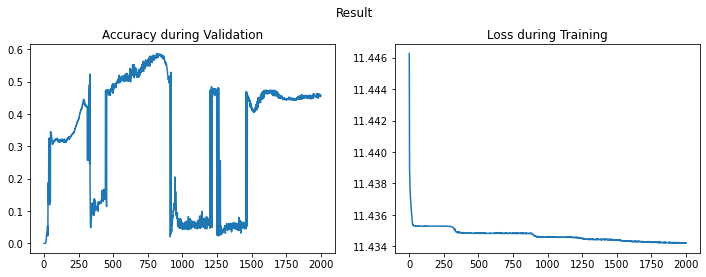

In [12]:
from matplotlib import pyplot as plt

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
ax[0].plot(accs)
ax[0].set_title('Accuracy during Validation')
ax[1].plot(losses)
ax[1].set_title('Loss during Training')

plt.subplots_adjust(top=0.85)
plt.suptitle('Result') 
plt.show()